In [1]:
import os
import h5py
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from collections import namedtuple
from scipy.ndimage import gaussian_filter
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
import math

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform
import tensorflow as tf

ki = tf.keras.initializers.RandomNormal()

class CL_ConvNeuralNet(Model):
   
    def __init__(self, input_dims = [14,2], output_dims=[12]):
        
        self.initializer =  tf.keras.initializers.he_uniform()
        self.input_dims = input_dims
        self.output_dims = output_dims
        super(CL_ConvNeuralNet, self).__init__()
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.RMSprop()

    def build_model(self):
        InputImage = layers.Input(shape=(self.input_dims[0],1))
        InputNumeric = layers.Input(shape=(self.input_dims[1]))
        cnet = layers.Dense(512, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(InputImage)

        cnet = layers.Dense(512, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(cnet)
        
        cnet = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(cnet)
        
        
        cnet = layers.Flatten()(cnet)
        
        cnet = Model(inputs=InputImage, outputs=cnet)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(InputNumeric)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(numeric)
        
        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(numeric)

        numeric = Model(inputs=InputNumeric, outputs=numeric)

        combined = layers.concatenate([cnet.output, numeric.output])
        
        x = layers.Dense(512,activation=tf.nn.relu, kernel_initializer=self.initializer)(combined)
        x = layers.Dense(256,activation=tf.nn.relu, kernel_initializer=self.initializer)(x)
        combined_network = layers.Dense(self.output_dims[0],activation='linear', 
                                        kernel_initializer=self.initializer)(x)
    
        model = Model(inputs=[cnet.input, numeric.input], outputs=combined_network)

        return model
    
    # define forward pass
    def call(self, inputs):
        prediction = self.model(inputs)[:,:]

        return prediction


2023-05-23 11:01:47.281706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from collections import namedtuple
from scipy.ndimage import gaussian_filter
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
%matplotlib inline
start_pix = 55
end_pix = 70

from scipy import interpolate

def smooth_window(data, window_size):
    return np.convolve(data, np.ones((window_size,))/window_size, mode='valid')

def return_norm_wall_loc(am_img, start_pix = start_pix, end_pix = end_pix,
                        window_size=1):
    
    wps = np.zeros(shape=am_img.shape[0])
    for ind in range(am_img.shape[0]):
        wall_profile = smooth_window(am_img[ind,start_pix:end_pix], window_size)
        f = interpolate.interp1d(np.arange(len(wall_profile)), wall_profile, kind = 'nearest')
        xnew = np.linspace(0, len(wall_profile)-1, 128*10, endpoint = True)
        norm_wall_profile = np.argmax(np.diff(f(xnew)))
        subpix_max = xnew[norm_wall_profile]
        wps[ind] = subpix_max
    return wps


def normalize_images(input_images):
    return (input_images - np.min(input_images)) / (np.max(input_images) - np.min(input_images))

# Dataset 1

In [4]:
folder = r'/Users/bry/Dropbox'
file_name = 'wall_pulsing_revised_smaller_PTO_40deg.p'
path_to_file = os.path.join(folder, file_name)
data = pickle.load(open(path_to_file, 'rb'))

In [5]:
data_collected = data['results']
wall_bias_locs = data['wall_locs']

pix = 128
reset_freq = 10
max_bias = 10
max_pw = 500
window_size=3

local_win_size = 7
min_ind = 0.046875 
max_ind = 0.9 


In [6]:
phase_images = []
amp_images = []

for ind in range(len(data_collected)):
    output=np.asarray(data_collected[ind])
    amp_img = output[2].reshape(-1, pix*2)
    phase_img = output[3].reshape(-1, pix*2)

    amp_images.append(amp_img[:,:pix])
    phase_images.append(phase_img[:,:pix]) 

In [7]:
l=0

actions = []
actions_norm = []

index_tracker =[]

for ind in range(len(data_collected)):

    
    if ind%reset_freq!=0:
        xpos,ypos = wall_bias_locs[l][3], wall_bias_locs[l][4] 
        bias_amp, bias_pw = wall_bias_locs[l][1], wall_bias_locs[l][2]


        xpos_norm = xpos/pix
        ypos_norm = ypos/pix
        bias_amp_norm = bias_amp/max_bias
        bias_pw_norm = bias_pw/max_pw
        index_tracker.append((ind,l))
        l+=1
    else:
        xpos = np.nan
        ypos = np.nan
        xpos_norm = np.nan
        ypos_norm = np.nan
        bias_amp = np.nan
        bias_pw = np.nan
        bias_amp_norm = np.nan
        bias_pw_norm = np.nan
        zero = np.nan
        one = np.nan
        two = np.nan
        three = np.nan
    
    actions.append([xpos,ypos, bias_amp, bias_pw])
    actions_norm.append([xpos_norm, ypos_norm, bias_amp_norm, bias_pw_norm])



# Dataset 2

In [8]:
path = r'/Users/bry/Dropbox/New effort November 2022/wall pulsing/BE Version/'

all_img_bias=[]
for k in range(300,604):
    try:
        file_name_0 = path + 'Transition_k=' + str(k) + '.h5'
        h5_f0 = h5py.File(file_name_0, 'r+')
        bias_details0 = h5_f0['Measurement_000'].attrs['bias_details']
        h5_f0.close()
        bias_details0 = np.insert(bias_details0, 0, k)
        all_img_bias.append(bias_details0)
        k+=1
    except:
        print("Something went wrong:", k)
        k+=1

Something went wrong: 300
Something went wrong: 301


In [9]:
m=0
amp = []
phase = []
for k in range(300,604): #start,stop,step
    try:
        file_name_0 = path + 'Transition_k=' + str(k) + '.h5'
        h5_f0 = h5py.File(file_name_0, 'r+')
        qf0 = h5_f0['Measurement_000']['sho_fit']['sho_fit']

        imamp = qf0[:,:,0]
        imphase = qf0[:,:,3]
        amp.append(imamp)
        phase.append(imphase)
        h5_f0.close()
        m+=1
    except:
        print("Something went wrong:", k)

Something went wrong: 300
Something went wrong: 301
Something went wrong: 303
Something went wrong: 304


In [10]:
#We only want the images that have associated actions, so ignore the first few
all_img_bias = all_img_bias[2:]

amp_images_new = amp 
phase_images_new = phase 

In [11]:
params={'xtick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['figure.dpi']=300

# Dataset 1

In [12]:
phase_images_segmented = np.copy(amp_images)
phase_images_segmented = normalize_images(phase_images_segmented)
phase_images_segmented[phase_images_segmented<0.2] = 0
phase_images_segmented[phase_images_segmented>=0.4] = 1

In [13]:

transitions = []
transitions_norm = []
transitions_profiles = []
for ind in range(1, len(phase_images)):
    tnew = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_norm = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_prof = namedtuple('Transition', ['state','action', 'next_state'])
    
    tnew.state = phase_images_segmented[ind-1]
    tnew.next_state = phase_images_segmented[ind]
    tnew.action = actions[ind]
    
    tnew_norm.state = phase_images_segmented[ind-1]
    tnew_norm.next_state = phase_images_segmented[ind]
    tnew_norm.action = actions_norm[ind]
    
    state = tnew.state
    next_state = tnew.next_state
    shift, error, diffphase = phase_cross_correlation(state, next_state,
                                                  upsample_factor=3)
    offset_image = fourier_shift(np.fft.fftn(next_state), shift)
    offset_image = np.fft.ifftn(offset_image)
    next_state = offset_image.real
    wps = return_norm_wall_loc(state, window_size=window_size) + start_pix
    wps_next = return_norm_wall_loc(next_state,window_size=window_size) + start_pix
    
    tnew_prof.state = wps
    tnew_prof.action = tnew_norm.action
    tnew_prof.next_state = wps_next
    
    if not np.isnan(tnew.action[0]) and not np.isnan(actions[ind+1][0]):
        transitions.append(tnew)
        transitions_norm.append(tnew_norm)
        transitions_profiles.append(tnew_prof)

# Dataset 2

In [14]:
l=0
bpw = []
bamp = []
for ind in range(1,301): 
    
    bias_amp, bias_pw = all_img_bias[l][1], all_img_bias[l][2]
    l+=1
    bpw.append(bias_pw)
    bamp.append(bias_amp)



In [15]:
l=0
actions_new = []
actions_norm_new = []
index_tracker_new =[]

for ind in range(1,301): 
    
     
    xpos,ypos = all_img_bias[l][-2], all_img_bias[l][-1] 
    bias_amp, bias_pw = all_img_bias[l][1], all_img_bias[l][2]
    bias_pw=bias_pw*1000

    xpos_norm = xpos/pix
    ypos_norm = ypos/pix
    bias_amp_norm = bias_amp/max_bias
    bias_pw_norm = bias_pw/max_pw
    index_tracker.append((ind,l))
    l+=1

    
    actions_new.append([xpos,ypos, bias_amp, bias_pw])
    actions_norm_new.append([xpos_norm, ypos_norm, bias_amp_norm, bias_pw_norm])

In [16]:
phase_images_segmented = np.copy(amp_images_new)
phase_images_segmented = normalize_images(phase_images_segmented)
phase_images_segmented[phase_images_segmented<0.2] = 0
phase_images_segmented[phase_images_segmented>=0.4] = 1

In [17]:

for ind in range(1, len(phase_images_new)):
    tnew = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_norm = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_prof = namedtuple('Transition', ['state','action', 'next_state'])
    
    tnew.state = phase_images_segmented[ind-1]
    tnew.next_state = phase_images_segmented[ind]
    tnew.action = actions_new[ind]
    
    tnew_norm.state = phase_images_segmented[ind-1]
    tnew_norm.next_state = phase_images_segmented[ind]
    tnew_norm.action = actions_norm_new[ind]
    
    state = tnew.state
    next_state = tnew.next_state
    shift, error, diffphase = phase_cross_correlation(state, next_state,
                                                  upsample_factor=3)
    offset_image = fourier_shift(np.fft.fftn(next_state), shift)
    offset_image = np.fft.ifftn(offset_image)
    next_state = offset_image.real
    wps = return_norm_wall_loc(state, window_size=window_size) + start_pix
    wps_next = return_norm_wall_loc(next_state,window_size=window_size) + start_pix
    
    tnew_prof.state = wps
    tnew_prof.action = tnew_norm.action
    tnew_prof.next_state = wps_next
    
    #if not np.isnan(tnew.action[0]) and not np.isnan(actions[ind+1][0]):
    transitions.append(tnew)
    transitions_norm.append(tnew_norm)
    transitions_profiles.append(tnew_prof)


In [18]:
local_win_size = 7
offset=5
local_state_size = 14
train_fraction = 0.80
num_training_points = len(transitions_norm)

train_split_indices = np.random.choice(np.arange(len(transitions_norm)),
                                       (int(num_training_points*train_fraction)),
                                       replace = False)

test_split_indices = [val for val in np.arange(len(transitions_norm)) if val not in train_split_indices]

#Once we have the indices we need to make the training data. X_train, y_train, X_test, y_test
#X_train is the action, state, y_train is the state+1
#Same goes for X_test and y_test
X_train, y_train, X_test, y_test = [], [], [], []

for train_ind in train_split_indices:
    transition = transitions_norm[train_ind]
    trans_profile = transitions_profiles[train_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_train.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_train.append(smooth_window(dprof,window_size=3))

for test_ind in test_split_indices:
    transition = transitions_norm[test_ind]
    trans_profile = transitions_profiles[test_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_test.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_test.append(smooth_window(dprof,window_size=3))
    
def myGenerator(batch_size = 16, num_batches = 32, image_noise = 0.001,action_noise = 0.001):
    batch_num = 0
    while batch_num < num_batches:
        
        train_data_slice = np.random.choice(np.arange(len(X_train)),size = batch_size, replace = False)
        validation_data_slice = np.random.choice(np.arange(len(X_test)),
                                                 size = min(8,batch_size), replace = False)
        
        xtrain = [X_train[int(val)] for val in train_data_slice]
        ytrain = [y_train[int(val)] for val in train_data_slice]
        
        xtest = [X_test[int(val)] for val in validation_data_slice]
        ytest = [y_test[int(val)] for val in validation_data_slice]
        
        #Convert to tensorflow arrays - training data
        xtrain_images = np.zeros(shape=(batch_size, xtrain[0][0].shape[0]))
        for ind in range(len(train_data_slice)): 
            xtrain_images[ind,:] = xtrain[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtrain[ind][0])))                  
        xtrain_images = tf.stack(xtrain_images)
        
        xtrain_actions = np.zeros(shape=(batch_size, len(xtrain[0][1])))
        for ind in range(len(train_data_slice)): 
            xtrain_actions[ind,:] = xtrain[ind][1]
            
        xtrain_actions = tf.stack(xtrain_actions)
        xtrain = [xtrain_images[:,:,None], xtrain_actions]
        
        #Convert to tensorflow arrays - testing data
        xtest_images = np.zeros(shape=((len(xtest)), xtest[0][0].shape[0]))
        for ind in range(len(validation_data_slice)): 
            xtest_images[ind,:] = xtest[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtest[ind][0])))                    
        xtest_images = tf.stack(xtest_images)
        
        xtest_actions = np.zeros(shape=(len(xtest), len(xtest[0][1])))
        for ind in range(len(validation_data_slice)): 
            xtest_actions[ind,:] = xtest[ind][1] + np.random.normal(loc=0.0, scale = action_noise,size=(2))
            
        xtest_actions = tf.stack(xtest_actions)
        
        xtest = [xtest_images[:,:,None], xtest_actions]
        
        yield xtrain, tf.stack(ytrain), xtest, tf.stack(ytest)
        batch_num+=1

In [19]:
ynet = CL_ConvNeuralNet()

stats = []
mygen = myGenerator(batch_size = 32, num_batches = 3000)
i=0
train_separate_branch = False 
penalty=2.0
#Let's write the training
ok_spectra=0
bad_spectra=0
num_batches = 32

mse = tf.keras.losses.MeanSquaredError()

for mxtrain, mytrain, mxtest, mytest in mygen:
    with tf.GradientTape() as tape:
        
        prediction = ynet(mxtrain)
        actions_original = mxtrain[1][:,:]

        batch_loss=0
        for t in range(num_batches):
            local_loss=0
            Voltages=actions_original[0][:1]
            input_wall = mxtrain[0][t]

            PW=actions_original[t][1:]
            mynewtrain=mytrain[t]

            output_spectra = prediction[t,:]
            
            #new regularization for monotonicity
            mono_loss = 0
            test_images, test_actions = [], []
            pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
            
            for p in pwidths:
                 test_action_val_new_valp=p   
                 test_action_val_new_valv=0.5
                 test_actions.append([test_action_val_new_valv, test_action_val_new_valp])
                 test_images.append(input_wall)
            test_input = [tf.stack(test_images), tf.stack(test_actions)] 
            output = ynet(test_input)
            npoutput = output.numpy()
            arr = np.trapz((npoutput.T-npoutput.T.min()))     
            for idx in range(1, len(arr)):
                if arr[idx - 1] < arr[idx]:
                    do_nothing=1
                else:
                    mono_loss+=1

            #local physics based loss penalization/regulatization
            for m in range(12):
                output_elementnp = output_spectra[m].numpy()
                mynewtrainelement = mynewtrain[m].numpy()
                output_element = output_spectra[m]
                Ratio = output_elementnp/Voltages
                if Ratio < 0: #single negative value, somethings wrong physically and we should penalize
                    bad_spectra = (mynewtrainelement- output_element)**2 * penalty
                if Ratio > 0:
                    ok_spectra = (mynewtrainelement- output_element)**2
                total_loss = (bad_spectra + ok_spectra)/12
                local_loss+=total_loss
                local_loss+=mono_loss/(i+1)
            batch_loss+=local_loss
            
        print("loss batch it {} is {:.5f}  ".format(i, batch_loss))
            

        gradients = tape.gradient(batch_loss, ynet.trainable_variables)

    ynet.optimizer.apply_gradients(zip(gradients, ynet.trainable_variables))
    
    
    i+=1
    
    
#ynet.model.save_weights('trained_surrogate_weights_phys.h5')

2023-05-23 11:02:33.371933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/bry/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


loss batch it 0 is 2854.06201  
loss batch it 1 is 73105.25000  
loss batch it 2 is 1331.61279  
loss batch it 3 is 810.42670  
loss batch it 4 is 504.09863  
loss batch it 5 is 382.76746  
loss batch it 6 is 300.74353  
loss batch it 7 is 275.84201  
loss batch it 8 is 269.53278  
loss batch it 9 is 220.10960  
loss batch it 10 is 196.16895  
loss batch it 11 is 201.94739  
loss batch it 12 is 187.60081  
loss batch it 13 is 203.14417  
loss batch it 14 is 174.61566  
loss batch it 15 is 141.28506  
loss batch it 16 is 134.05098  
loss batch it 17 is 124.26223  
loss batch it 18 is 123.94591  
loss batch it 19 is 115.14157  
loss batch it 20 is 105.34750  
loss batch it 21 is 100.48485  
loss batch it 22 is 108.44222  
loss batch it 23 is 110.19262  
loss batch it 24 is 101.14913  
loss batch it 25 is 104.38560  
loss batch it 26 is 97.70222  
loss batch it 27 is 90.96044  
loss batch it 28 is 82.43442  
loss batch it 29 is 72.84116  
loss batch it 30 is 69.19463  
loss batch it 31 is

loss batch it 259 is 18.20739  
loss batch it 260 is 16.68514  
loss batch it 261 is 20.80042  
loss batch it 262 is 21.17194  
loss batch it 263 is 77.38215  
loss batch it 264 is 11.54424  
loss batch it 265 is 17.09915  
loss batch it 266 is 16.29238  
loss batch it 267 is 14.68542  
loss batch it 268 is 16.50939  
loss batch it 269 is 14.73584  
loss batch it 270 is 15.07107  
loss batch it 271 is 10.84853  
loss batch it 272 is 16.36086  
loss batch it 273 is 12.09938  
loss batch it 274 is 11.82972  
loss batch it 275 is 11.10136  
loss batch it 276 is 10.56245  
loss batch it 277 is 11.54123  
loss batch it 278 is 9.30022  
loss batch it 279 is 12.71163  
loss batch it 280 is 13.39298  
loss batch it 281 is 14.02941  
loss batch it 282 is 9.90559  
loss batch it 283 is 14.64041  
loss batch it 284 is 13.73622  
loss batch it 285 is 11.57052  
loss batch it 286 is 17.05399  
loss batch it 287 is 15.65322  
loss batch it 288 is 9.43672  
loss batch it 289 is 8.80005  
loss batch i

loss batch it 519 is 13.79007  
loss batch it 520 is 11.38604  
loss batch it 521 is 13.42225  
loss batch it 522 is 8.43953  
loss batch it 523 is 8.93966  
loss batch it 524 is 12.34899  
loss batch it 525 is 9.38851  
loss batch it 526 is 7.37536  
loss batch it 527 is 7.42793  
loss batch it 528 is 11.01891  
loss batch it 529 is 7.03595  
loss batch it 530 is 9.79636  
loss batch it 531 is 8.47890  
loss batch it 532 is 8.49056  
loss batch it 533 is 8.76555  
loss batch it 534 is 7.87971  
loss batch it 535 is 9.46563  
loss batch it 536 is 7.70441  
loss batch it 537 is 7.07831  
loss batch it 538 is 9.62633  
loss batch it 539 is 10.96468  
loss batch it 540 is 10.40391  
loss batch it 541 is 6.55271  
loss batch it 542 is 8.10938  
loss batch it 543 is 9.52304  
loss batch it 544 is 7.81131  
loss batch it 545 is 9.73355  
loss batch it 546 is 9.56019  
loss batch it 547 is 8.43753  
loss batch it 548 is 8.01329  
loss batch it 549 is 10.92544  
loss batch it 550 is 13.10058  

loss batch it 783 is 4.43724  
loss batch it 784 is 4.79773  
loss batch it 785 is 5.37940  
loss batch it 786 is 6.60024  
loss batch it 787 is 4.52494  
loss batch it 788 is 3.65199  
loss batch it 789 is 4.36986  
loss batch it 790 is 4.27844  
loss batch it 791 is 4.17199  
loss batch it 792 is 4.63691  
loss batch it 793 is 5.48722  
loss batch it 794 is 5.89093  
loss batch it 795 is 4.64235  
loss batch it 796 is 3.94953  
loss batch it 797 is 5.66319  
loss batch it 798 is 4.73533  
loss batch it 799 is 4.69402  
loss batch it 800 is 4.03463  
loss batch it 801 is 3.96906  
loss batch it 802 is 4.90865  
loss batch it 803 is 3.94030  
loss batch it 804 is 5.00567  
loss batch it 805 is 3.82701  
loss batch it 806 is 3.72168  
loss batch it 807 is 4.23582  
loss batch it 808 is 5.17767  
loss batch it 809 is 4.97170  
loss batch it 810 is 5.13860  
loss batch it 811 is 5.79757  
loss batch it 812 is 4.78068  
loss batch it 813 is 5.14948  
loss batch it 814 is 4.82118  
loss bat

loss batch it 1046 is 3.04332  
loss batch it 1047 is 3.55572  
loss batch it 1048 is 2.93779  
loss batch it 1049 is 3.15109  
loss batch it 1050 is 2.67504  
loss batch it 1051 is 2.99331  
loss batch it 1052 is 3.05363  
loss batch it 1053 is 3.67856  
loss batch it 1054 is 2.84593  
loss batch it 1055 is 3.15205  
loss batch it 1056 is 3.25267  
loss batch it 1057 is 2.65488  
loss batch it 1058 is 2.43414  
loss batch it 1059 is 2.96187  
loss batch it 1060 is 3.07217  
loss batch it 1061 is 3.07024  
loss batch it 1062 is 3.08615  
loss batch it 1063 is 2.92373  
loss batch it 1064 is 2.85158  
loss batch it 1065 is 2.76848  
loss batch it 1066 is 2.89239  
loss batch it 1067 is 2.97935  
loss batch it 1068 is 3.32655  
loss batch it 1069 is 2.65846  
loss batch it 1070 is 2.97183  
loss batch it 1071 is 3.33498  
loss batch it 1072 is 3.13913  
loss batch it 1073 is 3.90739  
loss batch it 1074 is 3.17260  
loss batch it 1075 is 2.52896  
loss batch it 1076 is 3.29633  
loss bat

loss batch it 1303 is 2.30188  
loss batch it 1304 is 2.02934  
loss batch it 1305 is 2.52156  
loss batch it 1306 is 2.60854  
loss batch it 1307 is 2.21545  
loss batch it 1308 is 1.91567  
loss batch it 1309 is 2.17502  
loss batch it 1310 is 2.23439  
loss batch it 1311 is 1.89805  
loss batch it 1312 is 2.66956  
loss batch it 1313 is 2.21389  
loss batch it 1314 is 2.33255  
loss batch it 1315 is 2.23356  
loss batch it 1316 is 2.21797  
loss batch it 1317 is 2.21263  
loss batch it 1318 is 2.66142  
loss batch it 1319 is 2.18657  
loss batch it 1320 is 2.60346  
loss batch it 1321 is 2.51025  
loss batch it 1322 is 2.20807  
loss batch it 1323 is 2.15509  
loss batch it 1324 is 2.15700  
loss batch it 1325 is 2.35550  
loss batch it 1326 is 3.69932  
loss batch it 1327 is 3.60505  
loss batch it 1328 is 2.12754  
loss batch it 1329 is 3.12369  
loss batch it 1330 is 2.32093  
loss batch it 1331 is 2.47361  
loss batch it 1332 is 2.32417  
loss batch it 1333 is 2.00152  
loss bat

loss batch it 1560 is 2.17050  
loss batch it 1561 is 1.67964  
loss batch it 1562 is 1.78502  
loss batch it 1563 is 2.02418  
loss batch it 1564 is 1.55371  
loss batch it 1565 is 1.65415  
loss batch it 1566 is 2.57946  
loss batch it 1567 is 1.64237  
loss batch it 1568 is 1.52548  
loss batch it 1569 is 1.59340  
loss batch it 1570 is 1.81489  
loss batch it 1571 is 1.90073  
loss batch it 1572 is 1.62567  
loss batch it 1573 is 1.60404  
loss batch it 1574 is 1.57380  
loss batch it 1575 is 2.20807  
loss batch it 1576 is 1.68384  
loss batch it 1577 is 2.11196  
loss batch it 1578 is 2.21674  
loss batch it 1579 is 1.74805  
loss batch it 1580 is 1.95156  
loss batch it 1581 is 2.69752  
loss batch it 1582 is 1.88576  
loss batch it 1583 is 1.76734  
loss batch it 1584 is 1.65772  
loss batch it 1585 is 1.76555  
loss batch it 1586 is 1.65521  
loss batch it 1587 is 1.64650  
loss batch it 1588 is 1.67213  
loss batch it 1589 is 1.75947  
loss batch it 1590 is 1.81578  
loss bat

loss batch it 1817 is 1.41085  
loss batch it 1818 is 1.64060  
loss batch it 1819 is 1.65708  
loss batch it 1820 is 1.26201  
loss batch it 1821 is 1.66271  
loss batch it 1822 is 1.60439  
loss batch it 1823 is 1.41619  
loss batch it 1824 is 1.59932  
loss batch it 1825 is 1.33103  
loss batch it 1826 is 1.32619  
loss batch it 1827 is 1.35583  
loss batch it 1828 is 1.41425  
loss batch it 1829 is 2.25715  
loss batch it 1830 is 1.47059  
loss batch it 1831 is 1.42313  
loss batch it 1832 is 1.38838  
loss batch it 1833 is 1.40245  
loss batch it 1834 is 2.26136  
loss batch it 1835 is 1.48070  
loss batch it 1836 is 1.45772  
loss batch it 1837 is 1.75655  
loss batch it 1838 is 1.42094  
loss batch it 1839 is 1.62293  
loss batch it 1840 is 1.79956  
loss batch it 1841 is 1.84242  
loss batch it 1842 is 1.91615  
loss batch it 1843 is 1.34886  
loss batch it 1844 is 1.37995  
loss batch it 1845 is 1.41572  
loss batch it 1846 is 1.25645  
loss batch it 1847 is 1.42063  
loss bat

loss batch it 2074 is 1.30070  
loss batch it 2075 is 1.40256  
loss batch it 2076 is 1.31265  
loss batch it 2077 is 1.15404  
loss batch it 2078 is 1.23081  
loss batch it 2079 is 1.19787  
loss batch it 2080 is 1.19265  
loss batch it 2081 is 1.58733  
loss batch it 2082 is 1.36088  
loss batch it 2083 is 1.36042  
loss batch it 2084 is 1.51264  
loss batch it 2085 is 1.32739  
loss batch it 2086 is 1.21480  
loss batch it 2087 is 1.22538  
loss batch it 2088 is 1.22402  
loss batch it 2089 is 1.10853  
loss batch it 2090 is 1.44216  
loss batch it 2091 is 1.16366  
loss batch it 2092 is 1.27558  
loss batch it 2093 is 1.21484  
loss batch it 2094 is 1.18390  
loss batch it 2095 is 1.32494  
loss batch it 2096 is 1.52855  
loss batch it 2097 is 1.40249  
loss batch it 2098 is 1.47218  
loss batch it 2099 is 1.45921  
loss batch it 2100 is 1.67583  
loss batch it 2101 is 1.16319  
loss batch it 2102 is 1.43027  
loss batch it 2103 is 1.31191  
loss batch it 2104 is 1.21200  
loss bat

loss batch it 2331 is 1.12947  
loss batch it 2332 is 1.22933  
loss batch it 2333 is 1.31497  
loss batch it 2334 is 1.06027  
loss batch it 2335 is 1.10127  
loss batch it 2336 is 1.18107  
loss batch it 2337 is 1.19294  
loss batch it 2338 is 1.11425  
loss batch it 2339 is 0.99469  
loss batch it 2340 is 1.13258  
loss batch it 2341 is 1.35499  
loss batch it 2342 is 1.14316  
loss batch it 2343 is 0.94897  
loss batch it 2344 is 1.07302  
loss batch it 2345 is 1.12936  
loss batch it 2346 is 1.00868  
loss batch it 2347 is 1.17059  
loss batch it 2348 is 1.48693  
loss batch it 2349 is 1.18102  
loss batch it 2350 is 2.35166  
loss batch it 2351 is 1.55091  
loss batch it 2352 is 1.09533  
loss batch it 2353 is 1.03820  
loss batch it 2354 is 2.72505  
loss batch it 2355 is 1.09679  
loss batch it 2356 is 1.61910  
loss batch it 2357 is 1.10929  
loss batch it 2358 is 1.07276  
loss batch it 2359 is 1.03915  
loss batch it 2360 is 1.07828  
loss batch it 2361 is 1.04596  
loss bat

loss batch it 2588 is 0.97673  
loss batch it 2589 is 0.97756  
loss batch it 2590 is 0.90050  
loss batch it 2591 is 0.96089  
loss batch it 2592 is 0.91374  
loss batch it 2593 is 0.92712  
loss batch it 2594 is 0.95036  
loss batch it 2595 is 1.00372  
loss batch it 2596 is 1.11813  
loss batch it 2597 is 0.94596  
loss batch it 2598 is 0.95795  
loss batch it 2599 is 0.90533  
loss batch it 2600 is 1.00133  
loss batch it 2601 is 0.84603  
loss batch it 2602 is 0.97277  
loss batch it 2603 is 0.98755  
loss batch it 2604 is 0.90130  
loss batch it 2605 is 0.96995  
loss batch it 2606 is 0.95242  
loss batch it 2607 is 1.03050  
loss batch it 2608 is 1.16998  
loss batch it 2609 is 0.98517  
loss batch it 2610 is 0.91356  
loss batch it 2611 is 1.03640  
loss batch it 2612 is 0.85732  
loss batch it 2613 is 0.96996  
loss batch it 2614 is 0.90873  
loss batch it 2615 is 0.84202  
loss batch it 2616 is 1.08939  
loss batch it 2617 is 1.57034  
loss batch it 2618 is 1.15177  
loss bat

loss batch it 2845 is 0.97517  
loss batch it 2846 is 0.93374  
loss batch it 2847 is 0.83360  
loss batch it 2848 is 0.94704  
loss batch it 2849 is 0.79808  
loss batch it 2850 is 1.00888  
loss batch it 2851 is 0.92491  
loss batch it 2852 is 0.80498  
loss batch it 2853 is 0.82555  
loss batch it 2854 is 1.05716  
loss batch it 2855 is 0.84577  
loss batch it 2856 is 0.80517  
loss batch it 2857 is 0.89539  
loss batch it 2858 is 1.14331  
loss batch it 2859 is 1.00854  
loss batch it 2860 is 0.77347  
loss batch it 2861 is 0.85057  
loss batch it 2862 is 0.95193  
loss batch it 2863 is 1.01025  
loss batch it 2864 is 0.79785  
loss batch it 2865 is 0.96882  
loss batch it 2866 is 0.79764  
loss batch it 2867 is 0.89938  
loss batch it 2868 is 0.88683  
loss batch it 2869 is 1.25857  
loss batch it 2870 is 0.97838  
loss batch it 2871 is 1.01819  
loss batch it 2872 is 0.95121  
loss batch it 2873 is 0.91153  
loss batch it 2874 is 0.90807  
loss batch it 2875 is 1.01168  
loss bat

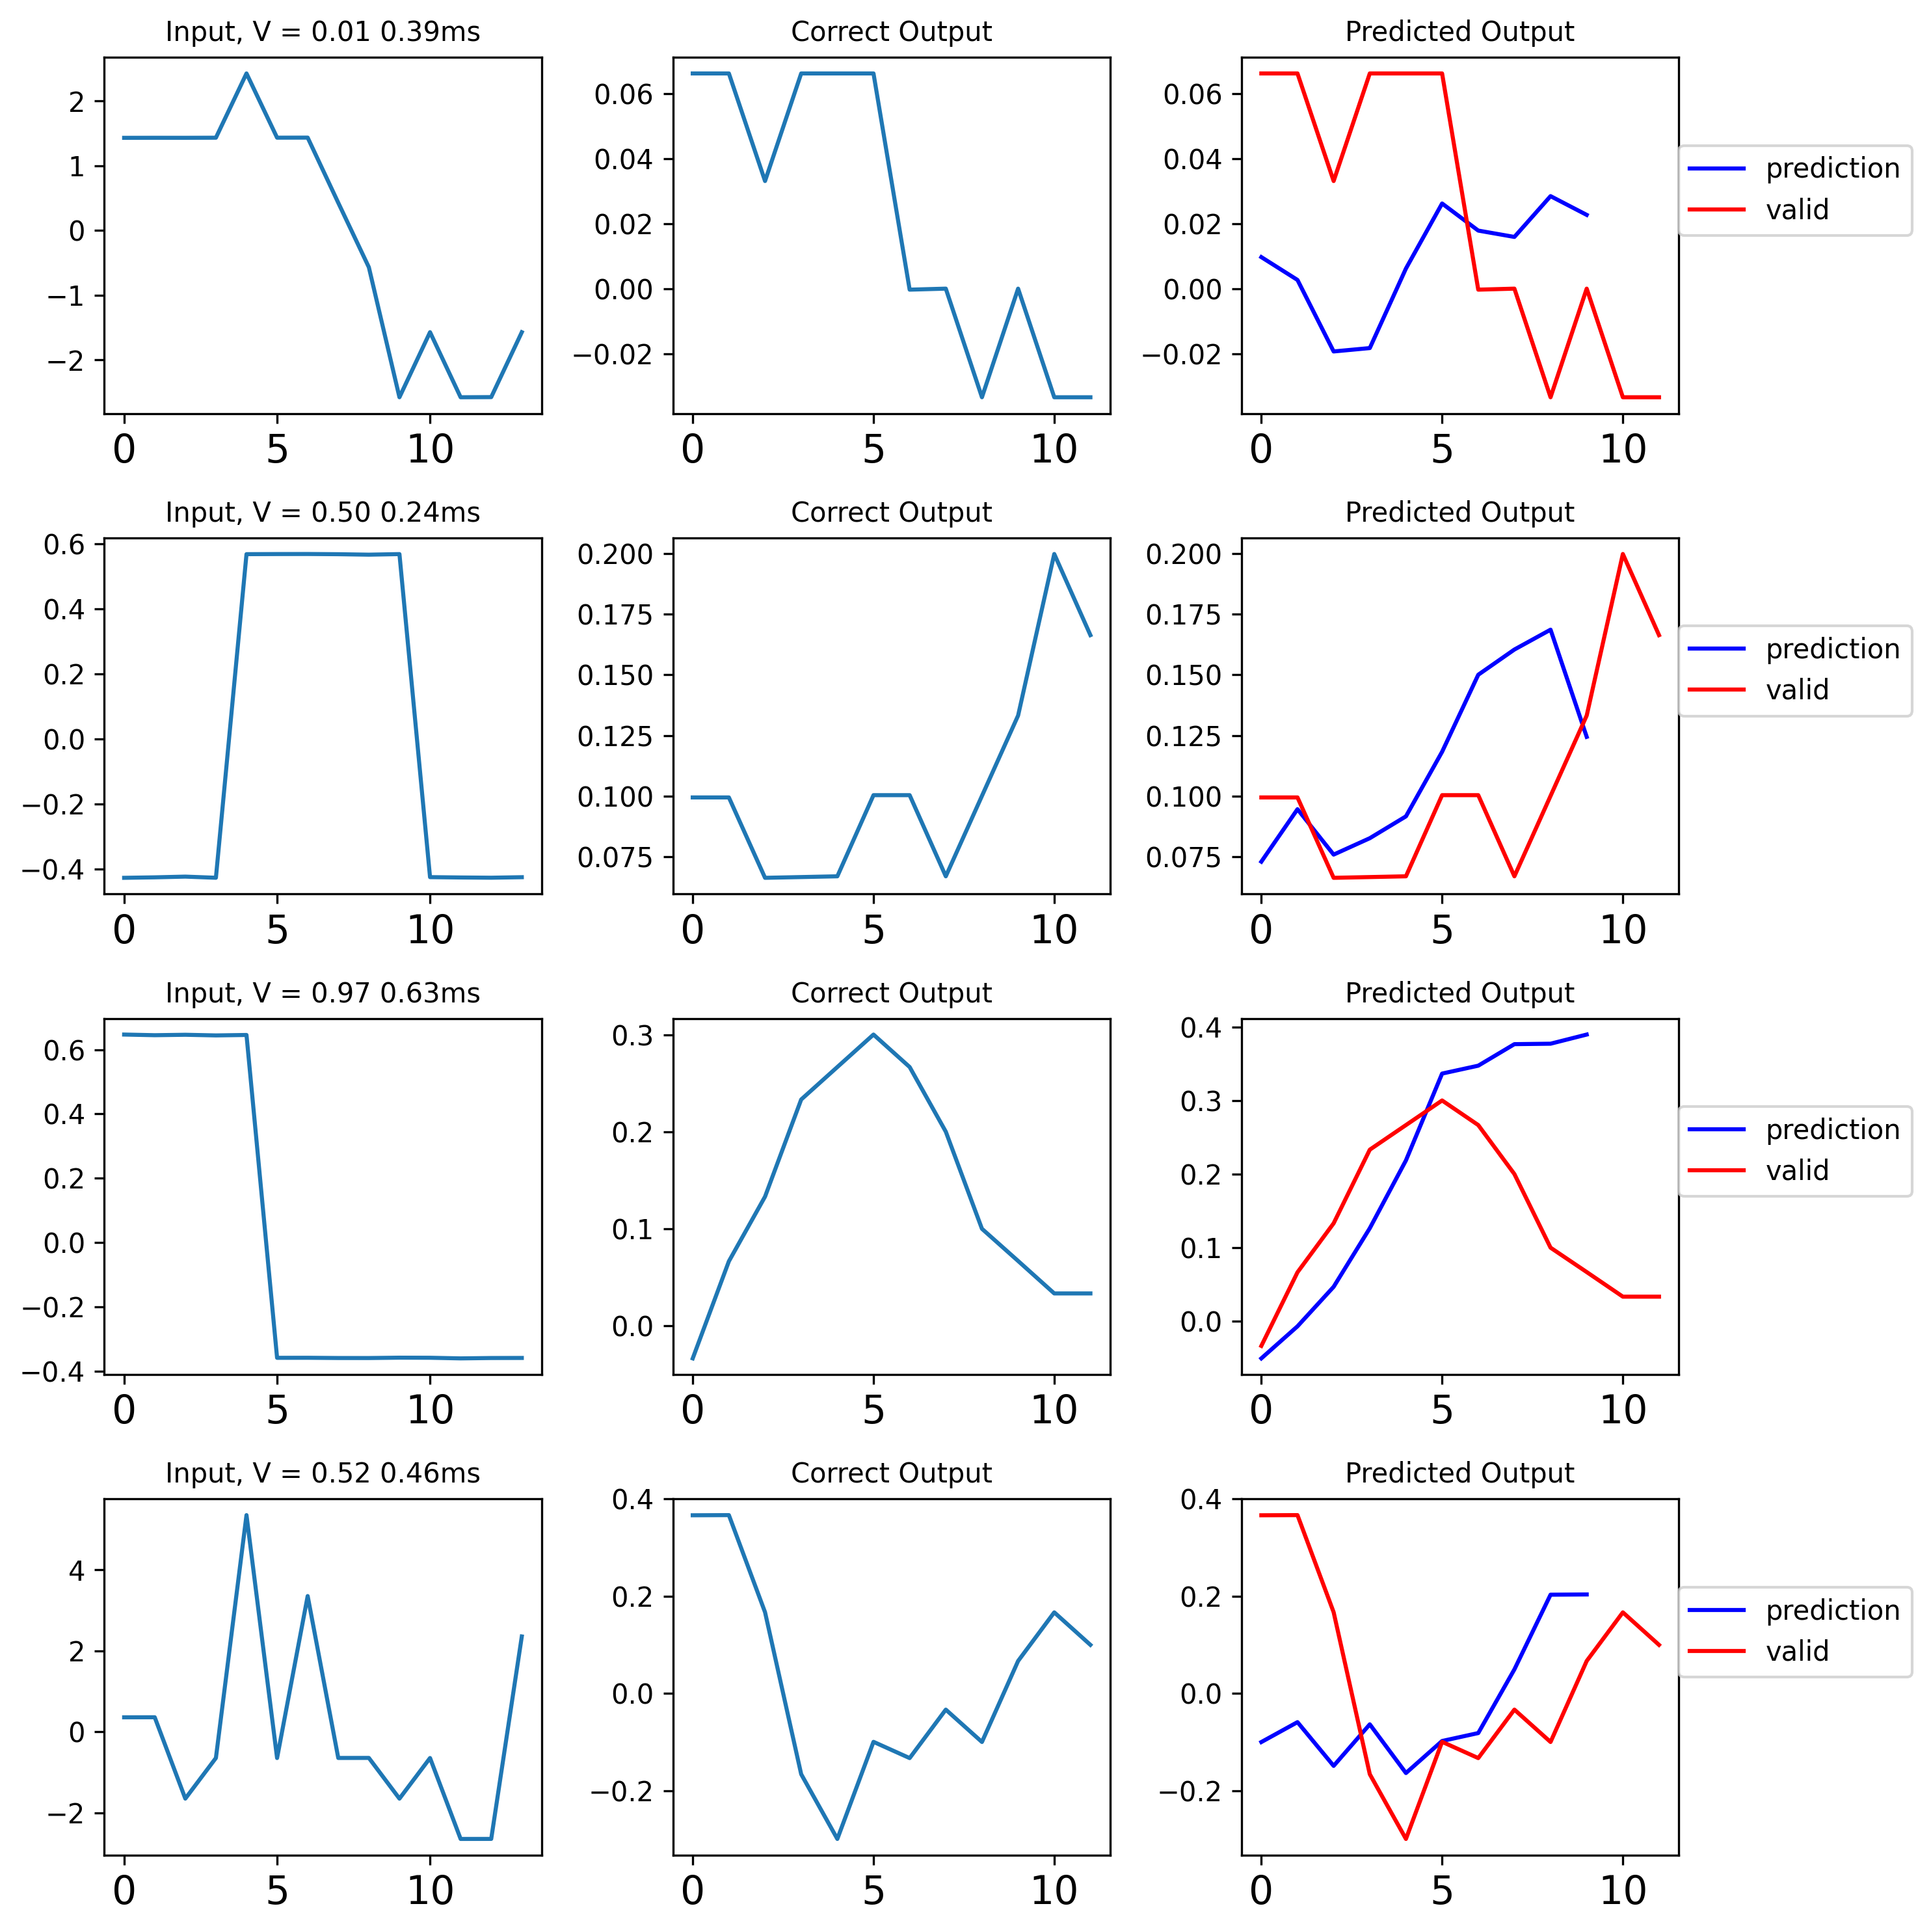

In [20]:
#Let's see what it looks like on one of the validation sets...
font_size = 10
mygen = myGenerator(batch_size = 4, num_batches = 10)

mxtrain, mytrain, mxvalid, myvalid = next(mygen)

predicted_wall = ynet(mxvalid)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize = (10,10))
for row in range(4):
    axes[row,0].plot(mxvalid[0][row,:])
    vval = mxvalid[1][row,0]
    pval = mxvalid[1][row,1]
    
    axes[row,0].set_title('Input, V = {:.2f} {:.2f}ms'.format(vval, pval), fontsize = 10)
    
    axes[row,1].set_title('Correct Output', fontsize = font_size)
    axes[row,1].plot(myvalid[row][:])
    
    axes[row,2].plot(predicted_wall[:,:-2][row], 'b-', label = 'prediction')
    axes[row,2].plot(myvalid[row][:], 'r-', label = 'valid')
    axes[row,2].set_title('Predicted Output', fontsize = font_size)
    axes[row,2].legend(loc = [1.0, 0.5])
    
fig.tight_layout()


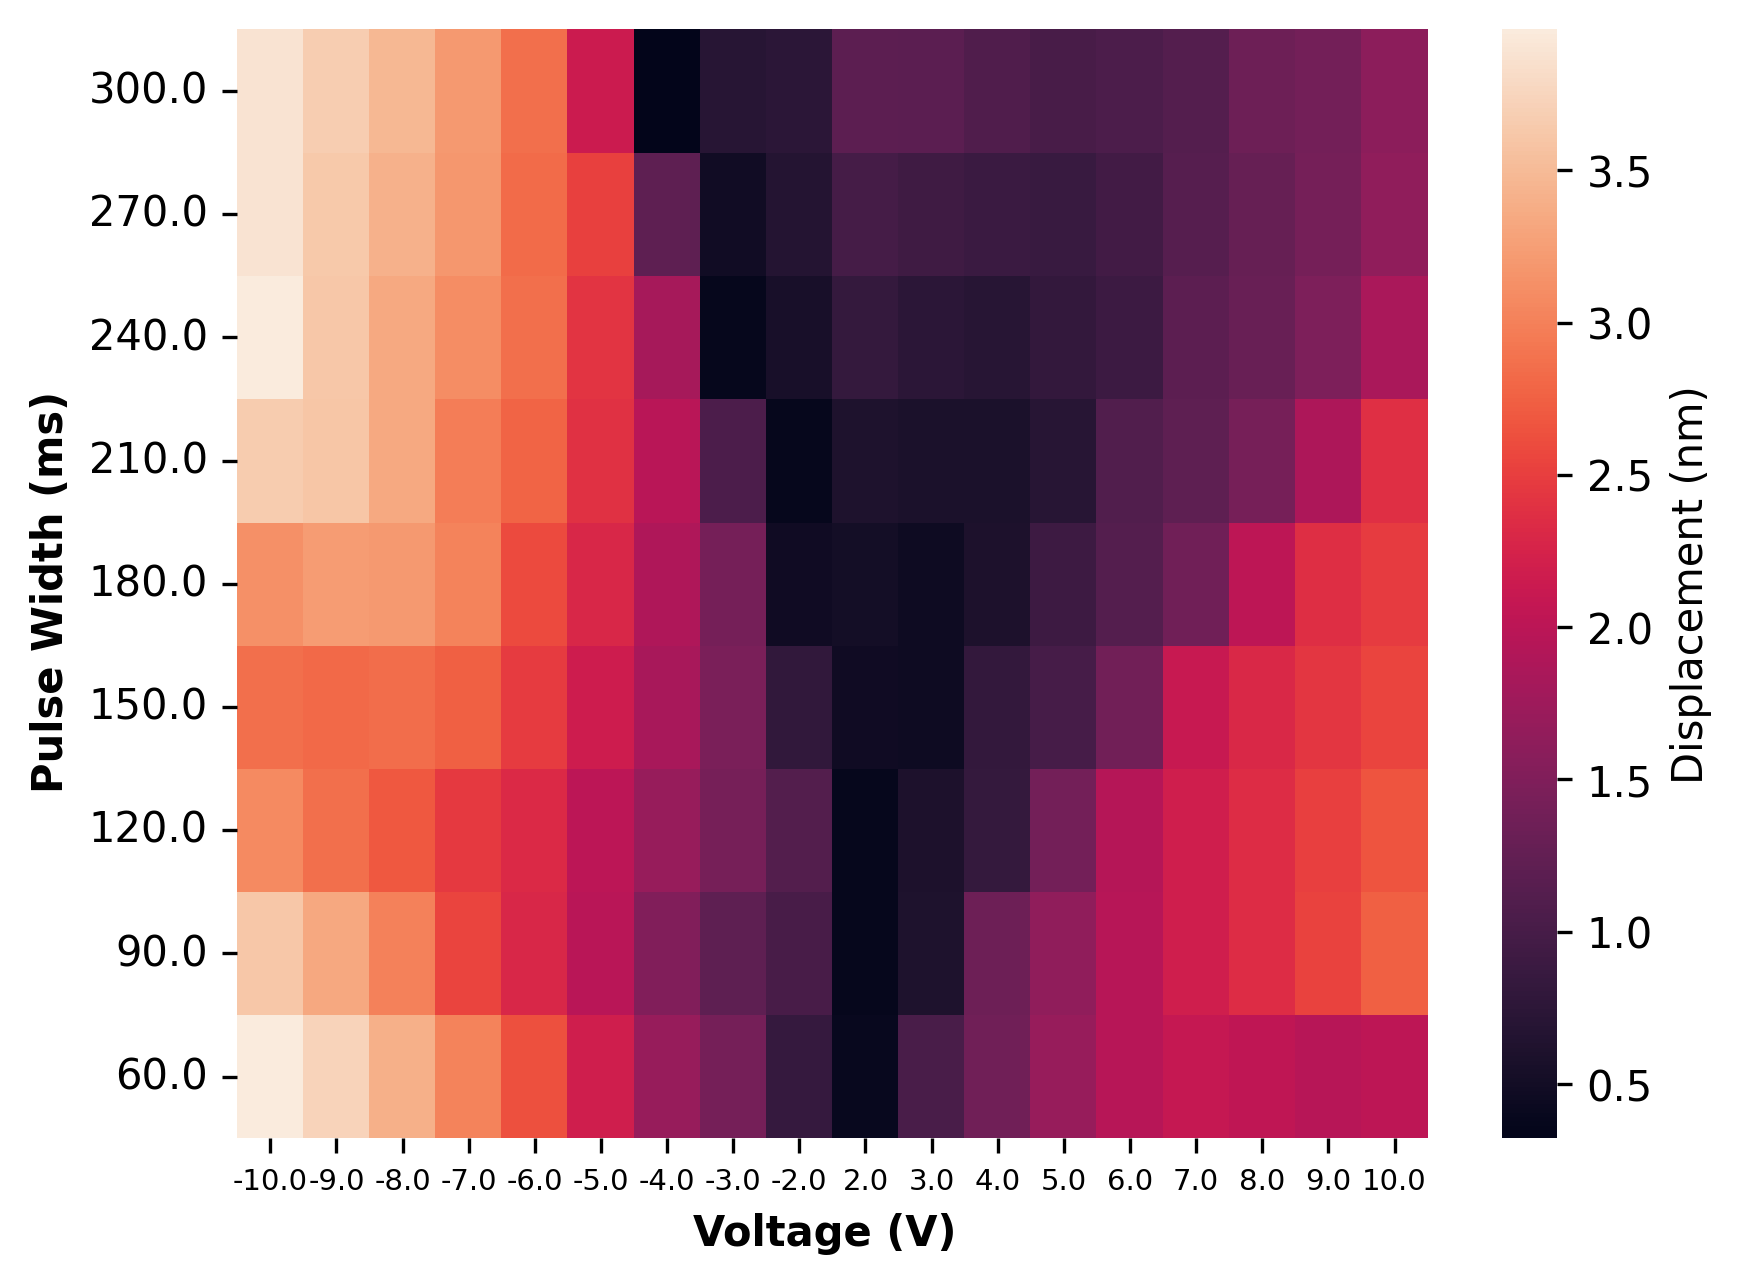

In [21]:

import pandas as pd
import seaborn as sns
#Let's take one prediction, and see how it varies with upping the bias
outputs = []

test_images, test_actions = [], []

#test_image = mxvalid[0][1]
test_image = np.full(14,-0.1)

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#voltages = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=p    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])
        test_images.append(test_image)
test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
maxValues = df.abs().max(axis = 1)
maxValues=maxValues*7.8125 #convert to real values (nm)

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10 #convert to real values (V)
    temp=row[1]*300 #convert to real values (ms)
    row[1]=round(temp)
    new_actions.append(row)
    
actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(maxValues.to_frame(), left_index=True, right_index=True)

table = actionsdf.pivot('Pulse Width (ms)', 'Voltage (V) ')
ax = sns.heatmap(table[0],cbar_kws={'label': 'Displacement (nm)'})
og_table=table[0]
ax.invert_yaxis()
plt.yticks(rotation = 0)
plt.xticks(fontsize=7,rotation=0)
plt.xlabel('Voltage (V) ',fontweight='bold')
plt.ylabel('Pulse Width (ms) ',fontweight='bold')
plt.show()


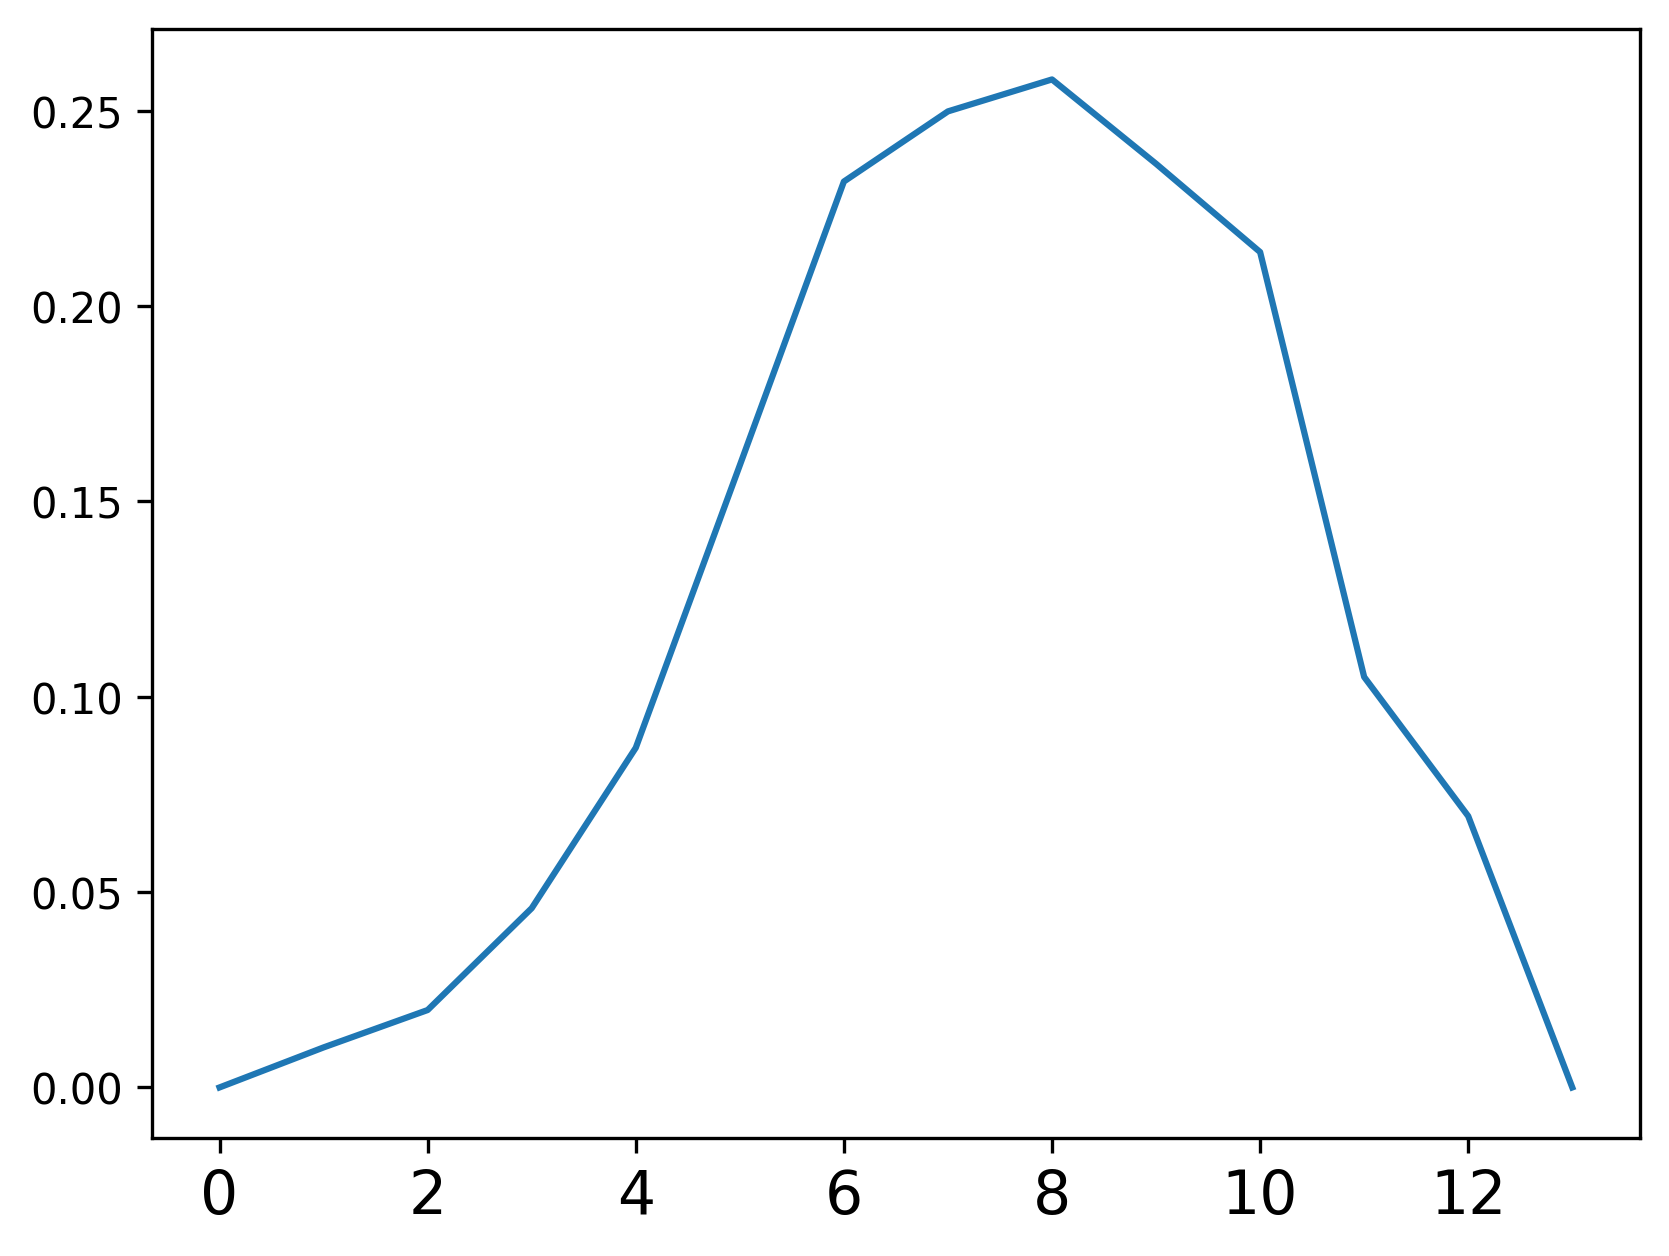

In [22]:
out = np.array(output[139])
out = np.pad(out, pad_width=1)
plt.plot(out)

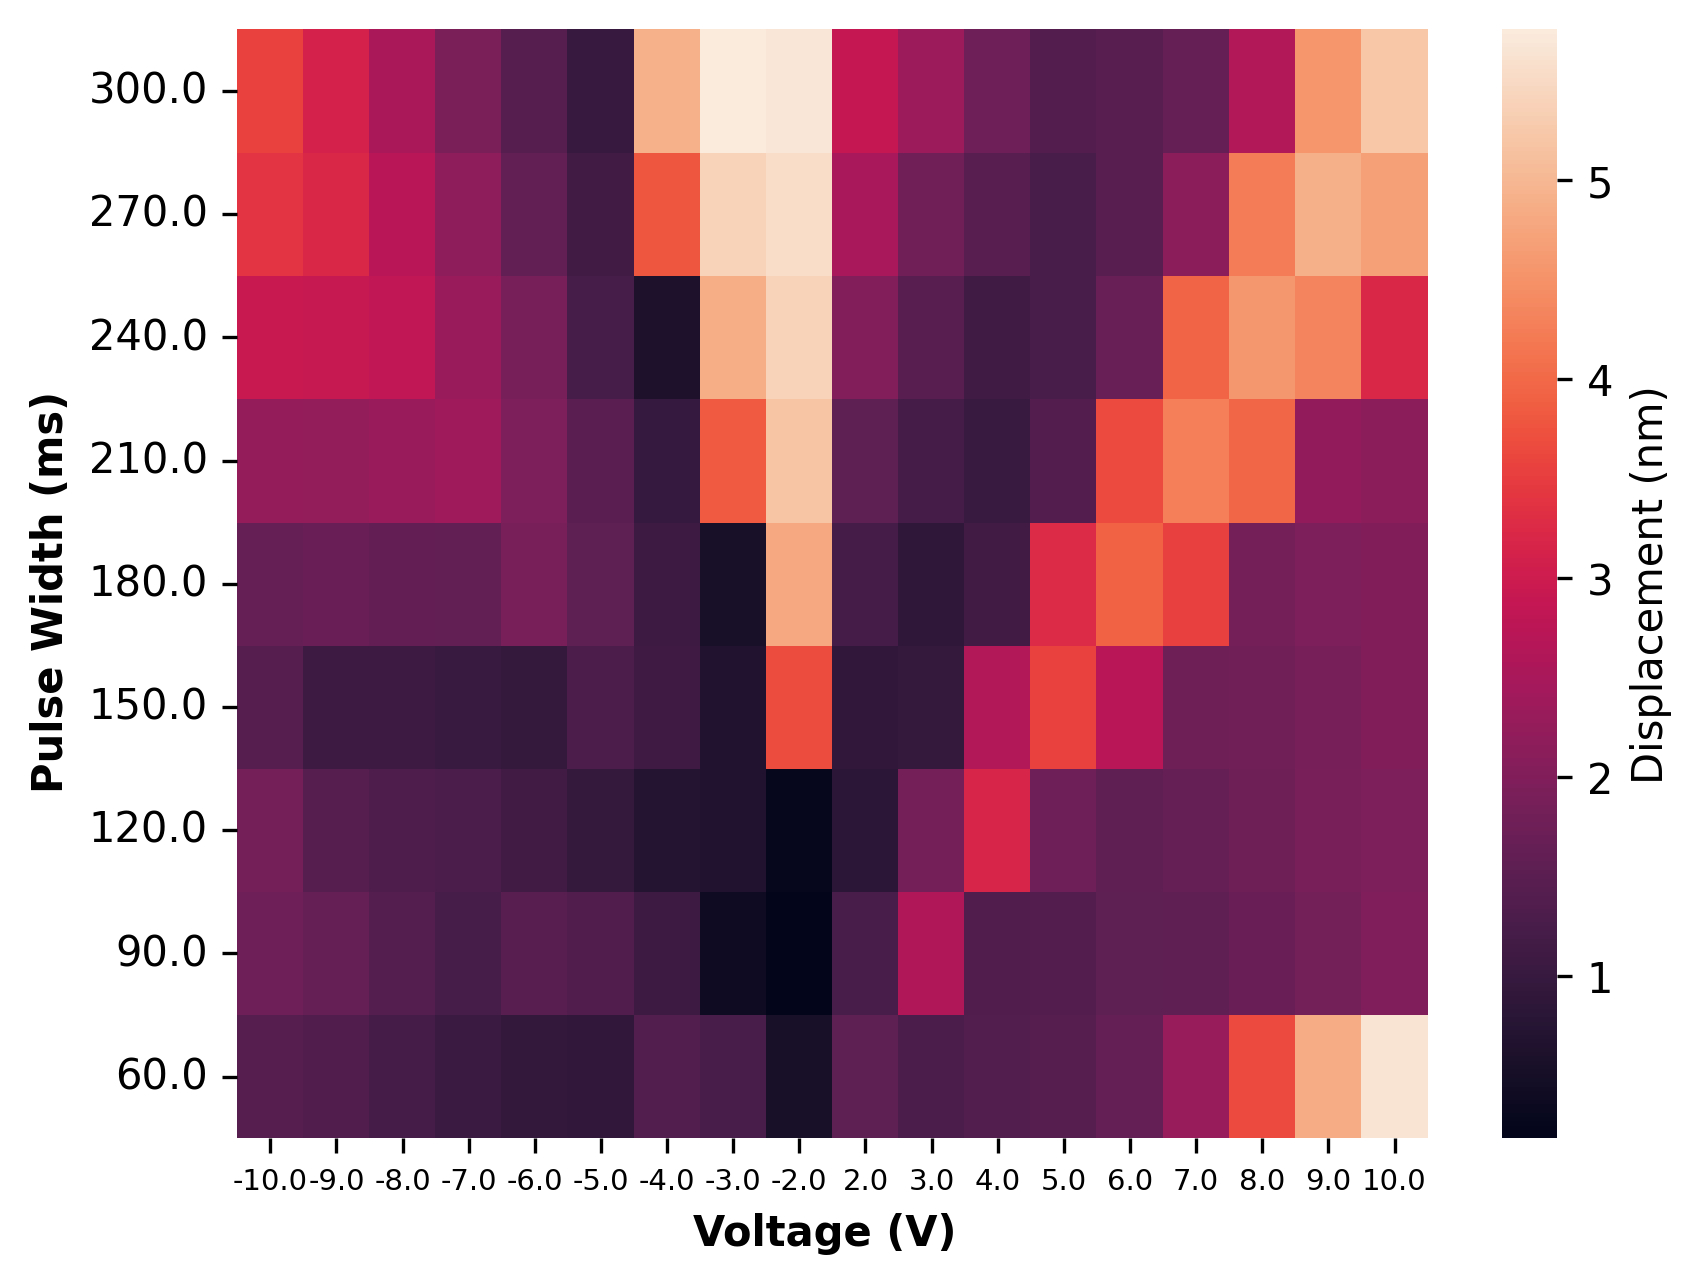

In [23]:

import pandas as pd
import seaborn as sns
#Let's take one prediction, and see how it varies with upping the bias
outputs = []

test_images, test_actions = [], []

#test_image = mxvalid[0][1]
test_image = out
#test_image = row

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=p    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])
        test_images.append(test_image)
test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
maxValues = df.abs().max(axis = 1)
maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*300
    row[1]=round(temp)
    new_actions.append(row)
    
actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(maxValues.to_frame(), left_index=True, right_index=True)

table = actionsdf.pivot('Pulse Width (ms)', 'Voltage (V) ')
ax = sns.heatmap(table[0],cbar_kws={'label': 'Displacement (nm)'})
bulged_table = table[0]
ax.invert_yaxis()
plt.yticks(rotation = 0)
plt.xticks(fontsize=7,rotation=0)
plt.xlabel('Voltage (V) ',fontweight='bold')
plt.ylabel('Pulse Width (ms) ',fontweight='bold')
plt.show()

# Test on datasets seperately

In [24]:
#old data
pix = 128
reset_freq = 10
max_bias = 10
max_pw = 300
window_size=3

local_win_size = 7
min_ind = 0.046875 
max_ind = 0.9

phase_images = []
amp_images = []

for ind in range(len(data_collected)):
    output=np.asarray(data_collected[ind])
    amp_img = output[2].reshape(-1, pix*2)
    phase_img = output[3].reshape(-1, pix*2)

    amp_images.append(amp_img[:,:pix])
    phase_images.append(phase_img[:,:pix]) 

l=0

actions = []
actions_norm = []

index_tracker =[]

for ind in range(len(data_collected)):

    
    if ind%reset_freq!=0:
        xpos,ypos = wall_bias_locs[l][3], wall_bias_locs[l][4] 
        bias_amp, bias_pw = wall_bias_locs[l][1], wall_bias_locs[l][2]
        #encoded_row_location = ypos.astype(int)
        #encoded_info = encoded_old[l][encoded_row_location]
        #zero = encoded_info[0]
        #one = encoded_info[1]
        #two = encoded_info[2]
        #three = encoded_info[3]

        xpos_norm = xpos/pix
        ypos_norm = ypos/pix
        bias_amp_norm = bias_amp/max_bias
        bias_pw_norm = bias_pw/max_pw
        index_tracker.append((ind,l))
        l+=1
    else:
        xpos = np.nan
        ypos = np.nan
        xpos_norm = np.nan
        ypos_norm = np.nan
        bias_amp = np.nan
        bias_pw = np.nan
        bias_amp_norm = np.nan
        bias_pw_norm = np.nan
        #encoded_info = np.nan
        zero = np.nan
        one = np.nan
        two = np.nan
        three = np.nan
    
    actions.append([xpos,ypos, bias_amp, bias_pw])
    actions_norm.append([xpos_norm, ypos_norm, bias_amp_norm, bias_pw_norm])
    #actions.append([xpos,ypos, bias_amp, bias_pw,zero,one,two,three])
    #actions_norm.append([xpos_norm, ypos_norm, bias_amp_norm, bias_pw_norm,zero,one,two,three])

phase_images_segmented = np.copy(amp_images)
phase_images_segmented = normalize_images(phase_images_segmented)
phase_images_segmented[phase_images_segmented<0.2] = 0
phase_images_segmented[phase_images_segmented>=0.4] = 1


transitions = []
transitions_norm = []
transitions_profiles = []
for ind in range(1, len(phase_images)):
    tnew = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_norm = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_prof = namedtuple('Transition', ['state','action', 'next_state'])
    
    tnew.state = phase_images_segmented[ind-1]
    tnew.next_state = phase_images_segmented[ind]
    tnew.action = actions[ind]
    
    tnew_norm.state = phase_images_segmented[ind-1]
    tnew_norm.next_state = phase_images_segmented[ind]
    tnew_norm.action = actions_norm[ind]
    
    state = tnew.state
    next_state = tnew.next_state
    shift, error, diffphase = phase_cross_correlation(state, next_state,
                                                  upsample_factor=3)
    offset_image = fourier_shift(np.fft.fftn(next_state), shift)
    offset_image = np.fft.ifftn(offset_image)
    next_state = offset_image.real
    wps = return_norm_wall_loc(state, window_size=window_size) + start_pix
    wps_next = return_norm_wall_loc(next_state,window_size=window_size) + start_pix
    
    tnew_prof.state = wps
    tnew_prof.action = tnew_norm.action
    tnew_prof.next_state = wps_next
    
    if not np.isnan(tnew.action[0]) and not np.isnan(actions[ind+1][0]):
        transitions.append(tnew)
        transitions_norm.append(tnew_norm)
        transitions_profiles.append(tnew_prof)
local_win_size = 7
offset=5
local_state_size = 14
train_fraction = 0.80
num_training_points = len(transitions_norm)

train_split_indices = np.random.choice(np.arange(len(transitions_norm)),
                                       (int(num_training_points*train_fraction)),
                                       replace = False)

test_split_indices = [val for val in np.arange(len(transitions_norm)) if val not in train_split_indices]

#Once we have the indices we need to make the training data. X_train, y_train, X_test, y_test
#X_train is the action, state, y_train is the state+1
#Same goes for X_test and y_test
X_train, y_train, X_test, y_test = [], [], [], []

for train_ind in train_split_indices:
    transition = transitions_norm[train_ind]
    trans_profile = transitions_profiles[train_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_train.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_train.append(smooth_window(dprof,window_size=3))

for test_ind in test_split_indices:
    transition = transitions_norm[test_ind]
    trans_profile = transitions_profiles[test_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_test.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_test.append(smooth_window(dprof,window_size=3))
    
def myGenerator(batch_size = 16, num_batches = 32, image_noise = 0.001,action_noise = 0.001):
    batch_num = 0
    while batch_num < num_batches:
        
        train_data_slice = np.random.choice(np.arange(len(X_train)),size = batch_size, replace = False)
        validation_data_slice = np.random.choice(np.arange(len(X_test)),
                                                 size = min(8,batch_size), replace = False)
        
        xtrain = [X_train[int(val)] for val in train_data_slice]
        ytrain = [y_train[int(val)] for val in train_data_slice]
        
        xtest = [X_test[int(val)] for val in validation_data_slice]
        ytest = [y_test[int(val)] for val in validation_data_slice]
        
        #Convert to tensorflow arrays - training data
        xtrain_images = np.zeros(shape=(batch_size, xtrain[0][0].shape[0]))
        for ind in range(len(train_data_slice)): 
            xtrain_images[ind,:] = xtrain[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtrain[ind][0])))                  
        xtrain_images = tf.stack(xtrain_images)
        
        xtrain_actions = np.zeros(shape=(batch_size, len(xtrain[0][1])))
        #print(xtrain_actions[ind,:], xtrain[1][1])
        for ind in range(len(train_data_slice)): 
            xtrain_actions[ind,:] = xtrain[ind][1]
            
        xtrain_actions = tf.stack(xtrain_actions)
        xtrain = [xtrain_images[:,:,None], xtrain_actions]
        
        #Convert to tensorflow arrays - testing data
        xtest_images = np.zeros(shape=((len(xtest)), xtest[0][0].shape[0]))
        for ind in range(len(validation_data_slice)): 
            xtest_images[ind,:] = xtest[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtest[ind][0])))                    
        xtest_images = tf.stack(xtest_images)
        
        xtest_actions = np.zeros(shape=(len(xtest), len(xtest[0][1])))
        for ind in range(len(validation_data_slice)): 
            #xtest_actions[ind,:] = xtest[ind][1] + np.random.normal(loc=0.0, scale = action_noise,size=(6))
            xtest_actions[ind,:] = xtest[ind][1] + np.random.normal(loc=0.0, scale = action_noise,size=(2))
            
        xtest_actions = tf.stack(xtest_actions)
        
        xtest = [xtest_images[:,:,None], xtest_actions]
        
        yield xtrain, tf.stack(ytrain), xtest, tf.stack(ytest)
        batch_num+=1
        



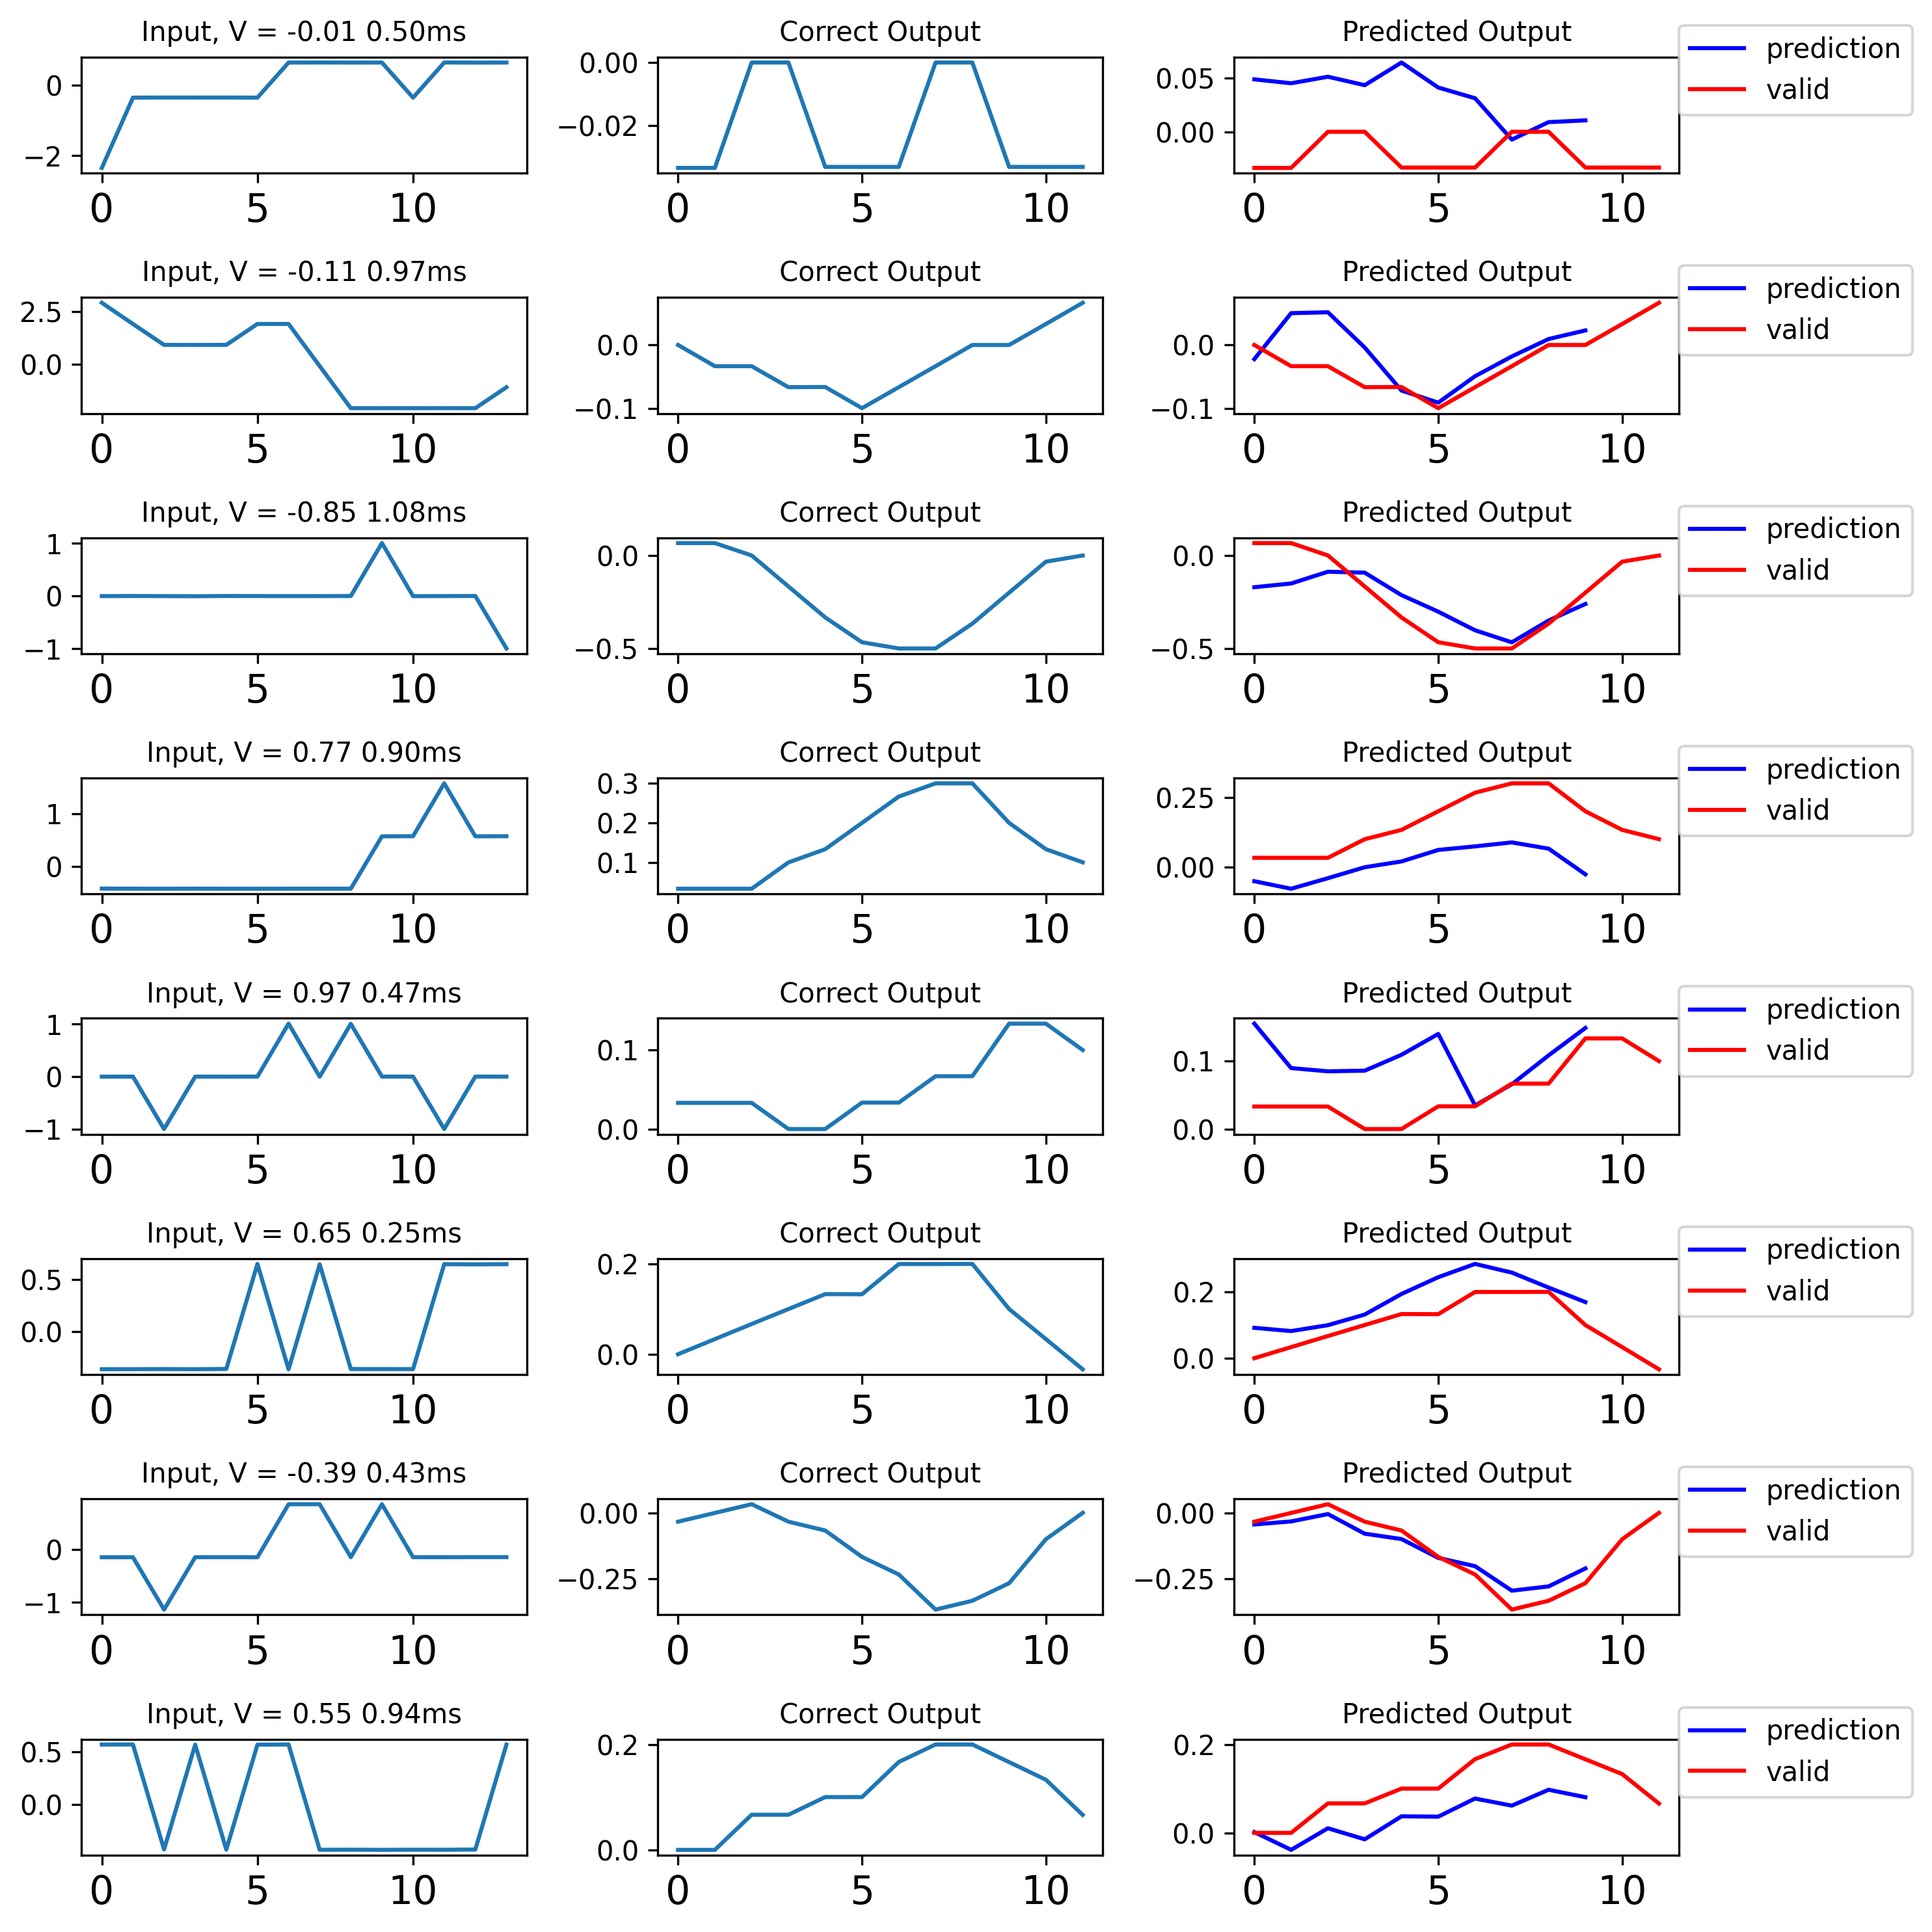

In [25]:
#Let's see what it looks like on one of the validation sets...
font_size = 10
mygen = myGenerator(batch_size = 12, num_batches = 10)

mxtrain, mytrain, mxvalid, myvalid = next(mygen)

predicted_wall = ynet(mxvalid)

fig, axes = plt.subplots(nrows=8, ncols=3, figsize = (10,10))
for row in range(8):
    axes[row,0].plot(mxvalid[0][row,:])
    vval = mxvalid[1][row,0]
    pval = mxvalid[1][row,1]
    
    axes[row,0].set_title('Input, V = {:.2f} {:.2f}ms'.format(vval, pval), fontsize = 10)
    
    axes[row,1].set_title('Correct Output', fontsize = font_size)
    axes[row,1].plot(myvalid[row][:])
    
    axes[row,2].plot(predicted_wall[:,:-2][row], 'b-', label = 'prediction')
    axes[row,2].plot(myvalid[row][:], 'r-', label = 'valid')
    axes[row,2].set_title('Predicted Output', fontsize = font_size)
    axes[row,2].legend(loc = [1.0, 0.5])
    
fig.tight_layout()

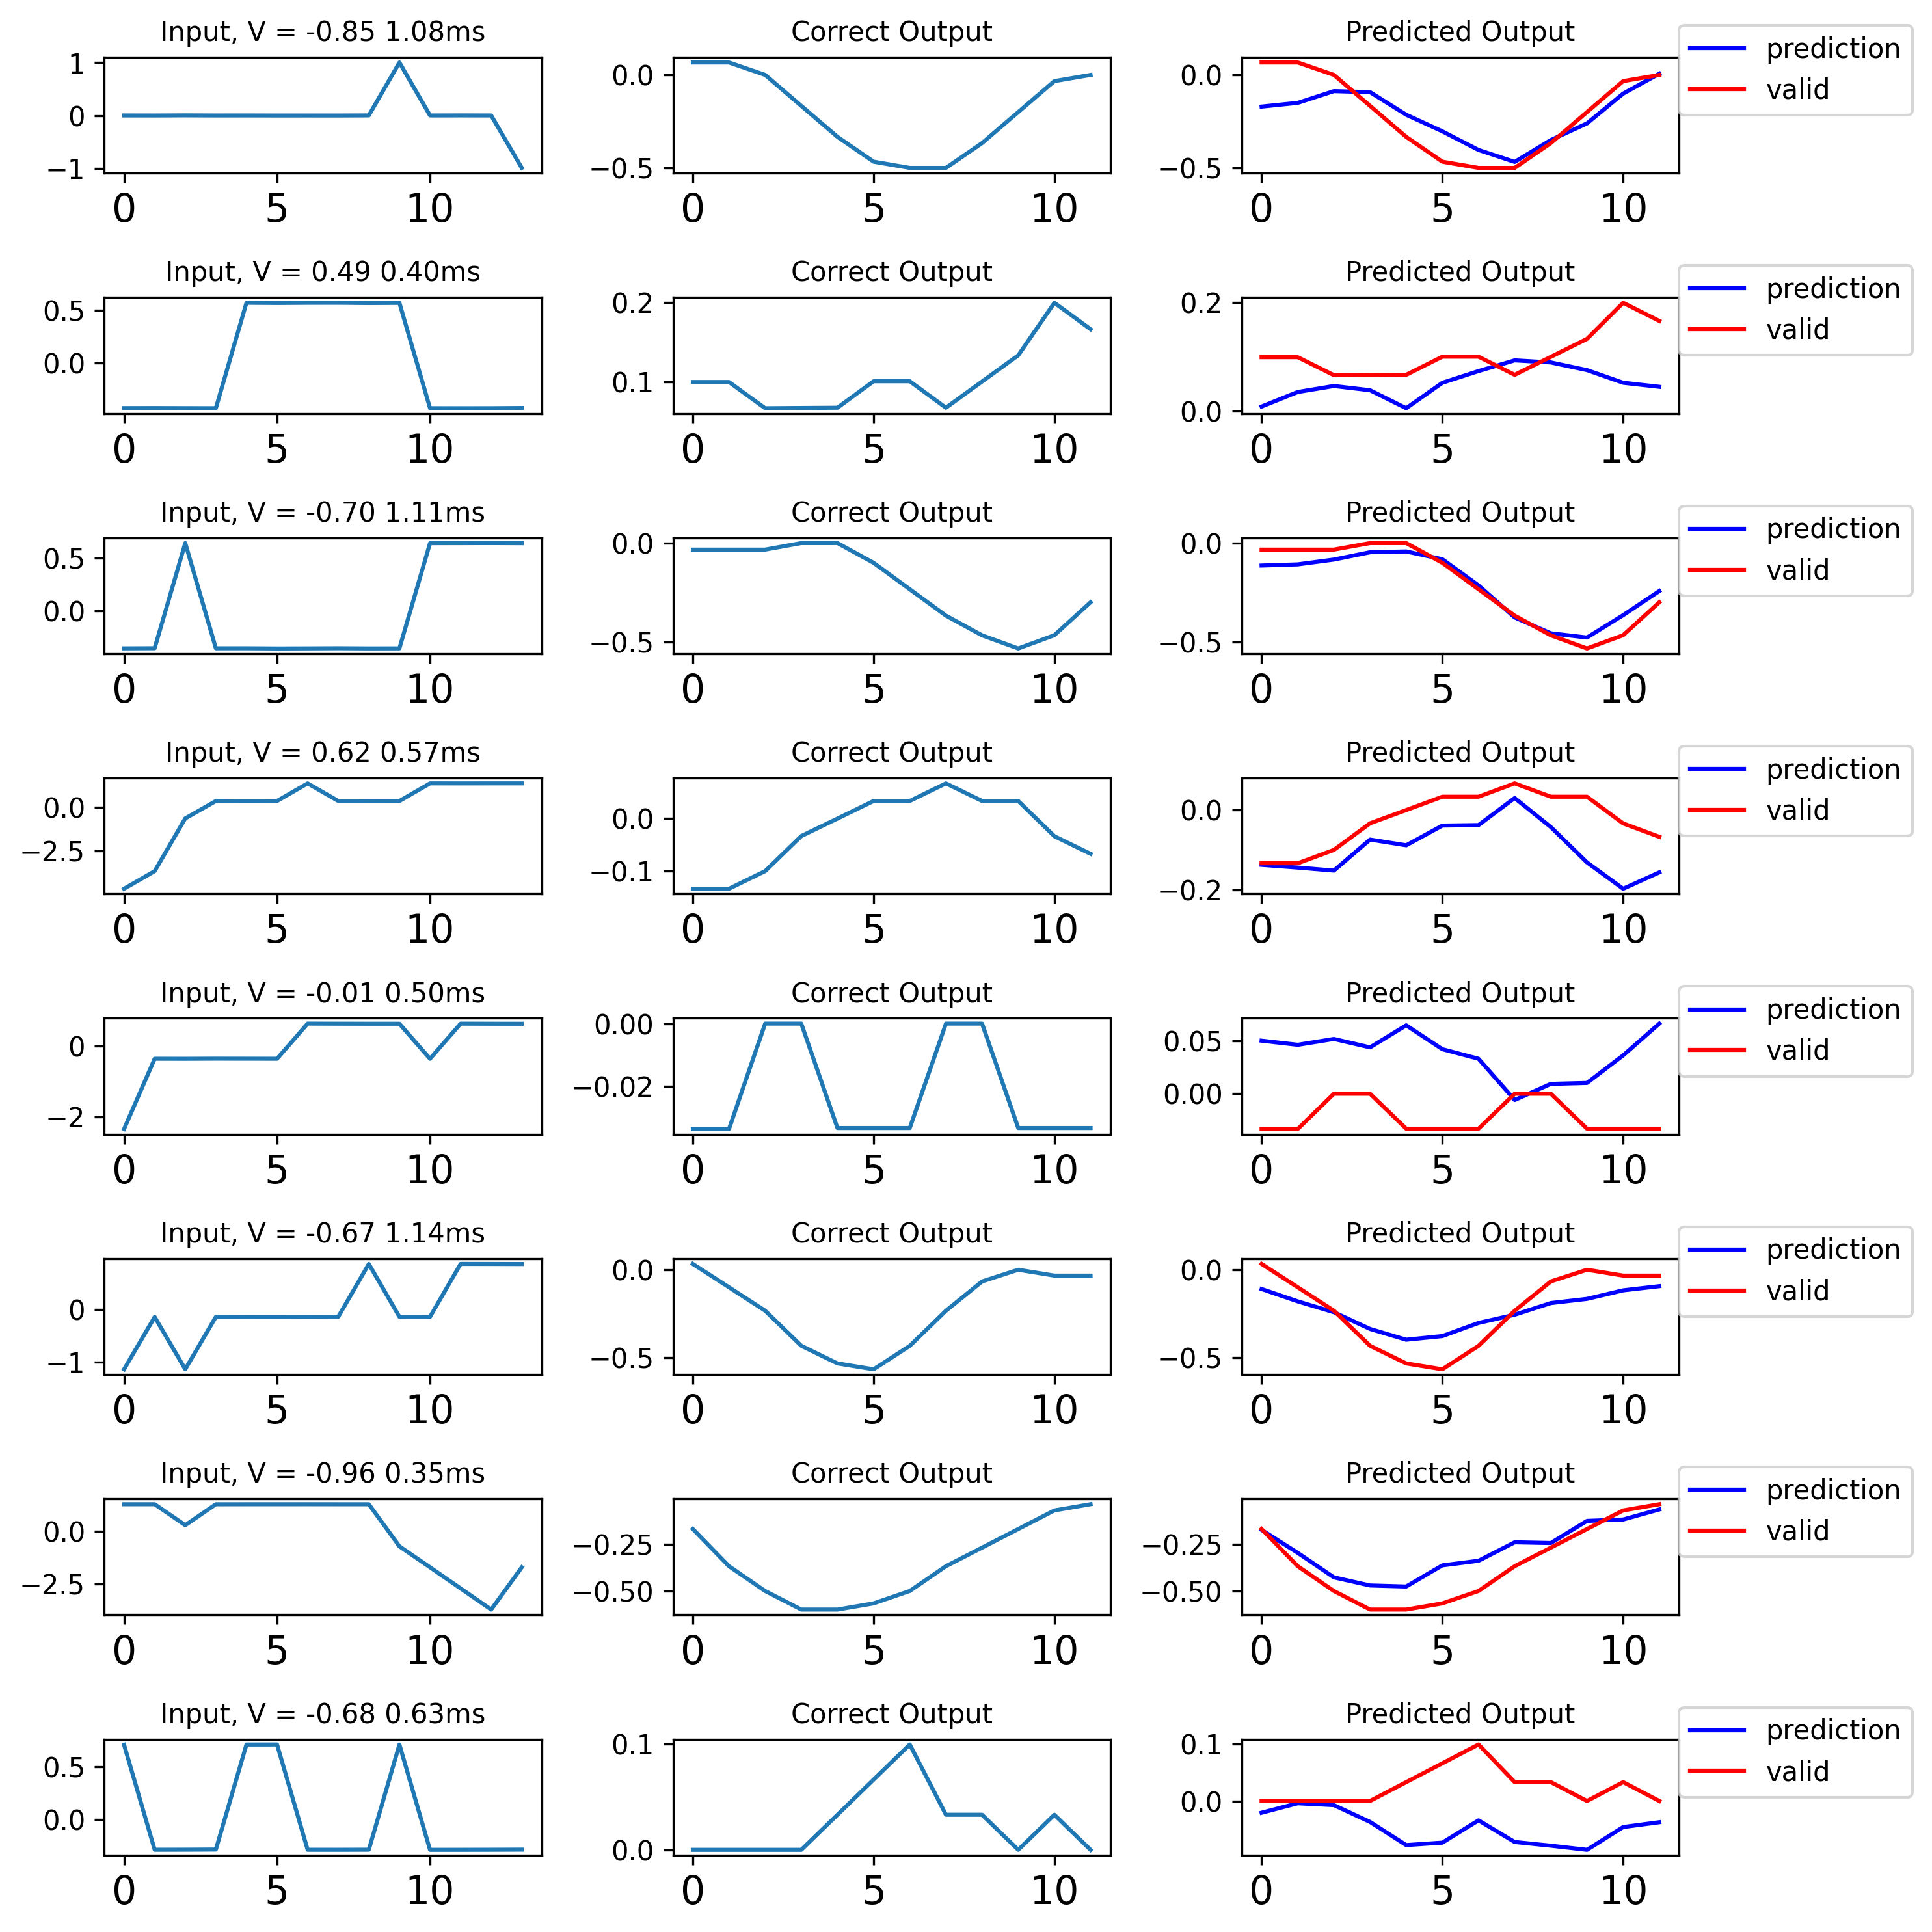

In [26]:
#Let's see what it looks like on one of the validation sets...
font_size = 10
mygen = myGenerator(batch_size = 12, num_batches = 10)

mxtrain, mytrain, mxvalid, myvalid = next(mygen)

predicted_wall = ynet(mxvalid)

fig, axes = plt.subplots(nrows=8, ncols=3, figsize = (10,10))
for row in range(8):
    axes[row,0].plot(mxvalid[0][row,:])
    vval = mxvalid[1][row,0]
    pval = mxvalid[1][row,1]
    
    axes[row,0].set_title('Input, V = {:.2f} {:.2f}ms'.format(vval, pval), fontsize = 10)
    
    axes[row,1].set_title('Correct Output', fontsize = font_size)
    axes[row,1].plot(myvalid[row][:])
    
    axes[row,2].plot(predicted_wall[:,:][row], 'b-', label = 'prediction')
    axes[row,2].plot(myvalid[row][:], 'r-', label = 'valid')
    axes[row,2].set_title('Predicted Output', fontsize = font_size)
    axes[row,2].legend(loc = [1.0, 0.5])
    
fig.tight_layout()

In [27]:
#new data
l=0
bpw = []
bamp = []
for ind in range(1,301): 
    
    bias_amp, bias_pw = all_img_bias[l][1], all_img_bias[l][2]
    l+=1
    bpw.append(bias_pw)
    bamp.append(bias_amp)
    
l=0
actions_new = []
actions_norm_new = []
index_tracker_new =[]

for ind in range(1,301): 
    
     
    xpos,ypos = all_img_bias[l][-2], all_img_bias[l][-1] 
    bias_amp, bias_pw = all_img_bias[l][1], all_img_bias[l][2]
    bias_pw = bias_pw*1000
    
    xpos_norm = xpos/pix
    ypos_norm = ypos/pix
    bias_amp_norm = bias_amp/10
    bias_pw_norm = bias_pw/500
    
    index_tracker.append((ind,l))
    l+=1

    
    actions_new.append([xpos,ypos, bias_amp, bias_pw])
    actions_norm_new.append([xpos_norm, ypos_norm, bias_amp_norm, bias_pw_norm])

phase_images_segmented = np.copy(amp_images_new)
phase_images_segmented = normalize_images(phase_images_segmented)
phase_images_segmented[phase_images_segmented<0.2] = 0
phase_images_segmented[phase_images_segmented>=0.4] = 1


transitions = []
transitions_norm = []
transitions_profiles = []
for ind in range(1, len(phase_images_new)):
    tnew = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_norm = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_prof = namedtuple('Transition', ['state','action', 'next_state'])
    
    tnew.state = phase_images_segmented[ind-1]
    tnew.next_state = phase_images_segmented[ind]
    tnew.action = actions_new[ind]
    
    tnew_norm.state = phase_images_segmented[ind-1]
    tnew_norm.next_state = phase_images_segmented[ind]
    tnew_norm.action = actions_norm_new[ind]
    
    state = tnew.state
    next_state = tnew.next_state
    shift, error, diffphase = phase_cross_correlation(state, next_state,
                                                  upsample_factor=3)
    offset_image = fourier_shift(np.fft.fftn(next_state), shift)
    offset_image = np.fft.ifftn(offset_image)
    next_state = offset_image.real
    wps = return_norm_wall_loc(state, window_size=window_size) + start_pix
    wps_next = return_norm_wall_loc(next_state,window_size=window_size) + start_pix
    
    tnew_prof.state = wps
    tnew_prof.action = tnew_norm.action
    tnew_prof.next_state = wps_next
    
    #if not np.isnan(tnew.action[0]) and not np.isnan(actions[ind+1][0]):
    transitions.append(tnew)
    transitions_norm.append(tnew_norm)
    transitions_profiles.append(tnew_prof)
    
local_win_size = 7
offset=5
local_state_size = 14
train_fraction = 0.80
num_training_points = len(transitions_norm)

train_split_indices = np.random.choice(np.arange(len(transitions_norm)),
                                       (int(num_training_points*train_fraction)),
                                       replace = False)

test_split_indices = [val for val in np.arange(len(transitions_norm)) if val not in train_split_indices]

#Once we have the indices we need to make the training data. X_train, y_train, X_test, y_test
#X_train is the action, state, y_train is the state+1
#Same goes for X_test and y_test
X_train, y_train, X_test, y_test = [], [], [], []

for train_ind in train_split_indices:
    transition = transitions_norm[train_ind]
    trans_profile = transitions_profiles[train_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_train.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_train.append(smooth_window(dprof,window_size=3))

for test_ind in test_split_indices:
    transition = transitions_norm[test_ind]
    trans_profile = transitions_profiles[test_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_test.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_test.append(smooth_window(dprof,window_size=3))
    
def myGenerator(batch_size = 16, num_batches = 32, image_noise = 0.001,action_noise = 0.001):
    batch_num = 0
    while batch_num < num_batches:
        
        train_data_slice = np.random.choice(np.arange(len(X_train)),size = batch_size, replace = False)
        validation_data_slice = np.random.choice(np.arange(len(X_test)),
                                                 size = min(8,batch_size), replace = False)
        
        xtrain = [X_train[int(val)] for val in train_data_slice]
        ytrain = [y_train[int(val)] for val in train_data_slice]
        
        xtest = [X_test[int(val)] for val in validation_data_slice]
        ytest = [y_test[int(val)] for val in validation_data_slice]
        
        #Convert to tensorflow arrays - training data
        xtrain_images = np.zeros(shape=(batch_size, xtrain[0][0].shape[0]))
        for ind in range(len(train_data_slice)): 
            xtrain_images[ind,:] = xtrain[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtrain[ind][0])))                  
        xtrain_images = tf.stack(xtrain_images)
        
        xtrain_actions = np.zeros(shape=(batch_size, len(xtrain[0][1])))
        #print(xtrain_actions[ind,:], xtrain[1][1])
        for ind in range(len(train_data_slice)): 
            xtrain_actions[ind,:] = xtrain[ind][1]
            
        xtrain_actions = tf.stack(xtrain_actions)
        xtrain = [xtrain_images[:,:,None], xtrain_actions]
        
        #Convert to tensorflow arrays - testing data
        xtest_images = np.zeros(shape=((len(xtest)), xtest[0][0].shape[0]))
        for ind in range(len(validation_data_slice)): 
            xtest_images[ind,:] = xtest[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtest[ind][0])))                    
        xtest_images = tf.stack(xtest_images)
        
        xtest_actions = np.zeros(shape=(len(xtest), len(xtest[0][1])))
        for ind in range(len(validation_data_slice)): 
            #xtest_actions[ind,:] = xtest[ind][1] + np.random.normal(loc=0.0, scale = action_noise,size=(6))
            xtest_actions[ind,:] = xtest[ind][1] + np.random.normal(loc=0.0, scale = action_noise,size=(2))
            
        xtest_actions = tf.stack(xtest_actions)
        
        xtest = [xtest_images[:,:,None], xtest_actions]
        
        yield xtrain, tf.stack(ytrain), xtest, tf.stack(ytest)
        batch_num+=1    


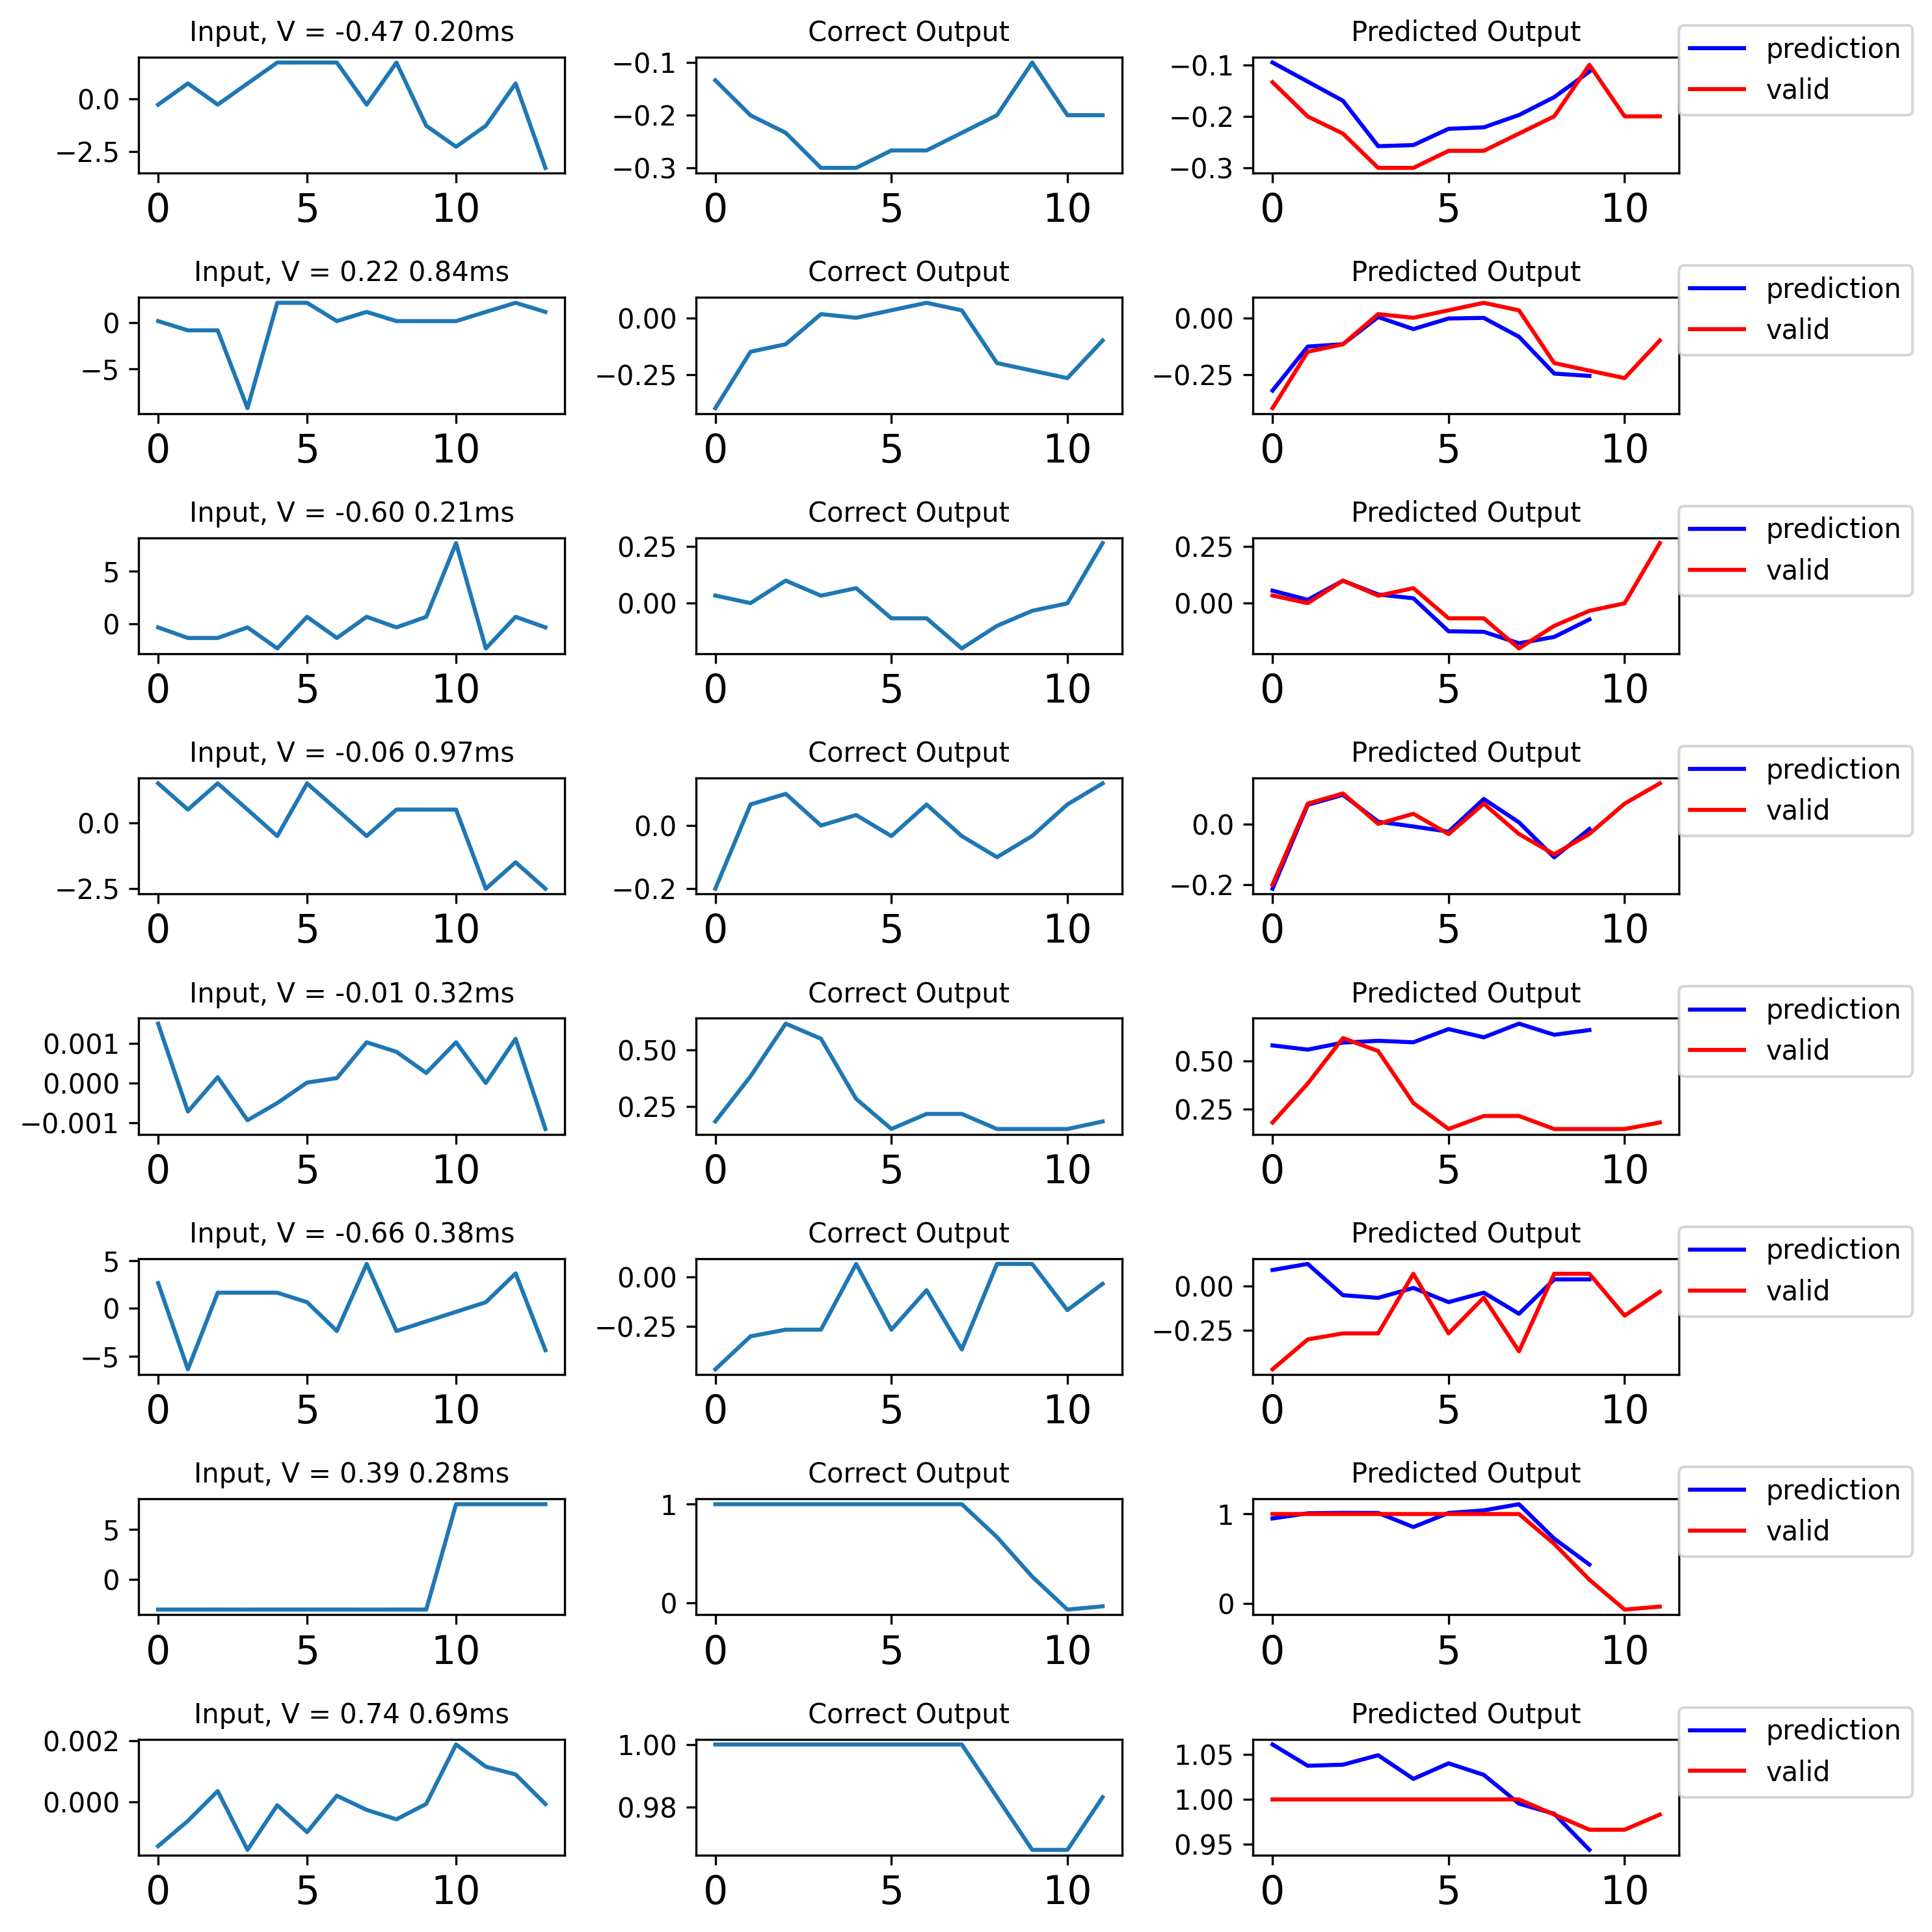

In [28]:
#Let's see what it looks like on one of the validation sets...
font_size = 10
mygen = myGenerator(batch_size = 12, num_batches = 10)

mxtrain, mytrain, mxvalid, myvalid = next(mygen)

predicted_wall = ynet(mxvalid)

fig, axes = plt.subplots(nrows=8, ncols=3, figsize = (10,10))
for row in range(8):
    axes[row,0].plot(mxvalid[0][row,:])
    vval = mxvalid[1][row,0]
    pval = mxvalid[1][row,1]
    
    axes[row,0].set_title('Input, V = {:.2f} {:.2f}ms'.format(vval, pval), fontsize = 10)
    
    axes[row,1].set_title('Correct Output', fontsize = font_size)
    axes[row,1].plot(myvalid[row][:])
    
    axes[row,2].plot(predicted_wall[:,:-2][row], 'b-', label = 'prediction')
    axes[row,2].plot(myvalid[row][:], 'r-', label = 'valid')
    axes[row,2].set_title('Predicted Output', fontsize = font_size)
    axes[row,2].legend(loc = [1.0, 0.5])
    
fig.tight_layout()

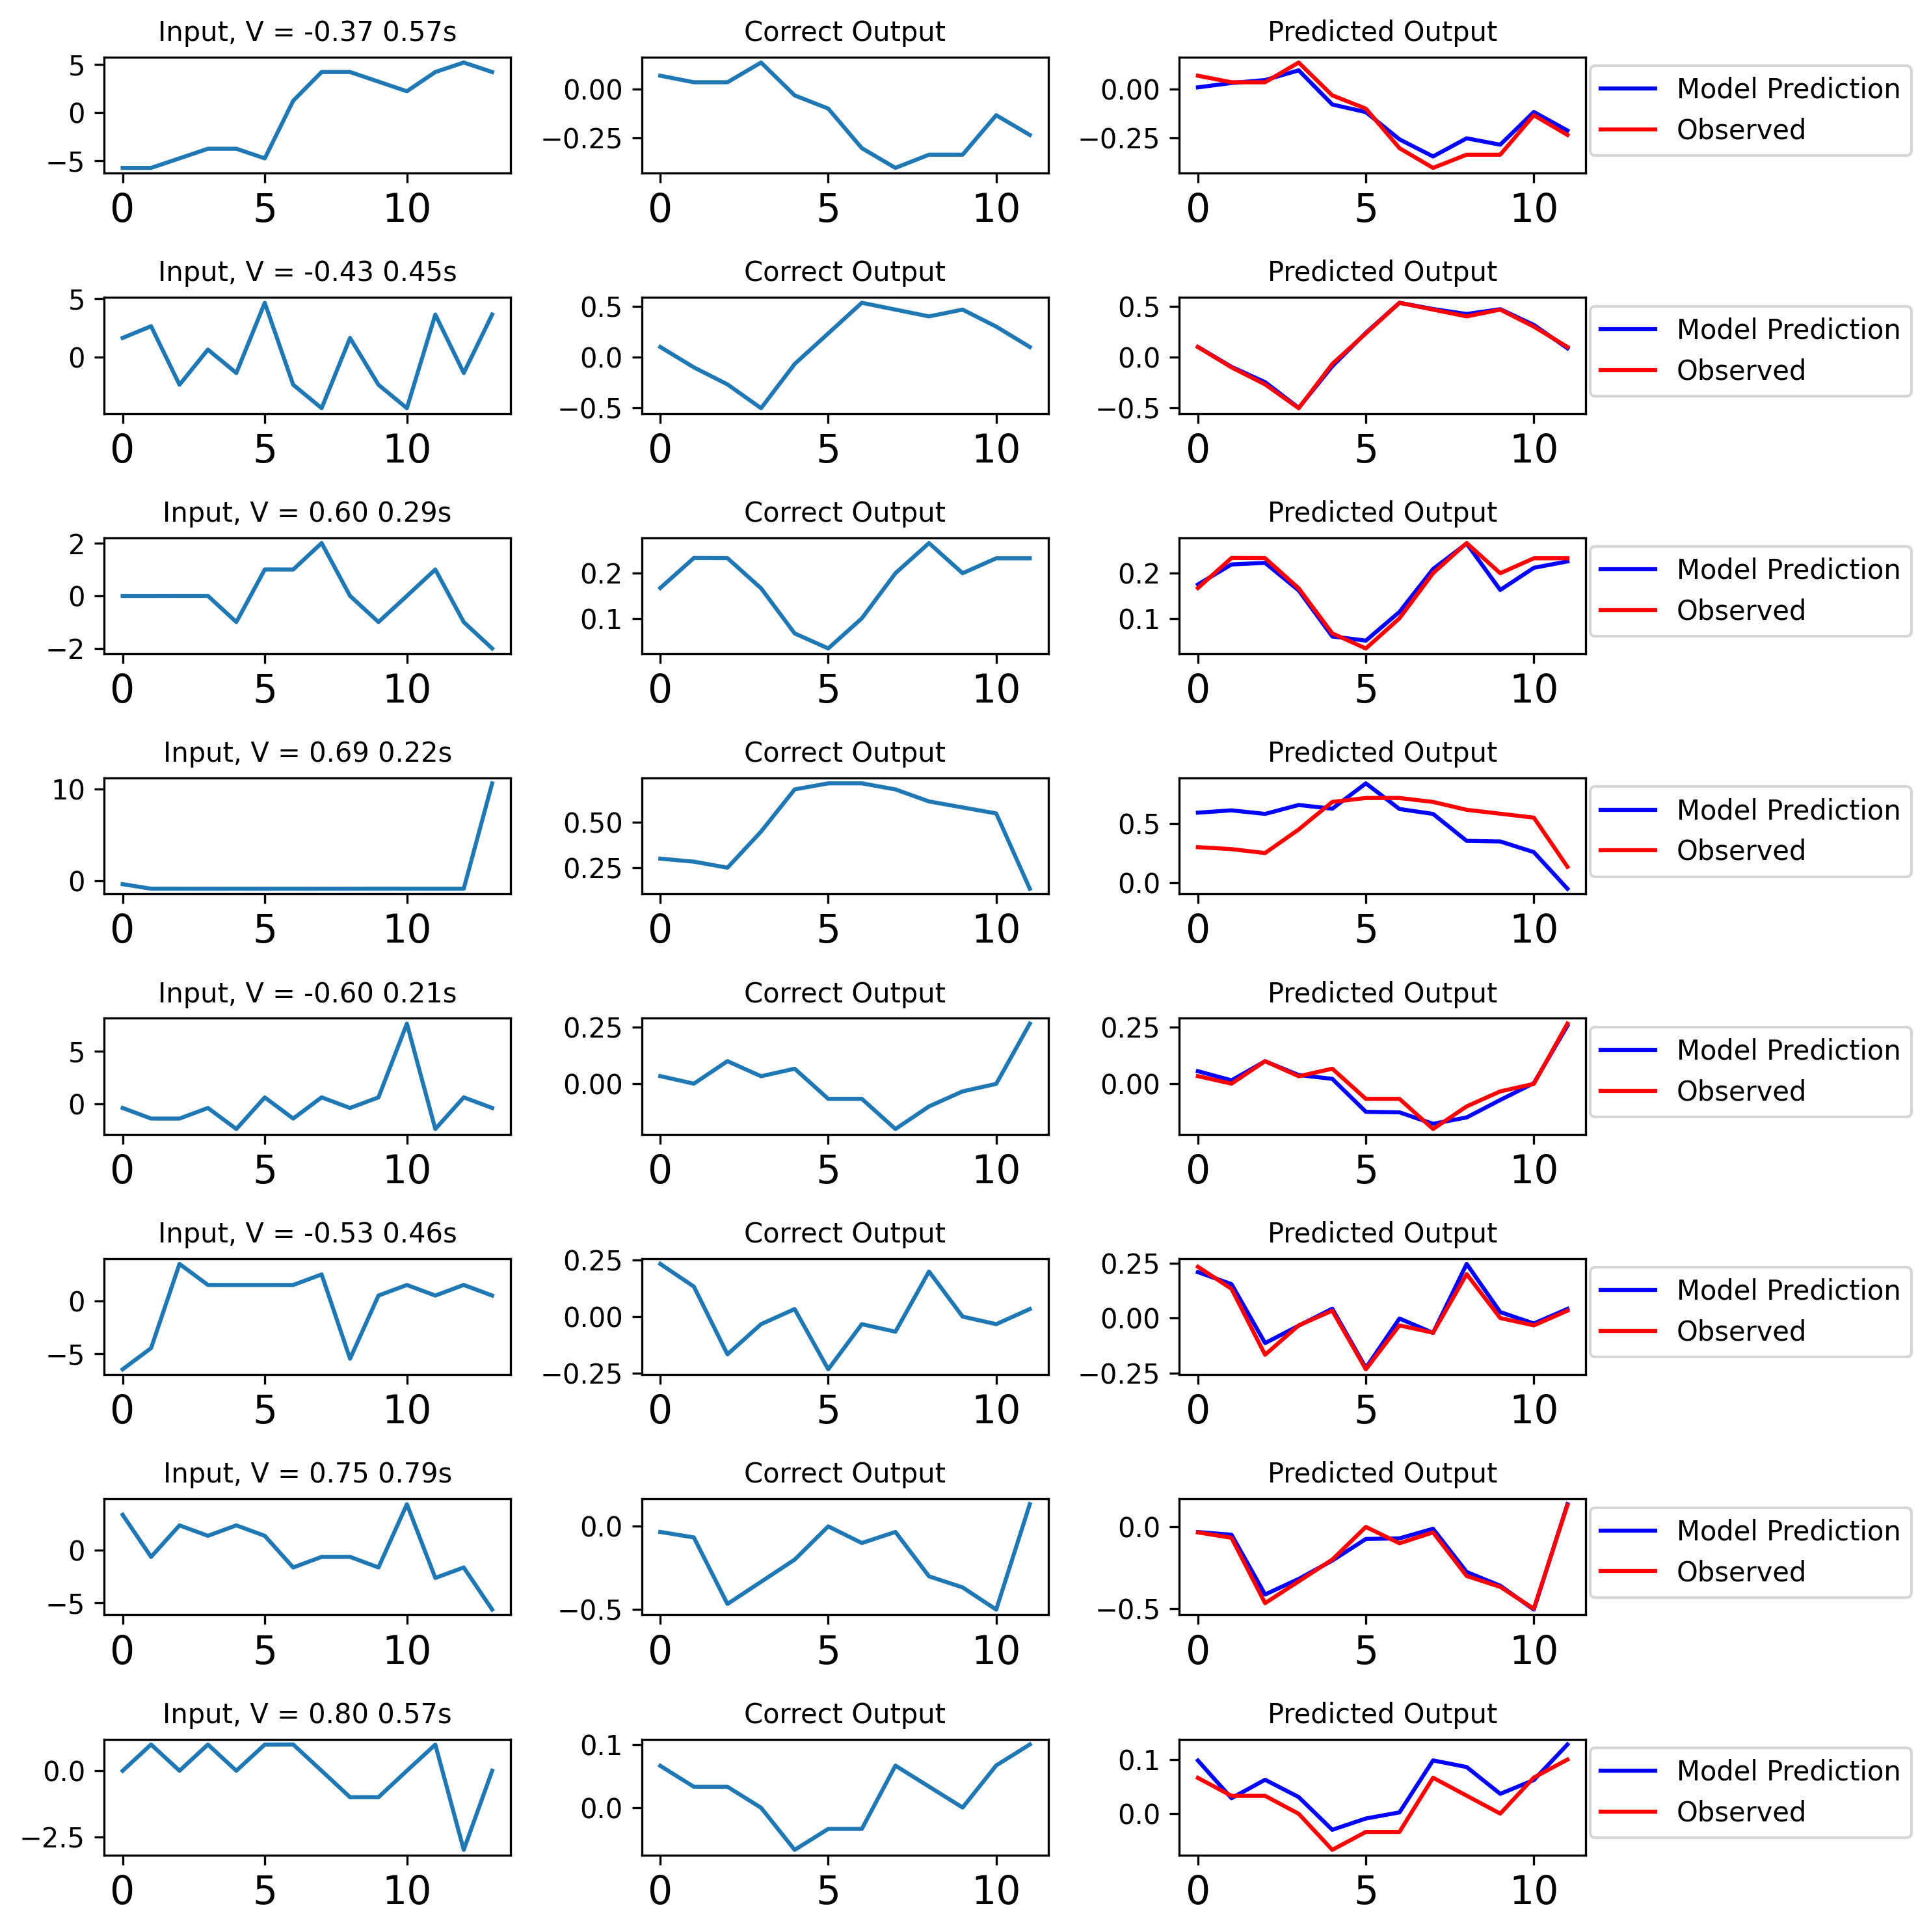

In [29]:
#Let's see what it looks like on one of the validation sets...
font_size = 10
mygen = myGenerator(batch_size = 12, num_batches = 10)

mxtrain, mytrain, mxvalid, myvalid = next(mygen)

predicted_wall = ynet(mxvalid)

fig, axes = plt.subplots(nrows=8, ncols=3, figsize = (10,10))
for row in range(8):
    axes[row,0].plot(mxvalid[0][row,:])
    vval = mxvalid[1][row,0]
    pval = mxvalid[1][row,1]
    
    axes[row,0].set_title('Input, V = {:.2f} {:.2f}s'.format(vval, pval), fontsize = 10)
    
    axes[row,1].set_title('Correct Output', fontsize = font_size)
    axes[row,1].plot(myvalid[row][:])
    
    axes[row,2].plot(predicted_wall[:,:][row], 'b-', label = 'Model Prediction')
    axes[row,2].plot(myvalid[row][:], 'r-', label = 'Observed')
    axes[row,2].set_title('Predicted Output', fontsize = font_size)
    axes[row,2].legend(loc = [1.01, 0.15])
    
fig.tight_layout()

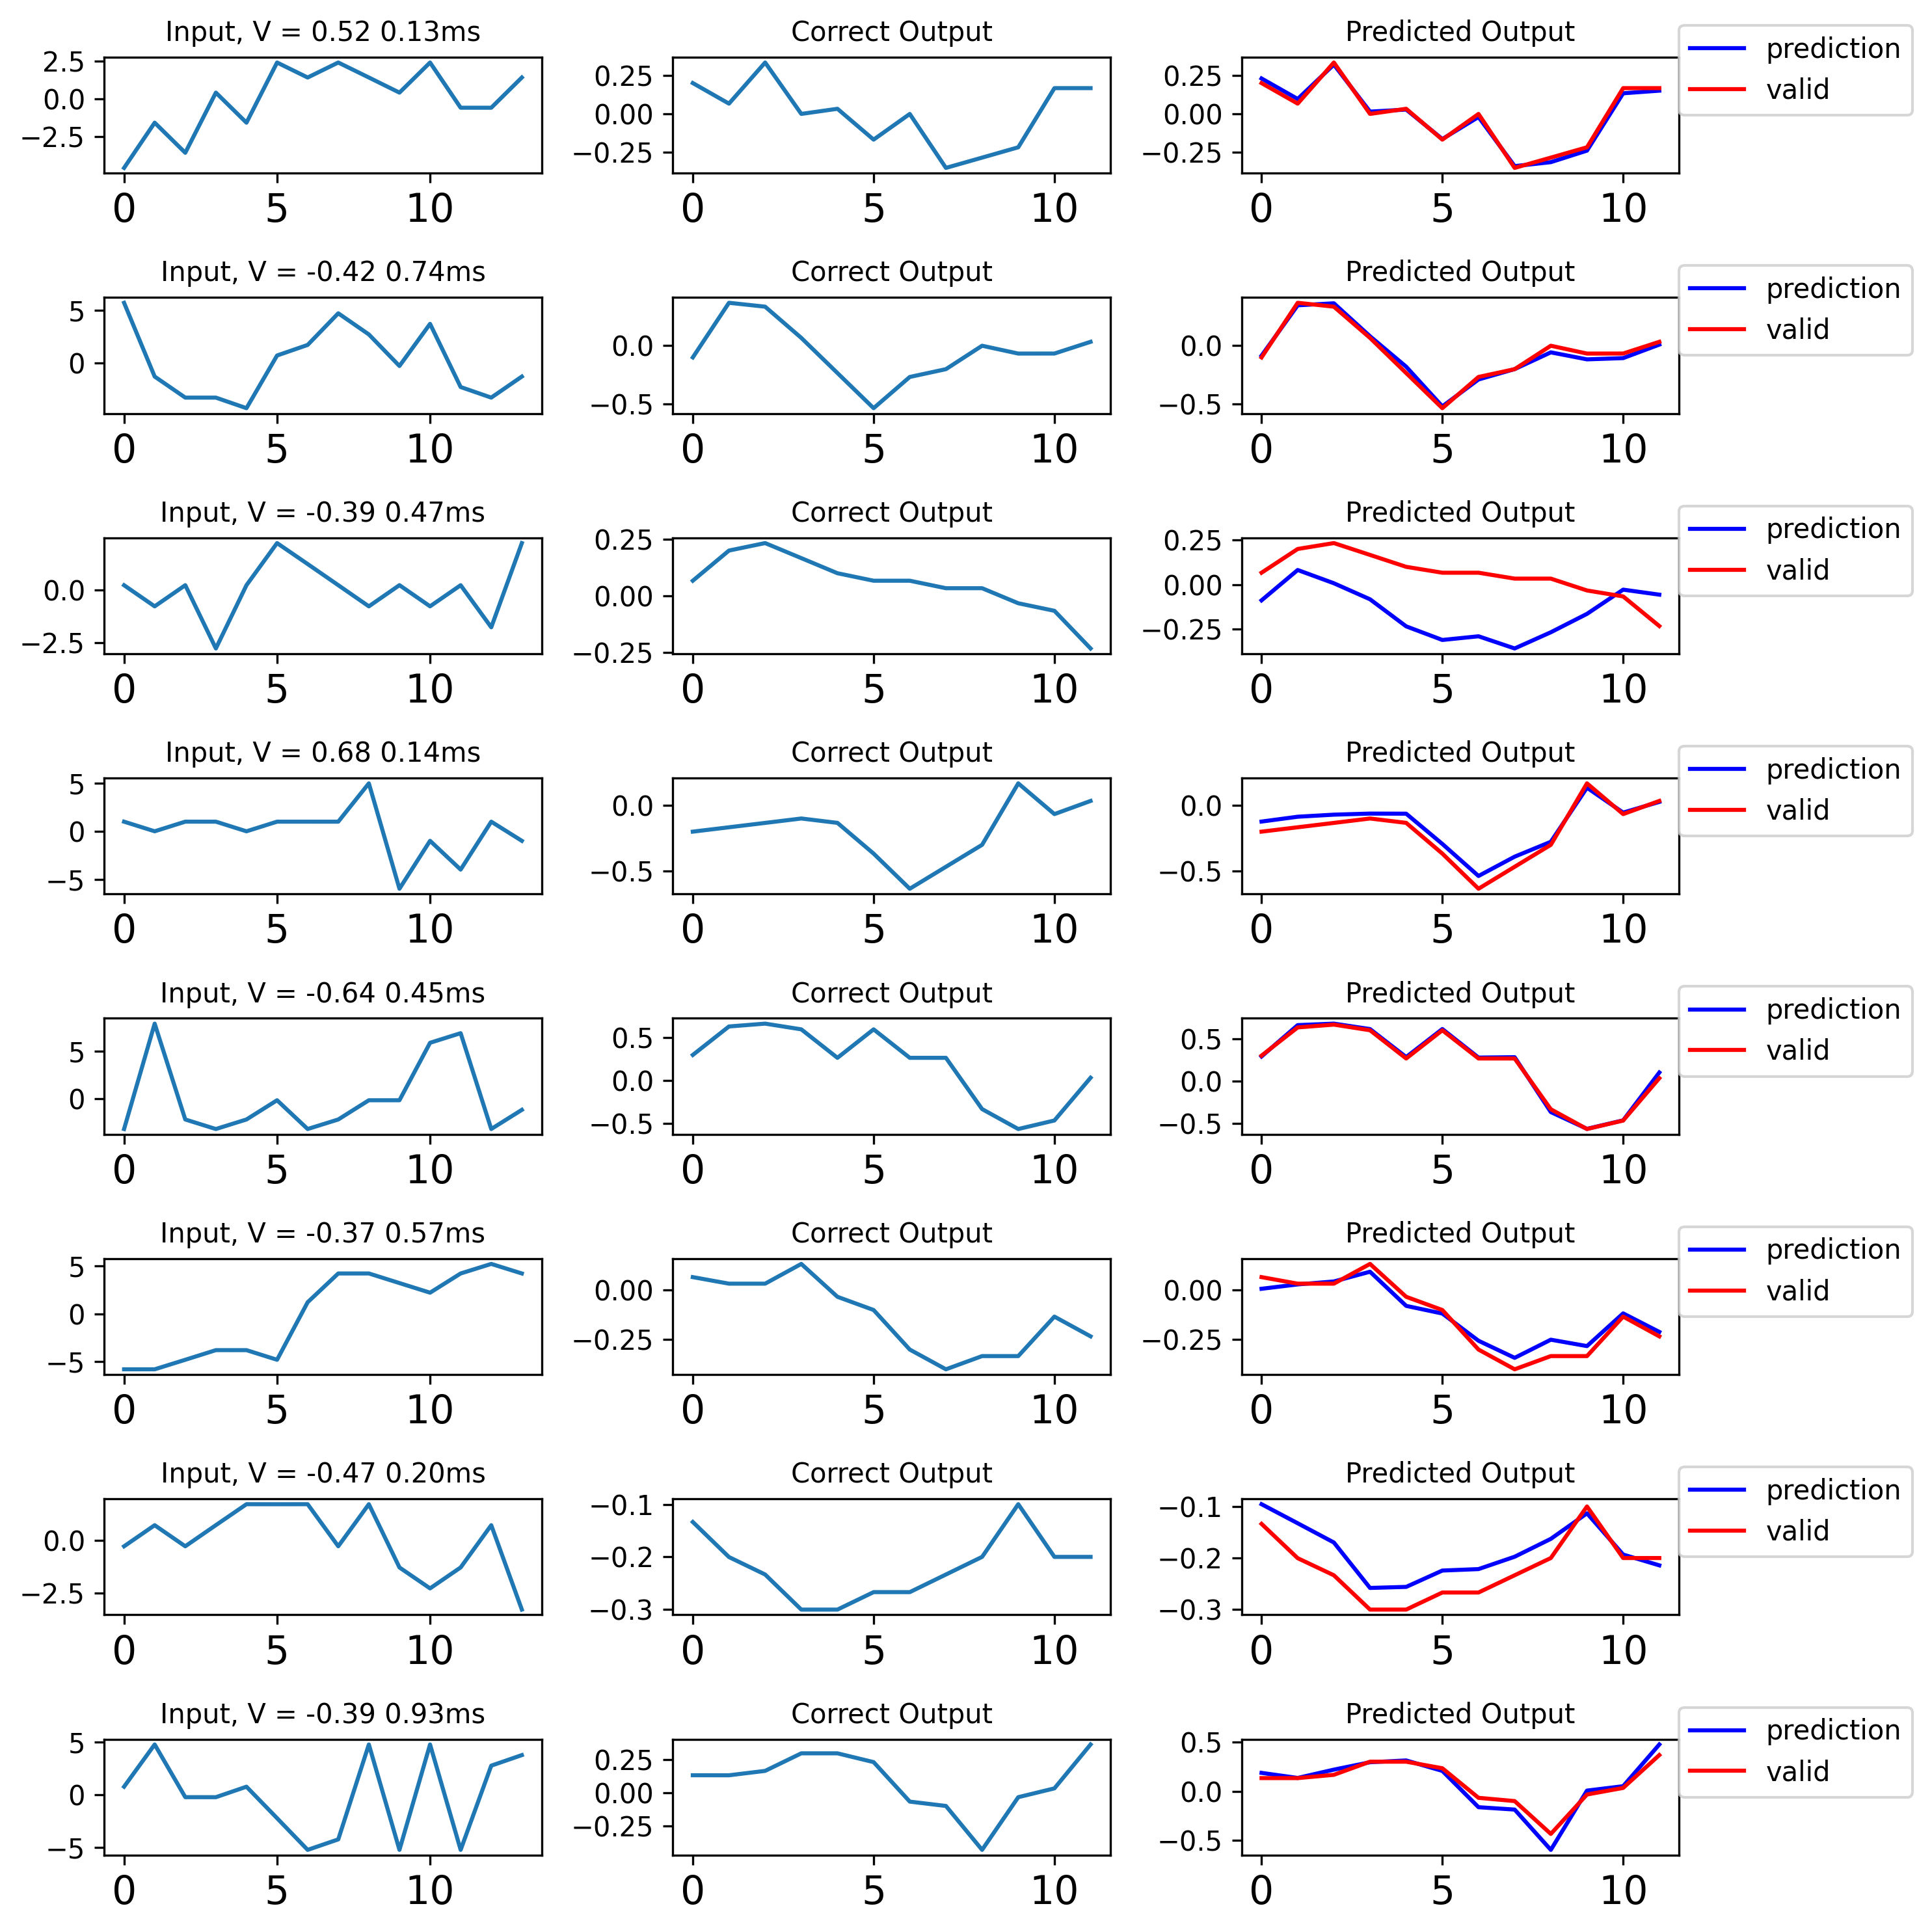

In [30]:
#Let's see what it looks like on one of the validation sets...
font_size = 10
mygen = myGenerator(batch_size = 12, num_batches = 10)

mxtrain, mytrain, mxvalid, myvalid = next(mygen)

predicted_wall = ynet(mxvalid)

fig, axes = plt.subplots(nrows=8, ncols=3, figsize = (10,10))
for row in range(8):
    axes[row,0].plot(mxvalid[0][row,:])
    vval = mxvalid[1][row,0]
    pval = mxvalid[1][row,1]
    
    axes[row,0].set_title('Input, V = {:.2f} {:.2f}ms'.format(vval, pval), fontsize = 10)
    
    axes[row,1].set_title('Correct Output', fontsize = font_size)
    axes[row,1].plot(myvalid[row][:])
    
    axes[row,2].plot(predicted_wall[:,:][row], 'b-', label = 'prediction')
    axes[row,2].plot(myvalid[row][:], 'r-', label = 'valid')
    axes[row,2].set_title('Predicted Output', fontsize = font_size)
    axes[row,2].legend(loc = [1.0, 0.5])
    
fig.tight_layout()

# Wall profiles as function of V and PW

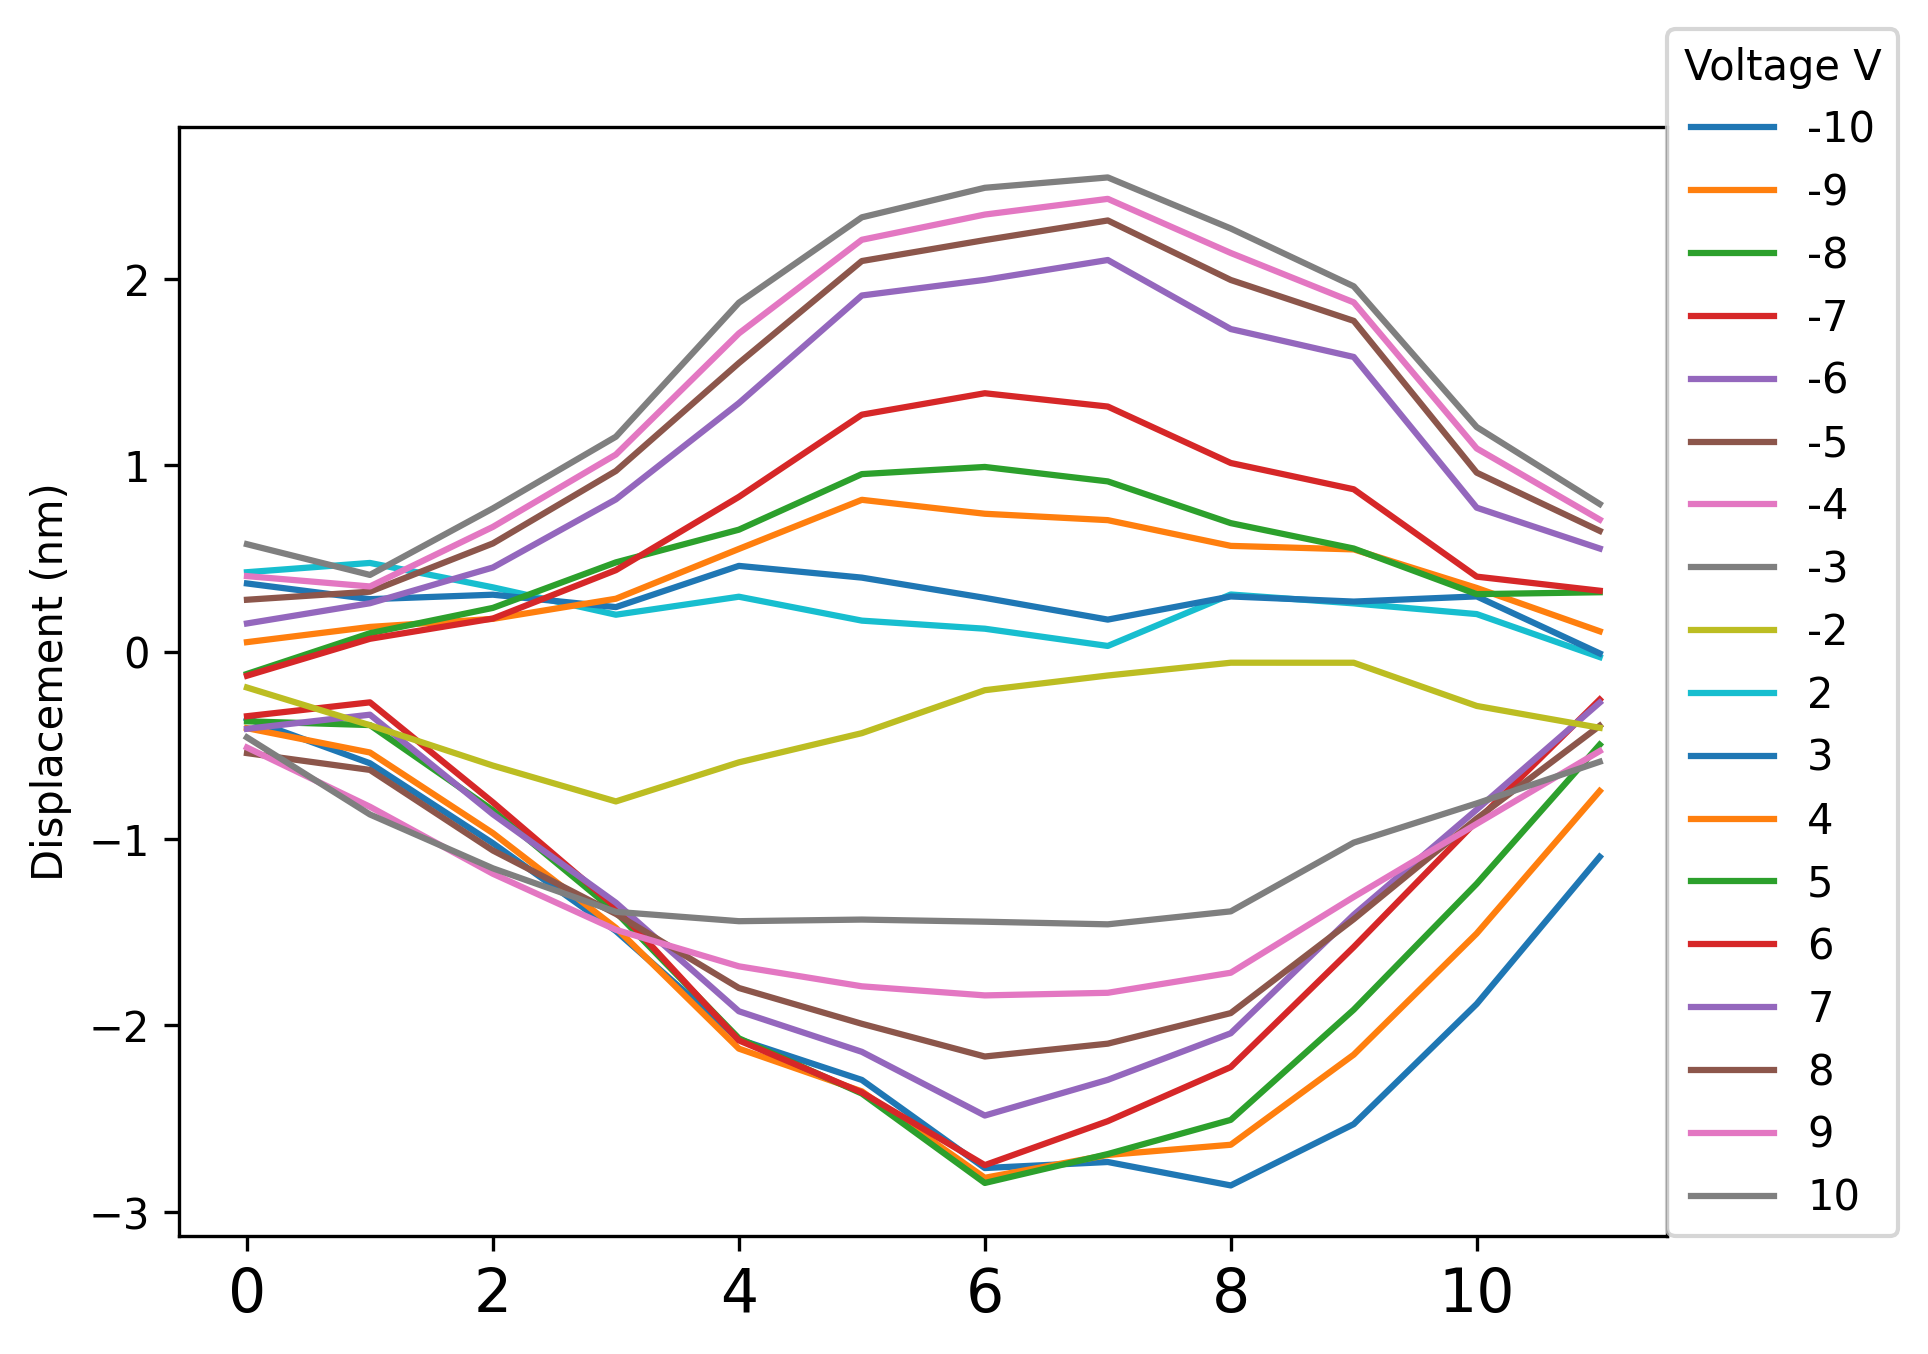

In [31]:


outputs = []
test_images, test_actions = [], []

#test_image = mxvalid[0][1]
test_image = np.full(14,-0.1)
#test_image = row

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    #for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=0.5    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])

        test_images.append(test_image)

test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
df = df*7.8125
#maxValues = df.abs().max(axis = 1)
#maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*500
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(df, left_index=True, right_index=True)

labels = [-10,-9,-8,-7,-6,-5,-4,-3,-2,2,3,4,5,6,7,8,9,10]
for i in range(18):
    plt.plot(df.T[i], label=labels[i])
    plt.legend(loc=(1,0), title='Voltage V')
    plt.ylabel("Displacement (nm)")

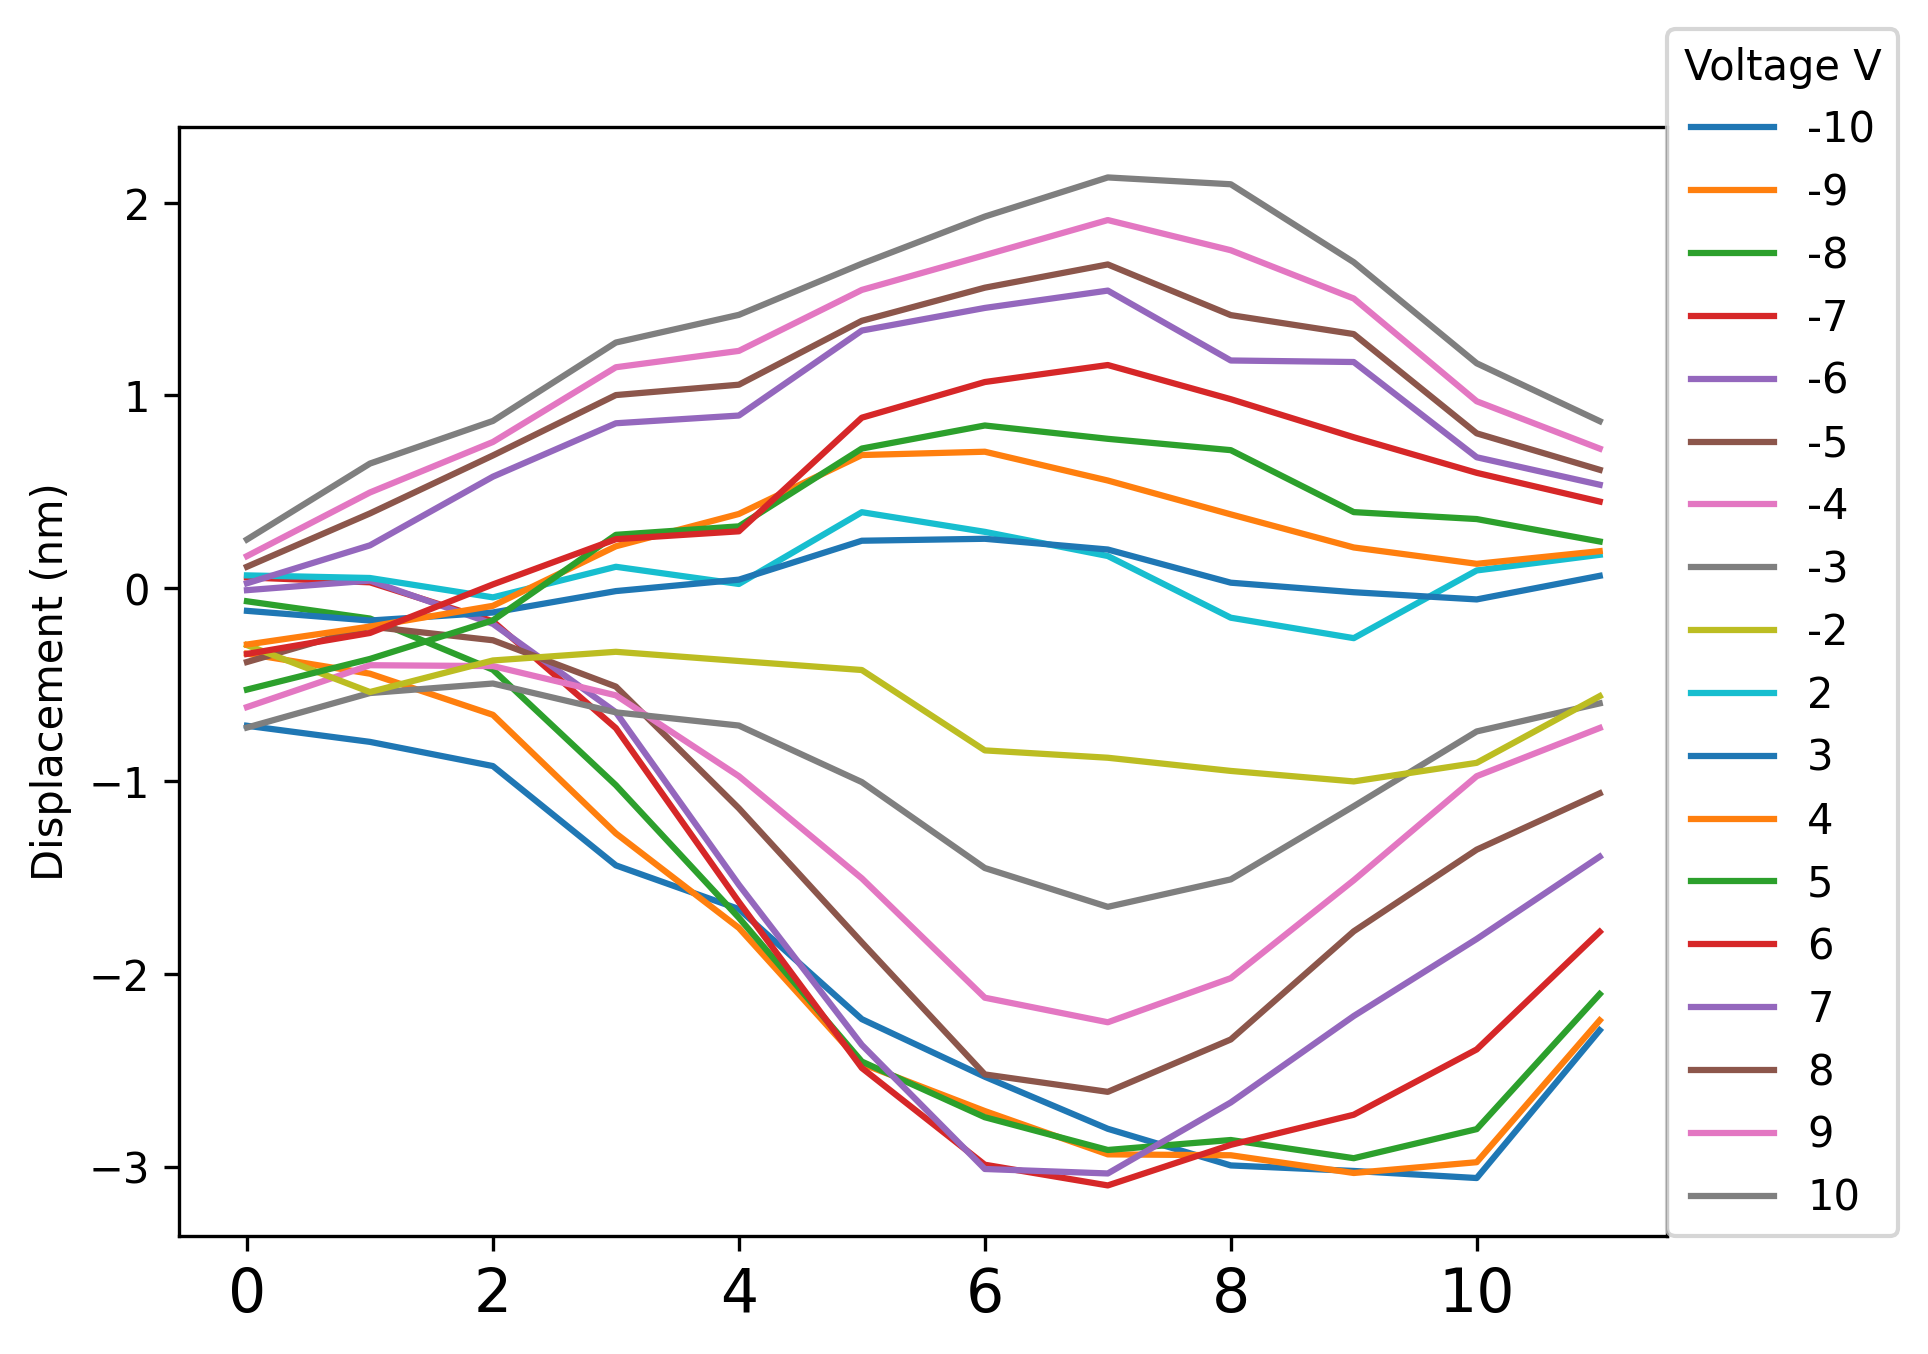

In [32]:


outputs = []
test_images, test_actions = [], []

#test_image = mxvalid[0][1]
test_image = np.full(14,0.5)
#test_image = row

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    #for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=0.5    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])

        test_images.append(test_image)

test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
df = df*7.8125
#maxValues = df.abs().max(axis = 1)
#maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*500
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(df, left_index=True, right_index=True)

labels = [-10,-9,-8,-7,-6,-5,-4,-3,-2,2,3,4,5,6,7,8,9,10]
for i in range(18):
    plt.plot(df.T[i], label=labels[i])
    plt.legend(loc=(1,0), title='Voltage V')
    plt.ylabel("Displacement (nm)")

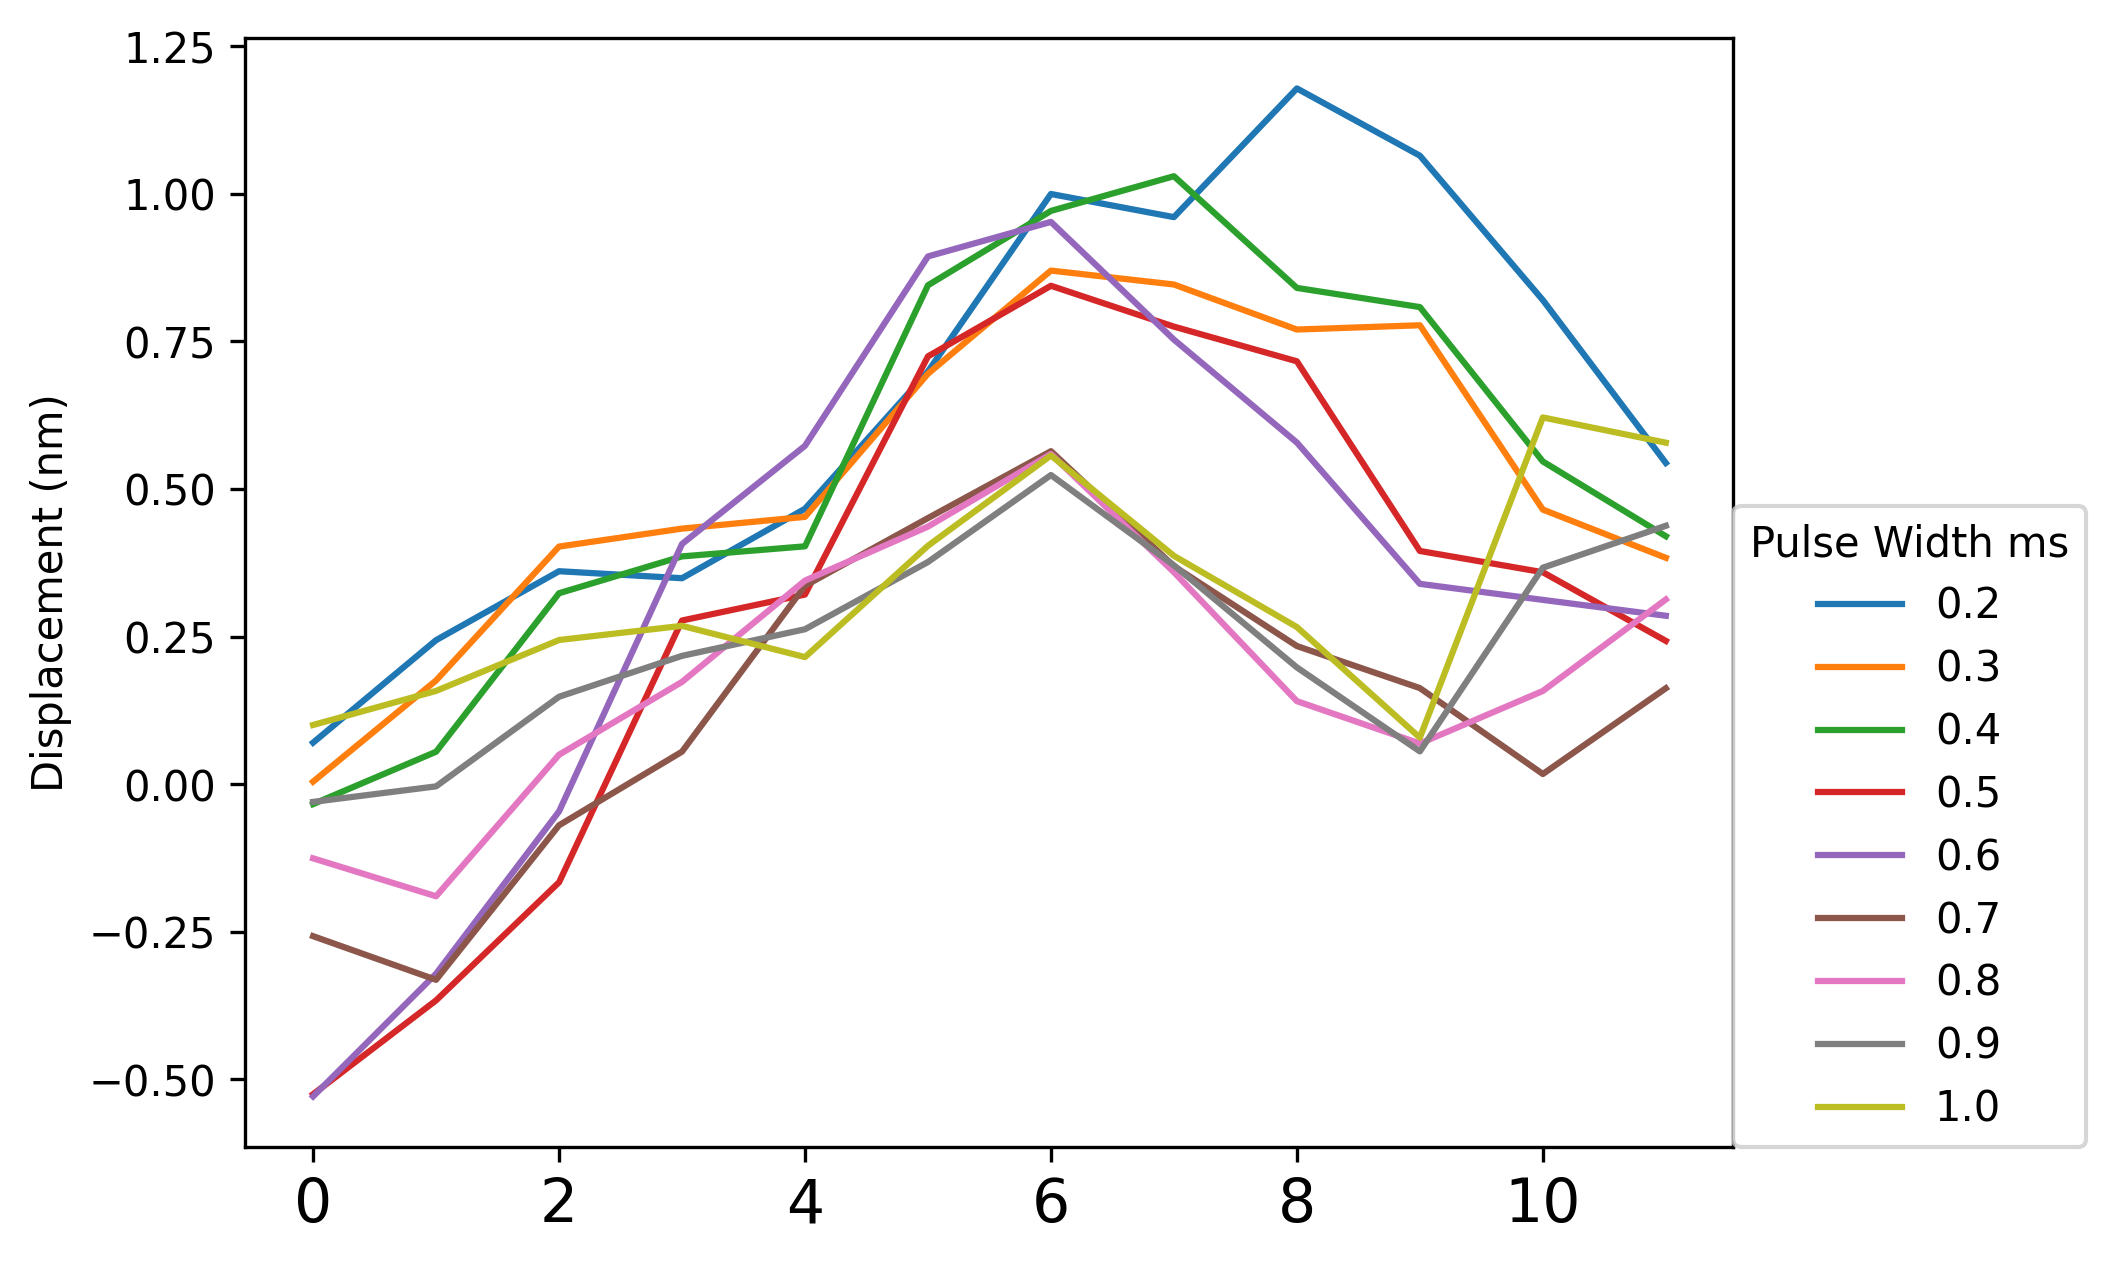

In [33]:


outputs = []
test_images, test_actions = [], []

#test_image = mxvalid[0][1]
test_image = np.full(14,0.5)
#test_image = row

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


#for v in voltages:

for p in pwidths:
    test_action_val_new_valv=0.5
    test_action_val_new_valp=p    
    test_actions.append([test_action_val_new_valv, test_action_val_new_valp])

    test_images.append(test_image)

test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
df = df*7.8125
#maxValues = df.abs().max(axis = 1)
#maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*500
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(df, left_index=True, right_index=True)

labels = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
labels=labels*500
for i in range(9):
    plt.plot(df.T[i], label=labels[i])
    plt.legend(loc=(1,0), title='Pulse Width ms')
    plt.ylabel("Displacement (nm)")

    

arr = np.trapz((df.T-df.T.min()))

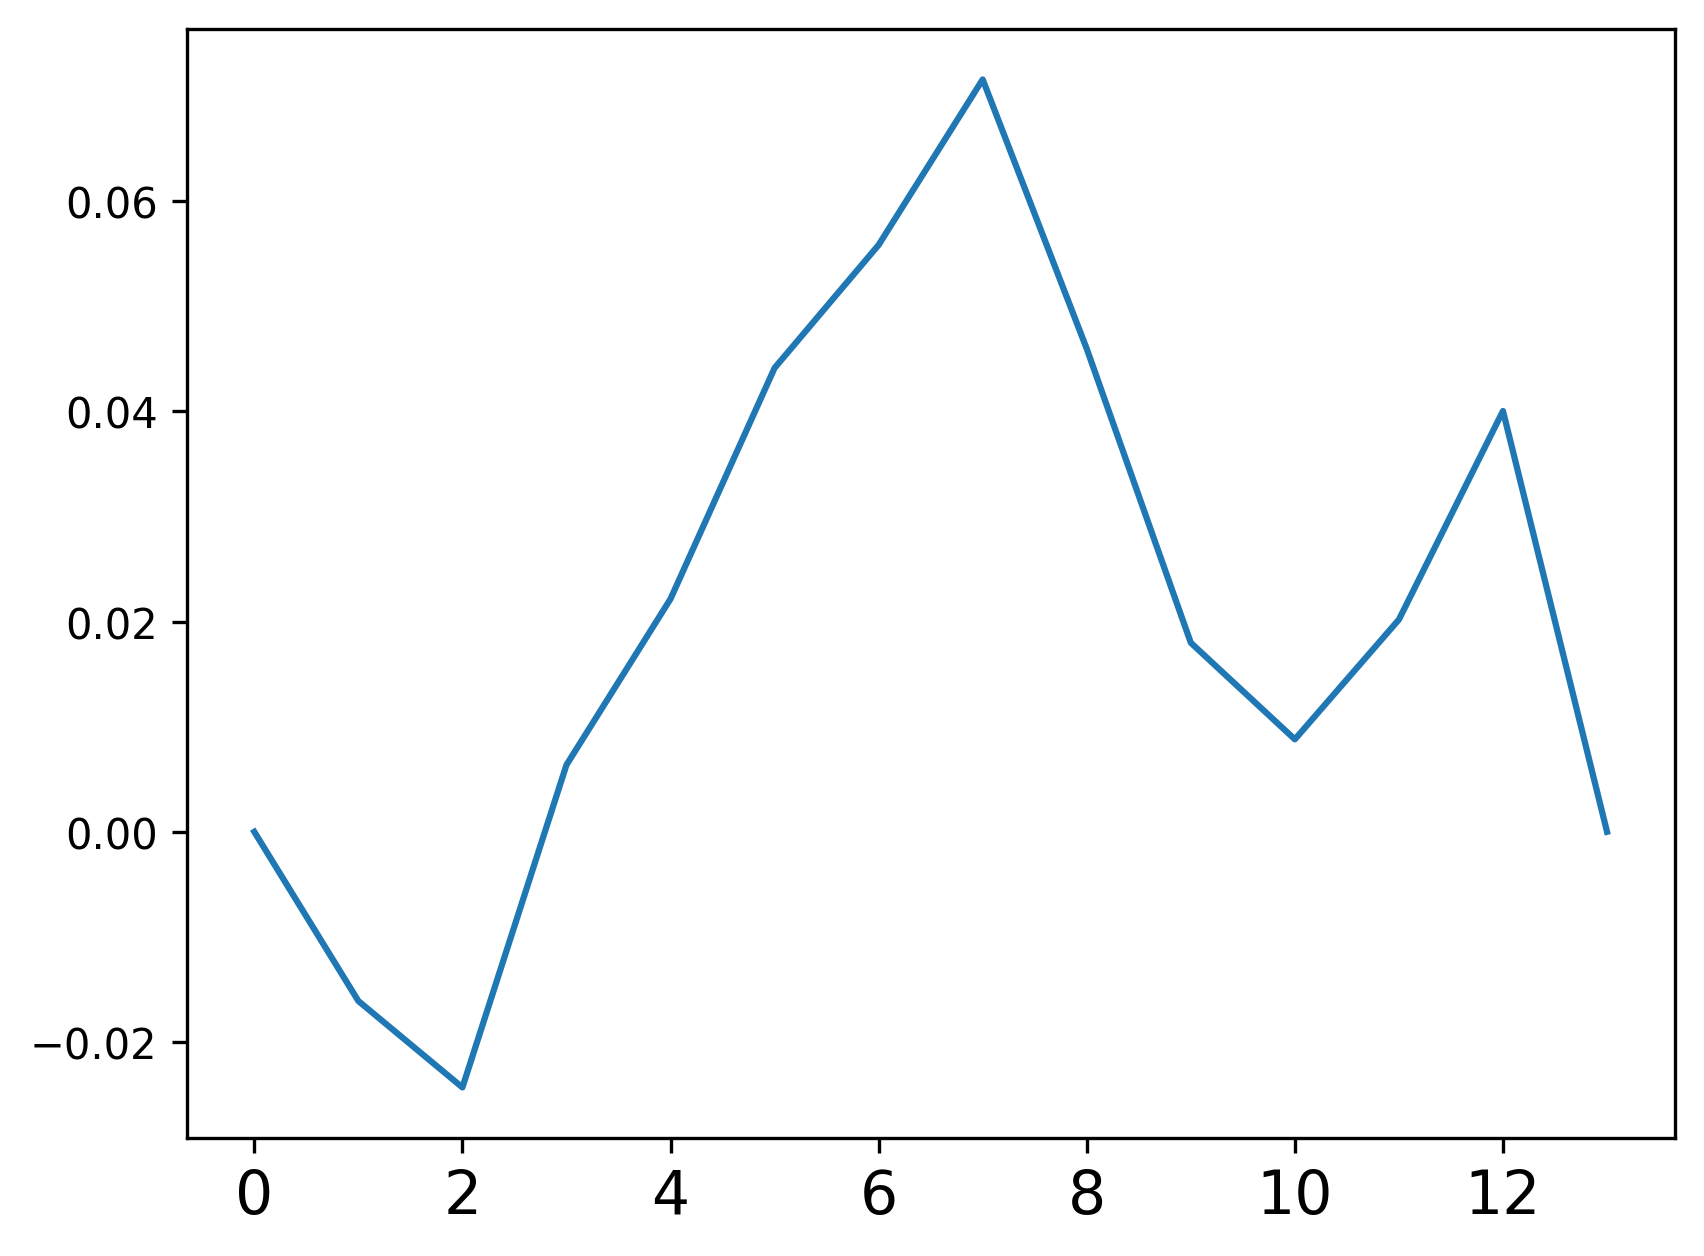

In [34]:
out = np.array(output[6])
out = np.pad(out, pad_width=1)
plt.plot(out)

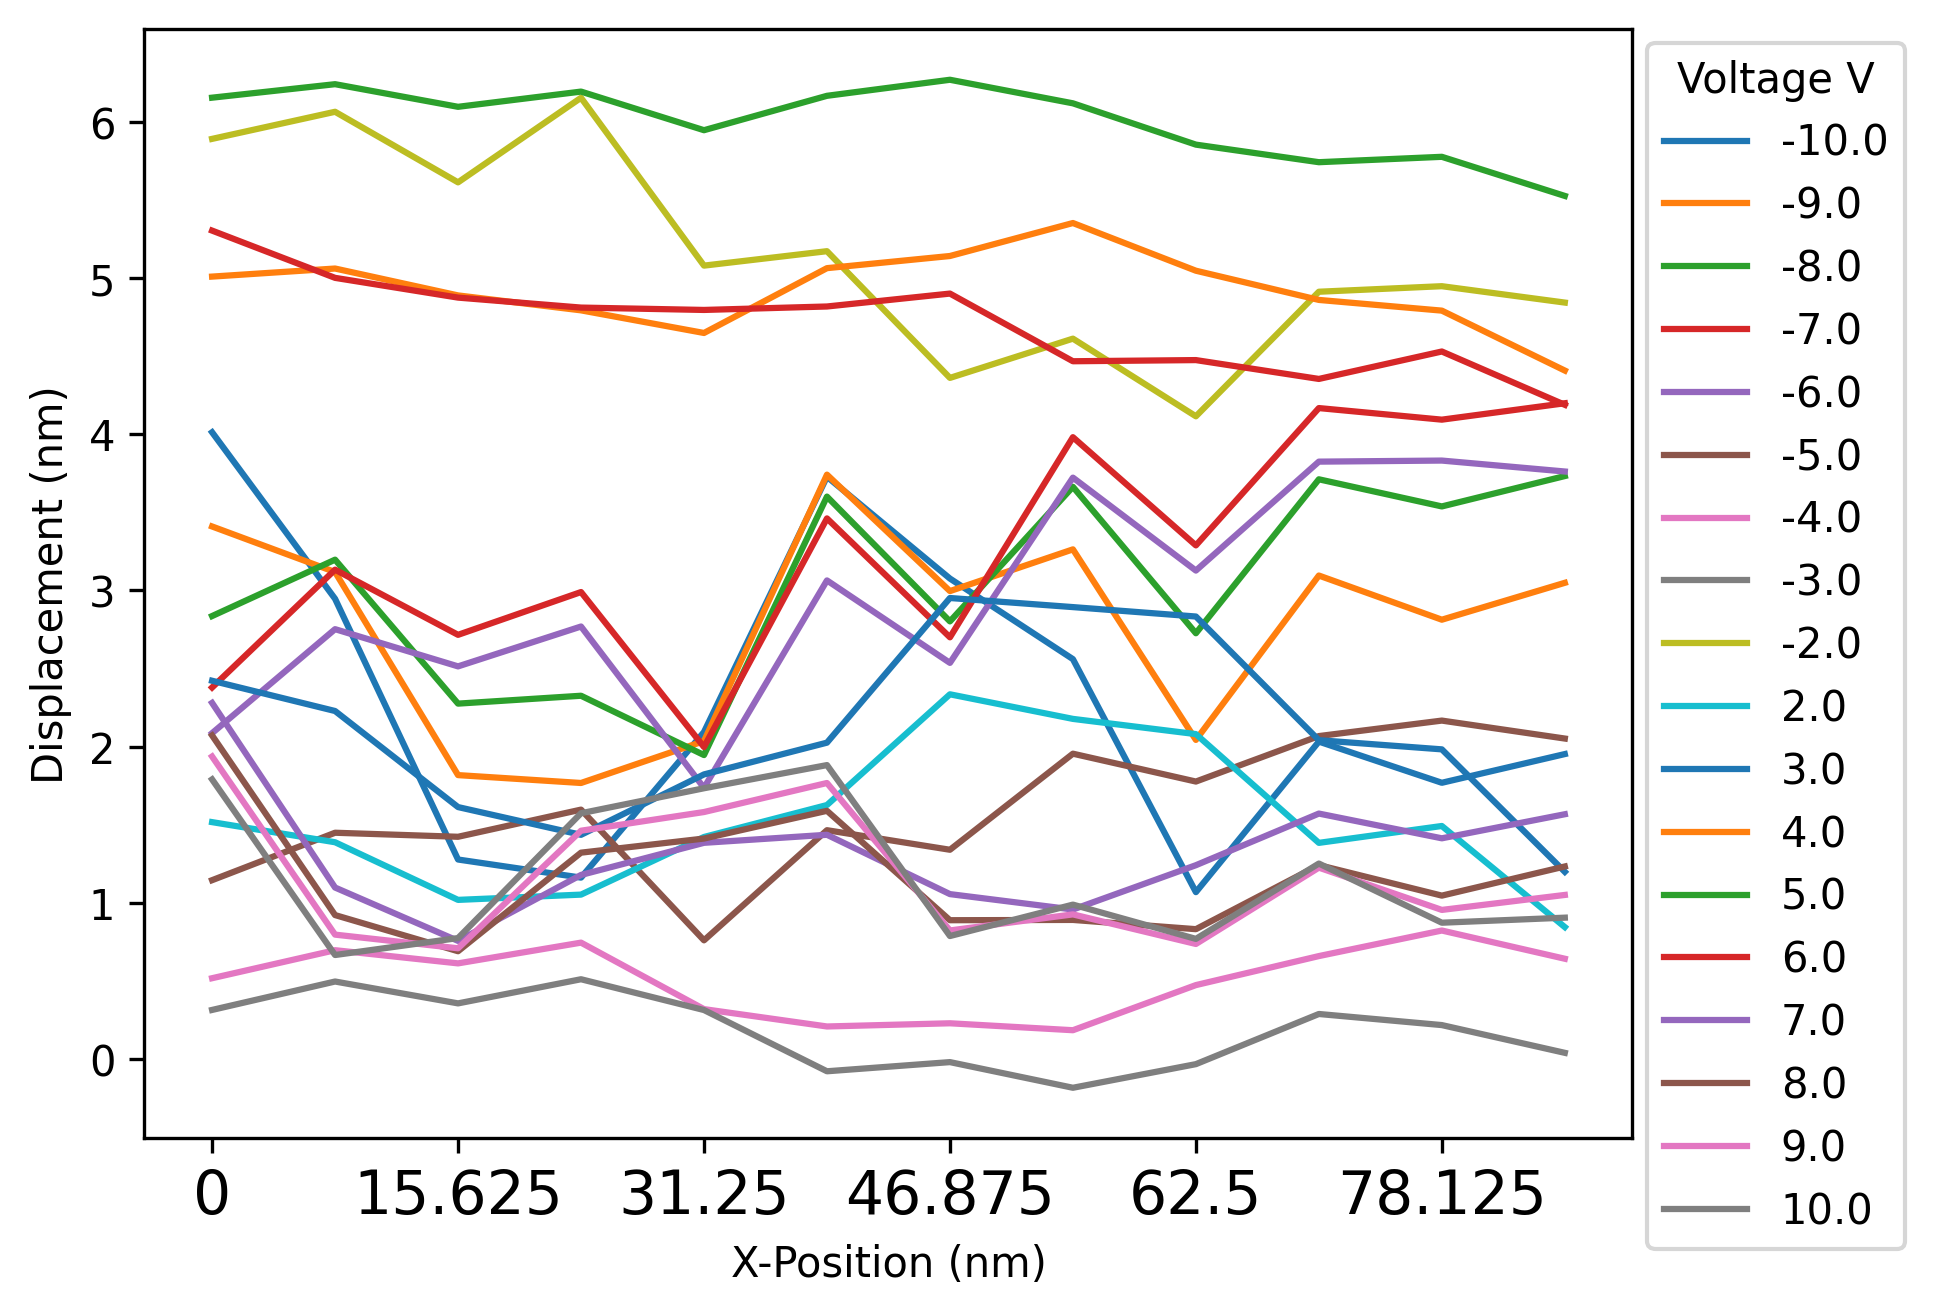

In [35]:


outputs = []
test_images, test_actions = [], []

#test_image = mxvalid[0][1]
#test_image = np.full(14,0.5)
test_image = out

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    #for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=0.5    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])

        test_images.append(test_image)

test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
df = df*7.8125
#maxValues = df.abs().max(axis = 1)
#maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*500
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(df, left_index=True, right_index=True)

labels = [-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
for i in range(18):
    plt.plot(df.T[i], label=labels[i])
    plt.legend(loc=(1.01,-0.1), title='Voltage V')
    plt.ylabel("Displacement (nm)")
    plt.xticks([0,2,4,6,8,10],[0,2*7.8125,4*7.8125,6*7.8125,8*7.8125,10*7.8125])
    plt.xlabel("X-Position (nm)")


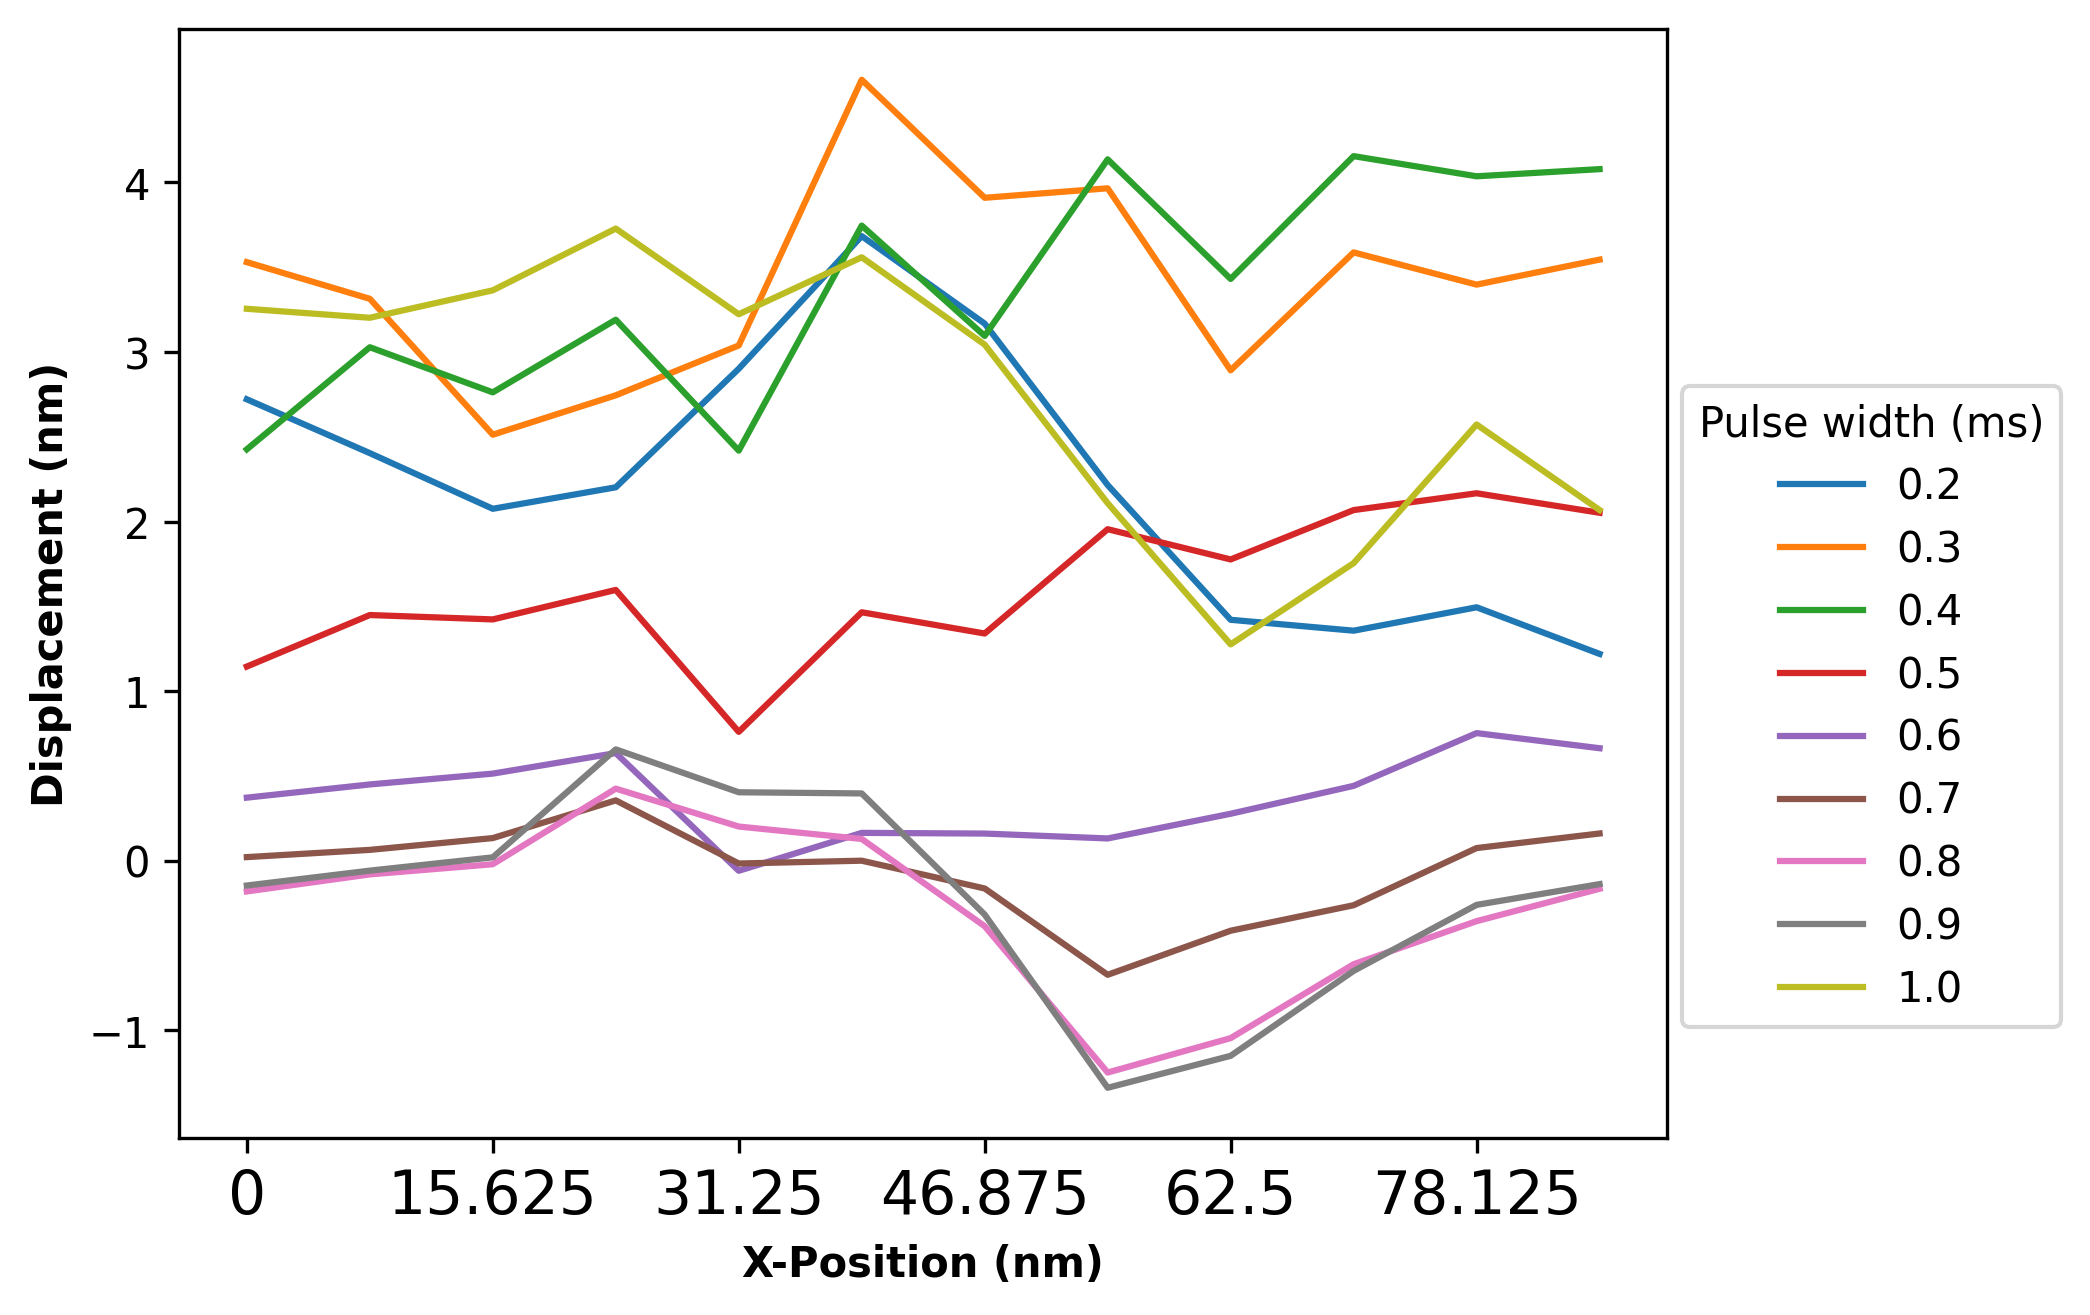

In [36]:


outputs = []
test_images, test_actions = [], []

#test_image = mxvalid[0][1]
#test_image = np.full(14,0.5)
test_image = out

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


#for v in voltages:

for p in pwidths:
    test_action_val_new_valv=-0.5
    test_action_val_new_valp=p    
    test_actions.append([test_action_val_new_valv, test_action_val_new_valp])

    test_images.append(test_image)

test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
df = df*7.8125
#maxValues = df.abs().max(axis = 1)
#maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*500
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(df, left_index=True, right_index=True)

labels = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
labels=labels*500
for i in range(9):
    plt.plot(df.T[i], label=labels[i])
    plt.legend(loc=(1.01,0.1), title='Pulse width (ms)')
    plt.ylabel("Displacement (nm)",fontweight='bold')
    plt.xticks([0,2,4,6,8,10],[0,2*7.8125,4*7.8125,6*7.8125,8*7.8125,10*7.8125])
    plt.xlabel("X-Position (nm)",fontweight='bold')

    

arr = np.trapz((df.T-df.T.min()))

[ 0.         -0.01609449 -0.02431608  0.00636413  0.02215511  0.04412076
  0.05582548  0.07156721  0.04594366  0.01798202  0.00879482  0.02019078
  0.04002864  0.        ]


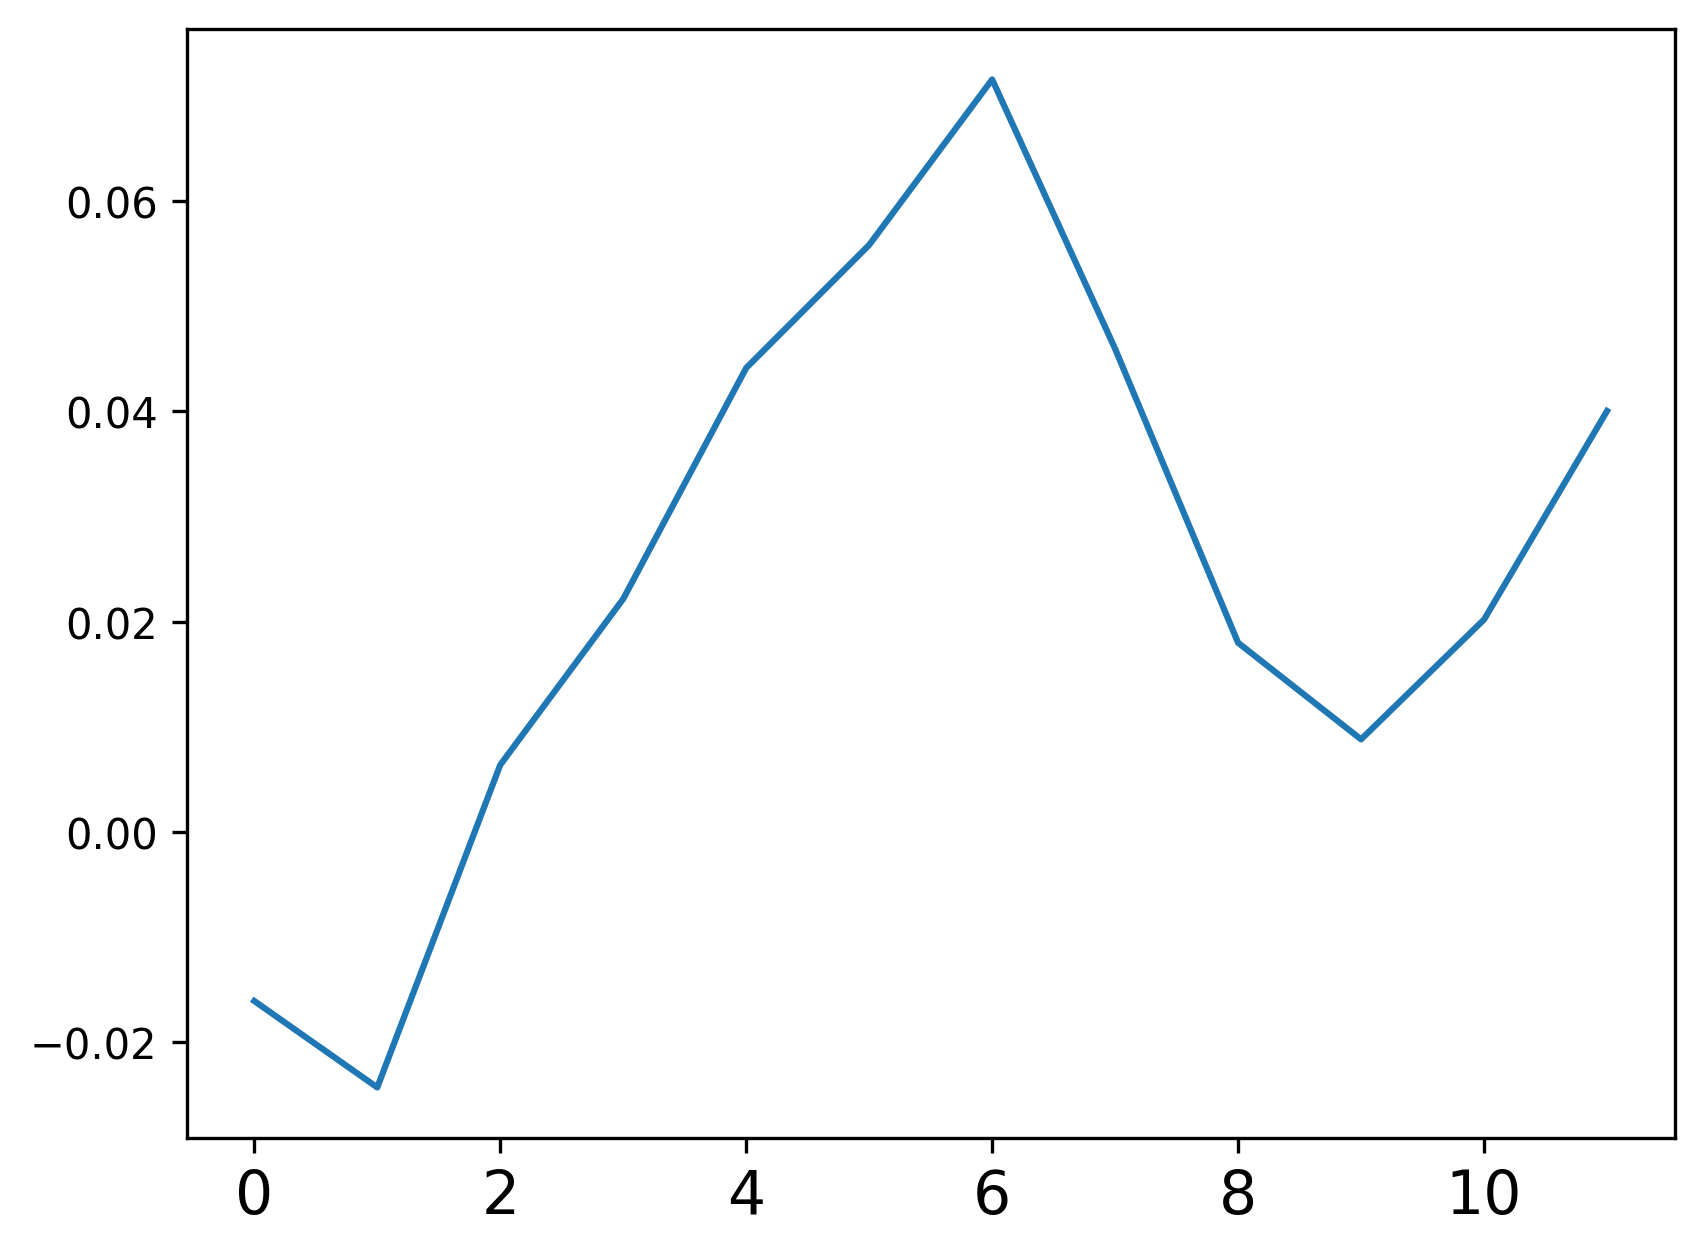

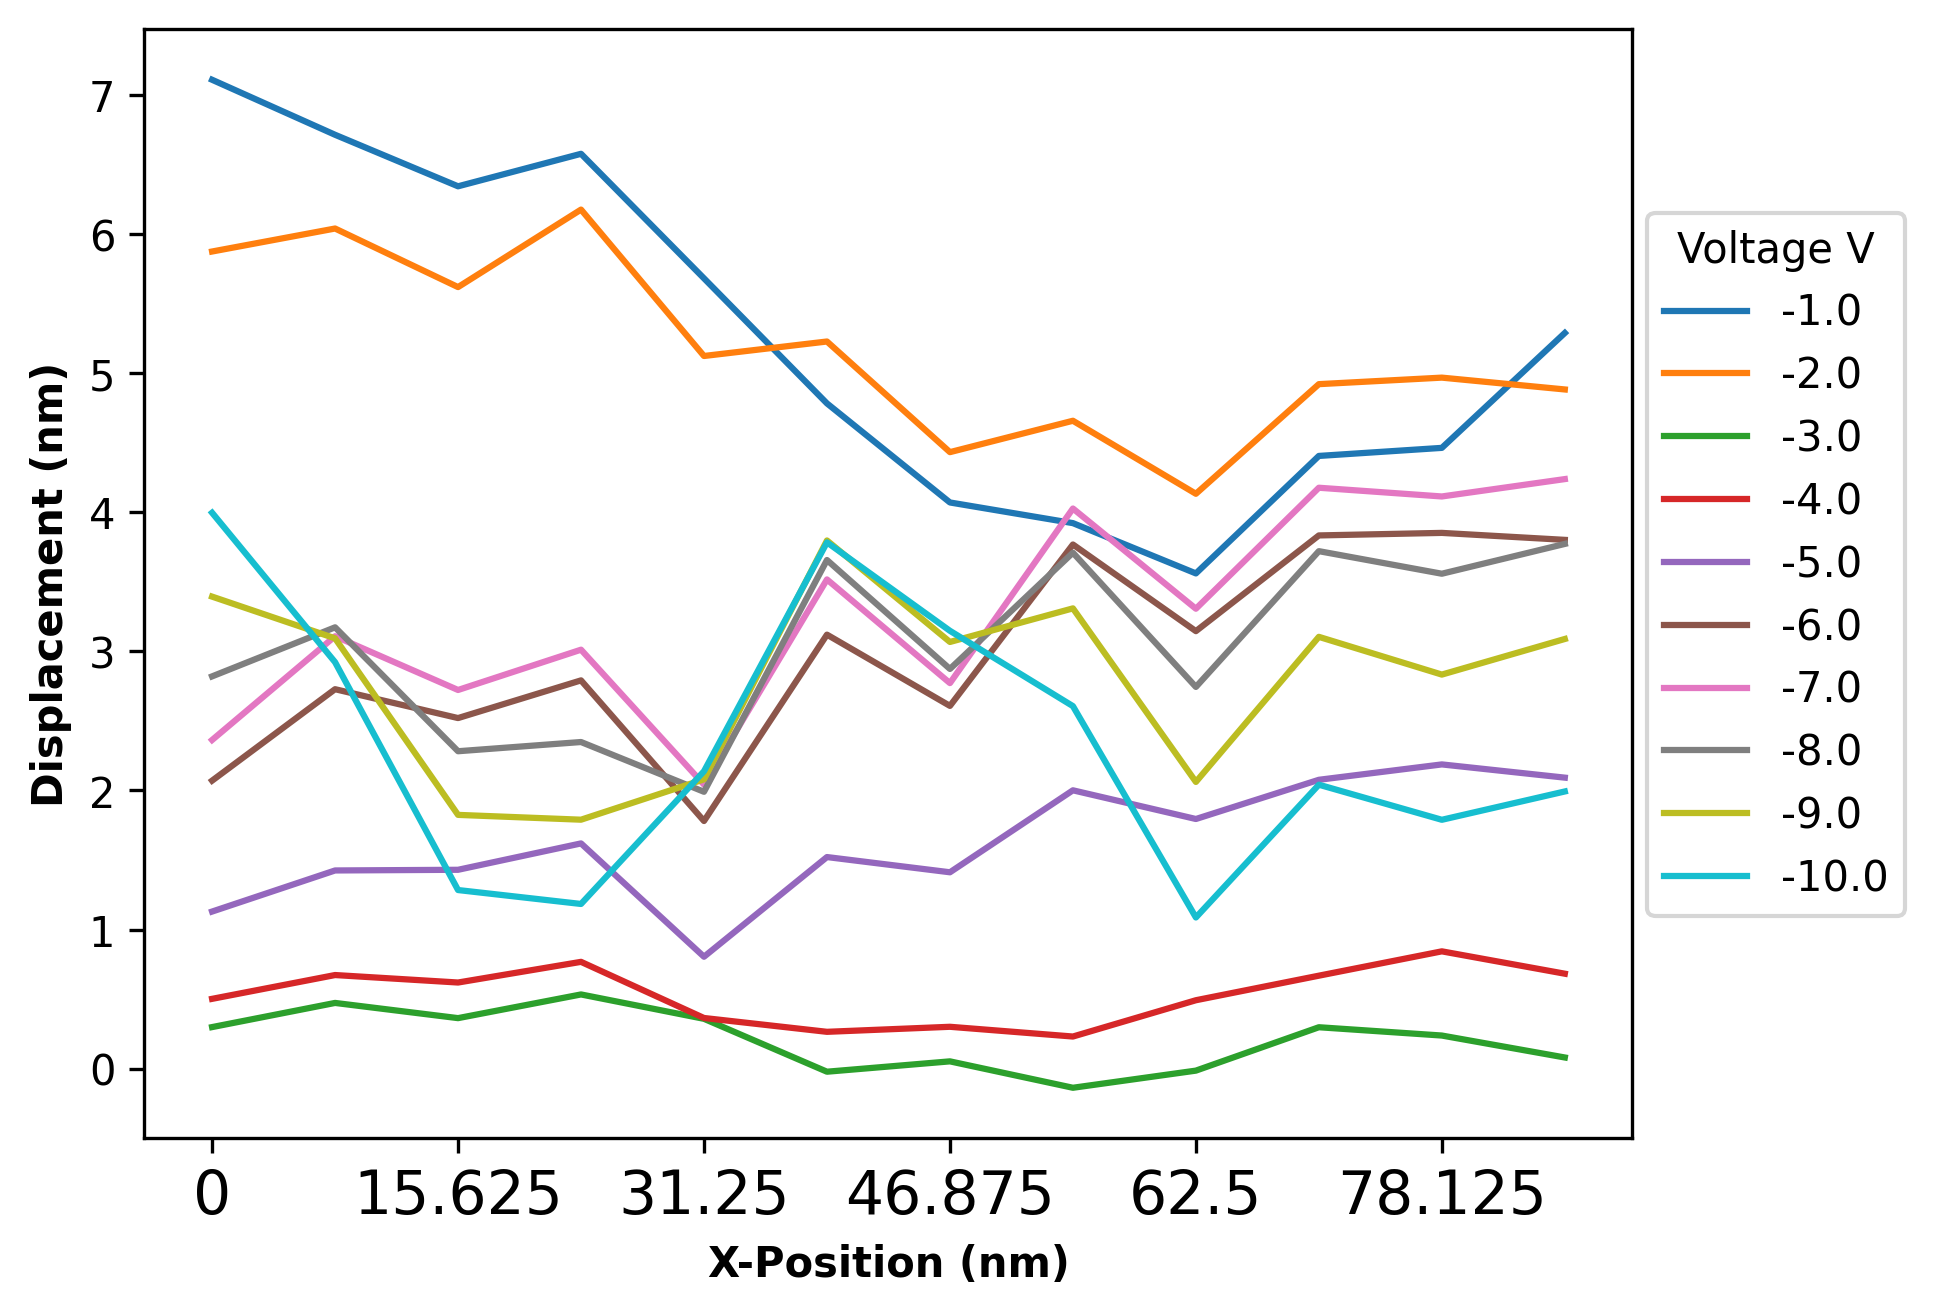

In [37]:


outputs = []
test_images, test_actions = [], []

#test_image = mxvalid[0][1]
#test_image = np.full(14,(-0.5+i/10))
test_image = out
print(test_image)
add = np.array(test_image[1:-1])
plt.plot(test_image[1:-1])
plt.show()

#voltages = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
voltages = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1.0]
pwidths = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    #for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=0.5    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])

        test_images.append(test_image)

test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
df = df*7.8125
#maxValues = df.abs().max(axis = 1)
#maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*500
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(df, left_index=True, right_index=True)

labels = [-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,-10.0]
#labels = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]

for i in range(10):
    plotstuff = df.T[i]+add[:]
        #print(add)
    plt.plot(plotstuff, label=labels[i])
    #plt.plot(df.T[i], label=labels[i])
    plt.legend(loc=(1.01,0.2), title='Voltage V')
    plt.ylabel("Displacement (nm)",fontweight='bold')
    plt.xticks([0,2,4,6,8,10],[0,2*7.8125,4*7.8125,6*7.8125,8*7.8125,10*7.8125])
    plt.xlabel("X-Position (nm)",fontweight='bold')
plt.show()

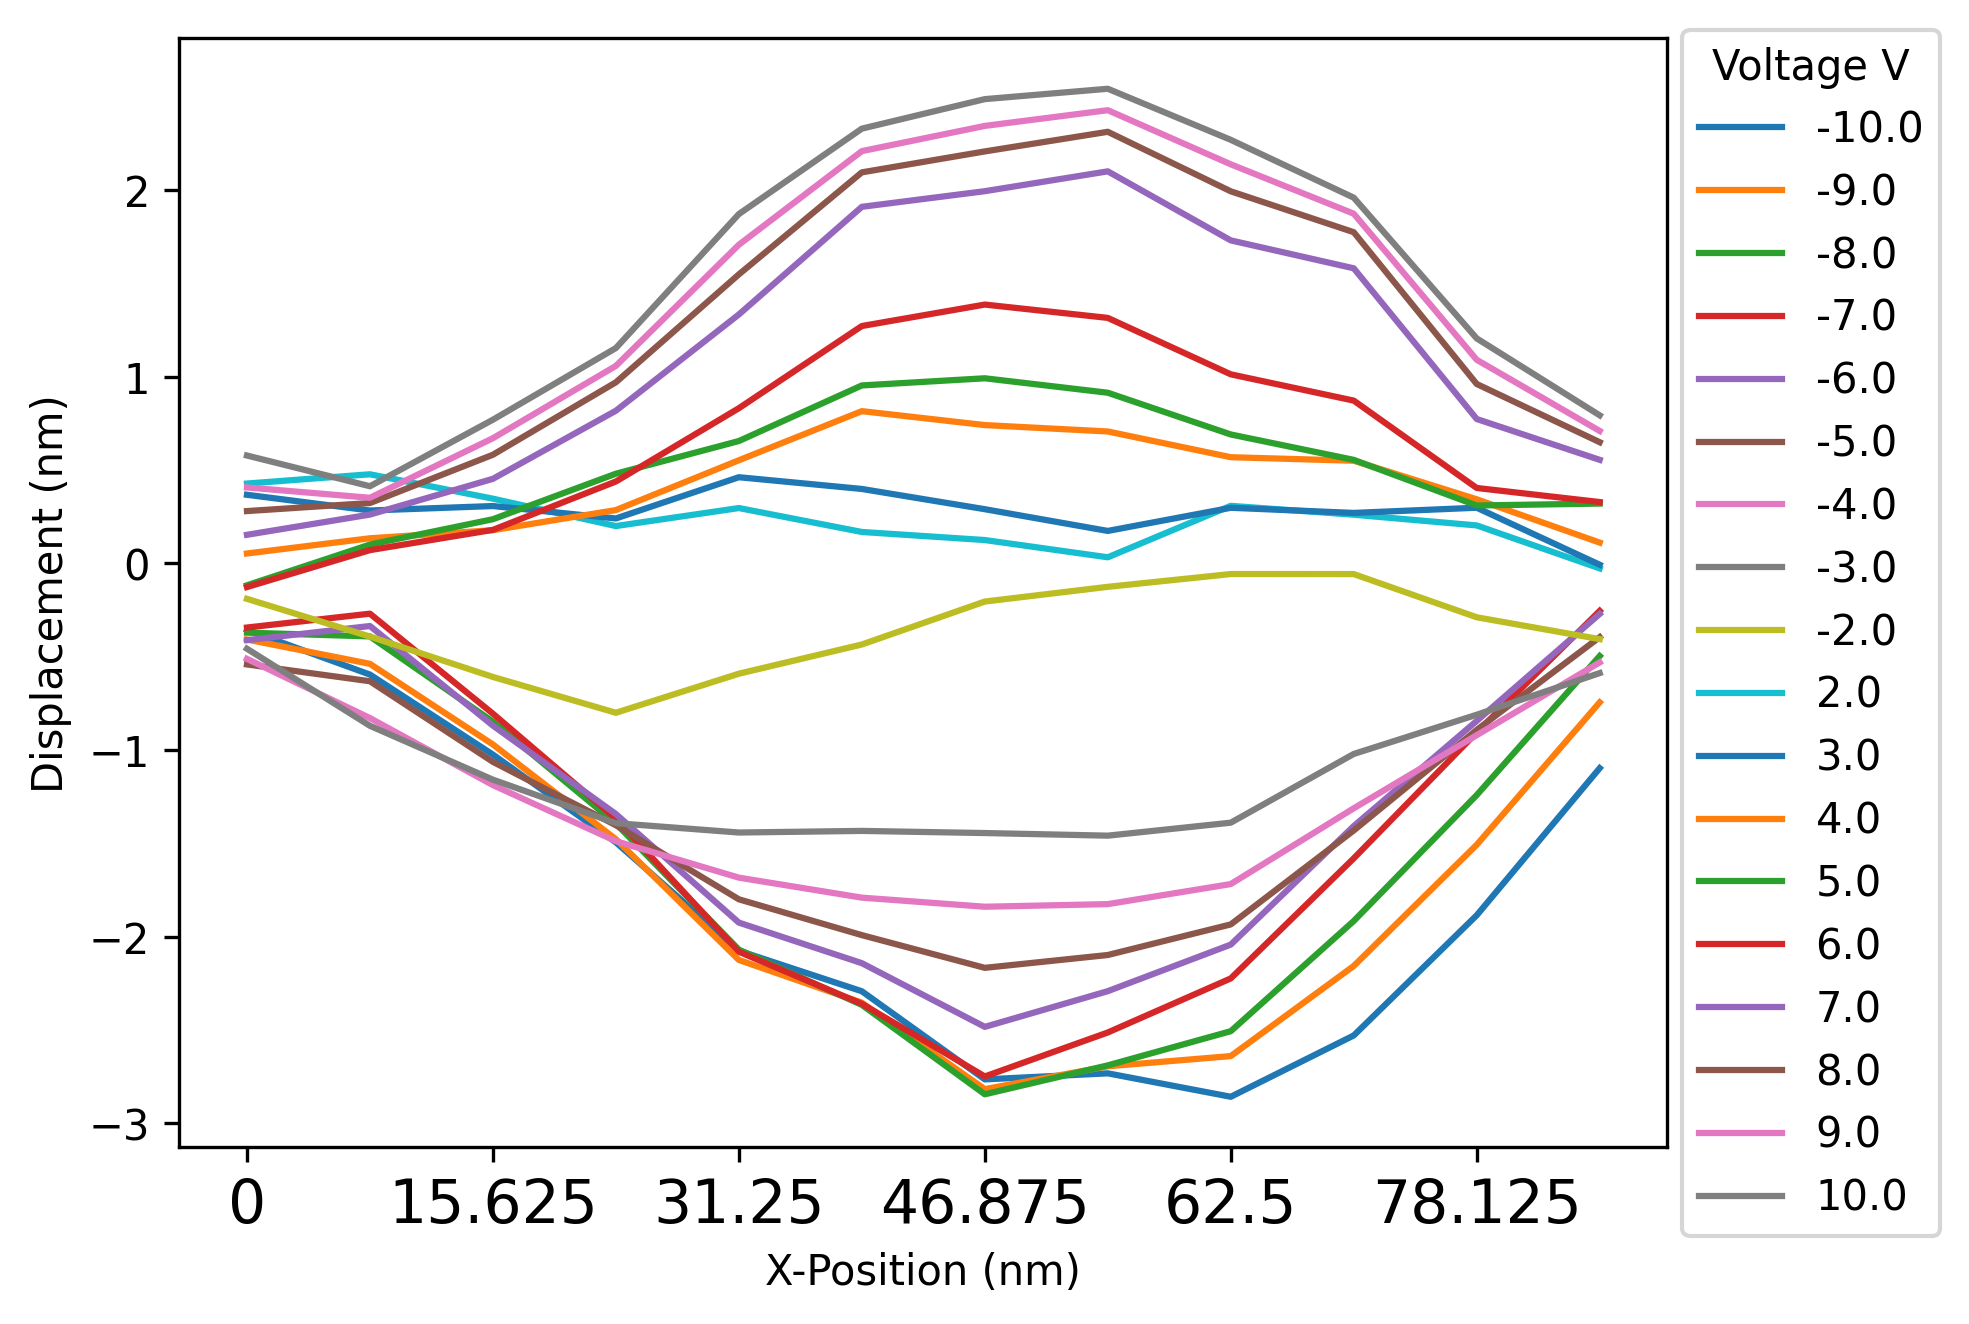

In [38]:


outputs = []
test_images, test_actions = [], []

#test_image = mxvalid[0][1]
test_image = np.full(14,-0.1)
#test_image = out

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    #for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=0.5    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])

        test_images.append(test_image)

test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
df = df*7.8125
#maxValues = df.abs().max(axis = 1)
#maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*500
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(df, left_index=True, right_index=True)

labels = [-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
for i in range(18):
    plt.plot(df.T[i], label=labels[i])
    plt.legend(loc=(1.01,-0.08), title='Voltage V')
    plt.ylabel("Displacement (nm)")
    plt.xticks([0,2,4,6,8,10],[0,2*7.8125,4*7.8125,6*7.8125,8*7.8125,10*7.8125])
    plt.xlabel("X-Position (nm)")


[ 0.         -0.01609449 -0.02431608  0.00636413  0.02215511  0.04412076
  0.05582548  0.07156721  0.04594366  0.01798202  0.00879482  0.02019078
  0.04002864  0.        ]


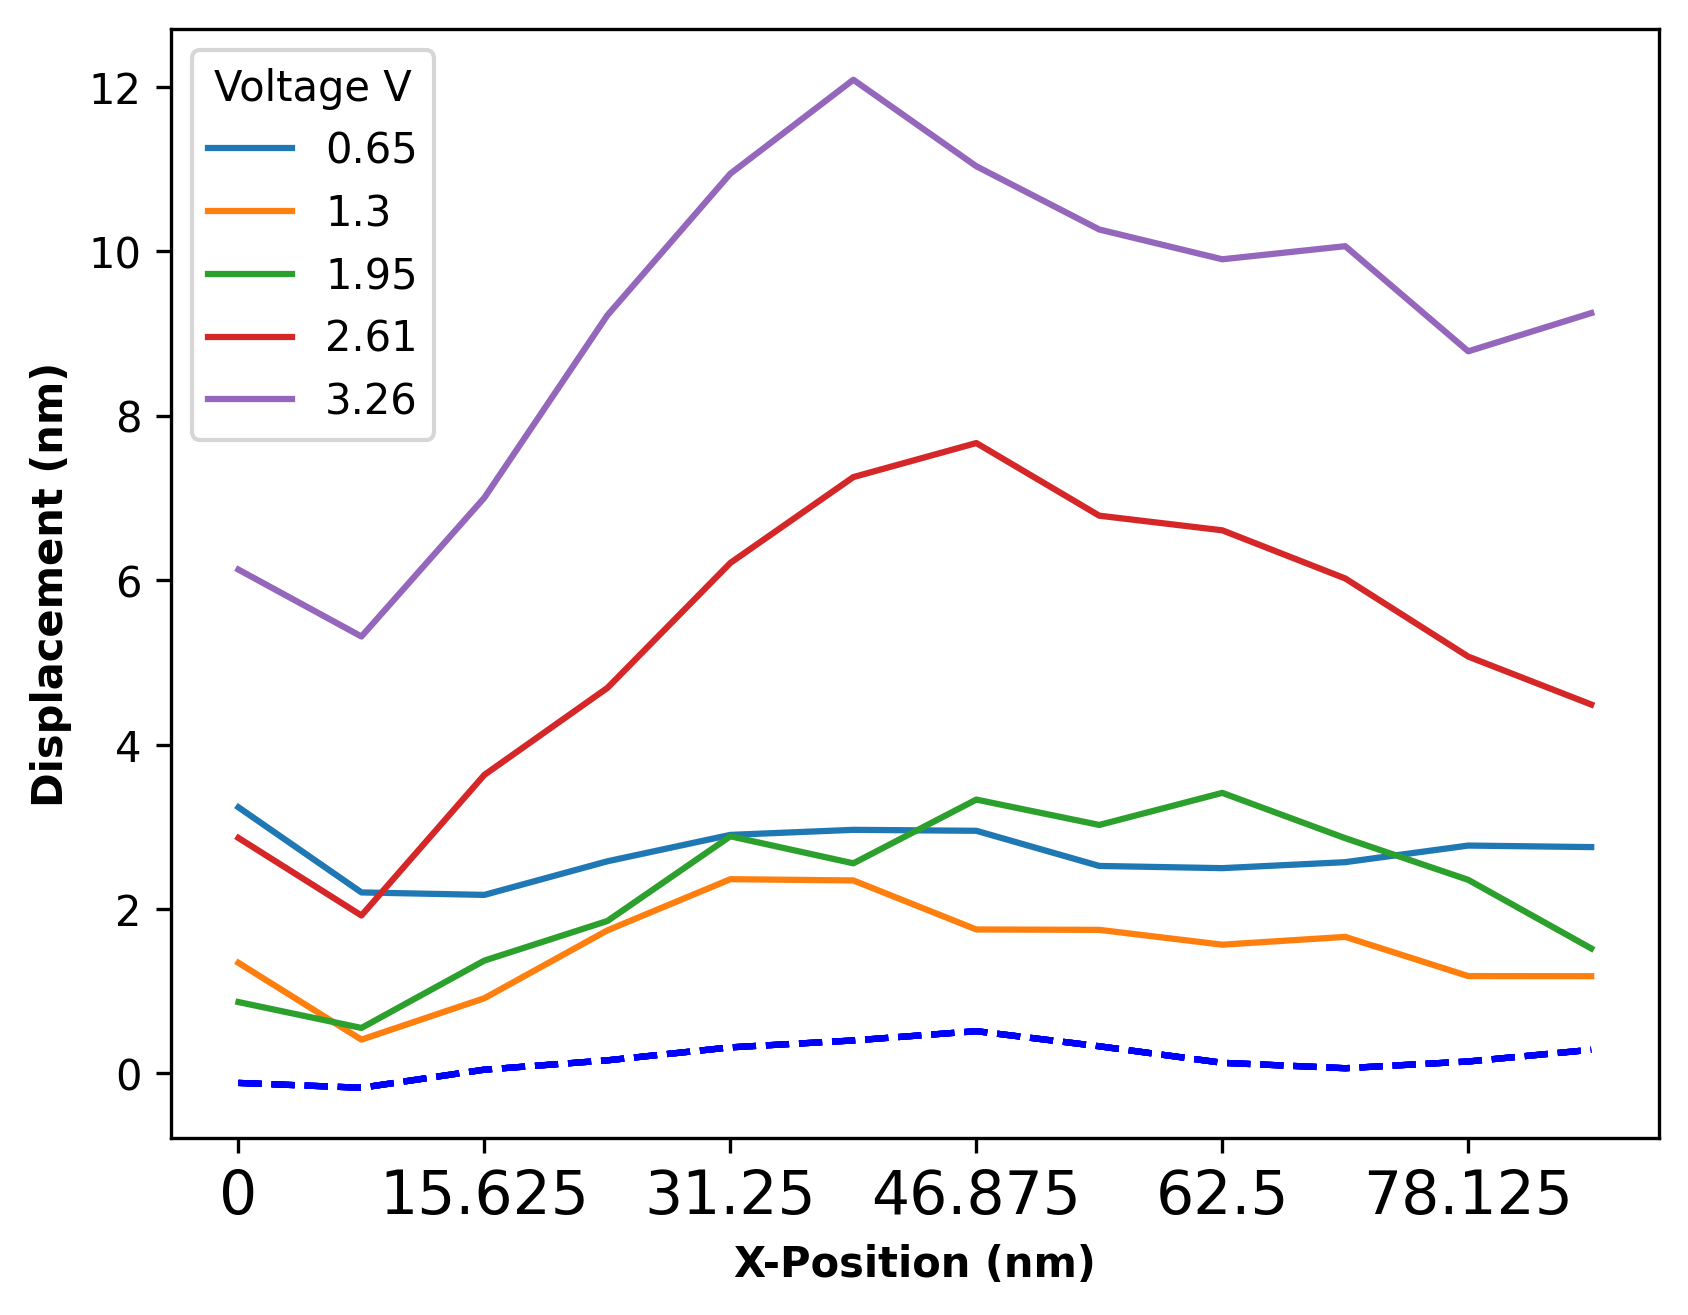

In [39]:


outputs = []
test_images, test_actions = [], []

#test_image = mxvalid[0][1]
#test_image = np.full(14,(-0.3))
test_image = out
print(test_image)
add = np.array(test_image[1:-1])


#voltages = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
voltages = [0.65,1.30,1.95,2.61,3.26]
#voltages = [-0.65,-1.30,-1.95,-2.61,-3.26]
#voltages = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1.0]
pwidths = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    #for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=0.5    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])

        test_images.append(test_image)

test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
df = df*7.8125
#maxValues = df.abs().max(axis = 1)
#maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*500
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(df, left_index=True, right_index=True)

#labels = [-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,-10.0]
#labels = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
#labels = [-0.65,-1.30,-1.95,-2.61,-3.26]
labels = [0.65,1.30,1.95,2.61,3.26]
for i in range(5):
    plotstuff = df.T[i]+(add[:]*7.8125)
    plt.plot(plotstuff, label=labels[i])
        #print(add)
    #plt.plot(df.T[i], label=labels[i])
    #plt.plot(df.T[i], label=labels[i])
    plt.legend( title='Voltage V')
    plt.ylabel("Displacement (nm)",fontweight='bold')
    plt.plot(add*7.1825, 'b--')
    plt.xticks([0,2,4,6,8,10],[0,2*7.8125,4*7.8125,6*7.8125,8*7.8125,10*7.8125])
    plt.xlabel("X-Position (nm)",fontweight='bold')
plt.show()

[ 0.         -0.01609449 -0.02431608  0.00636413  0.02215511  0.04412076
  0.05582548  0.07156721  0.04594366  0.01798202  0.00879482  0.02019078
  0.04002864  0.        ]


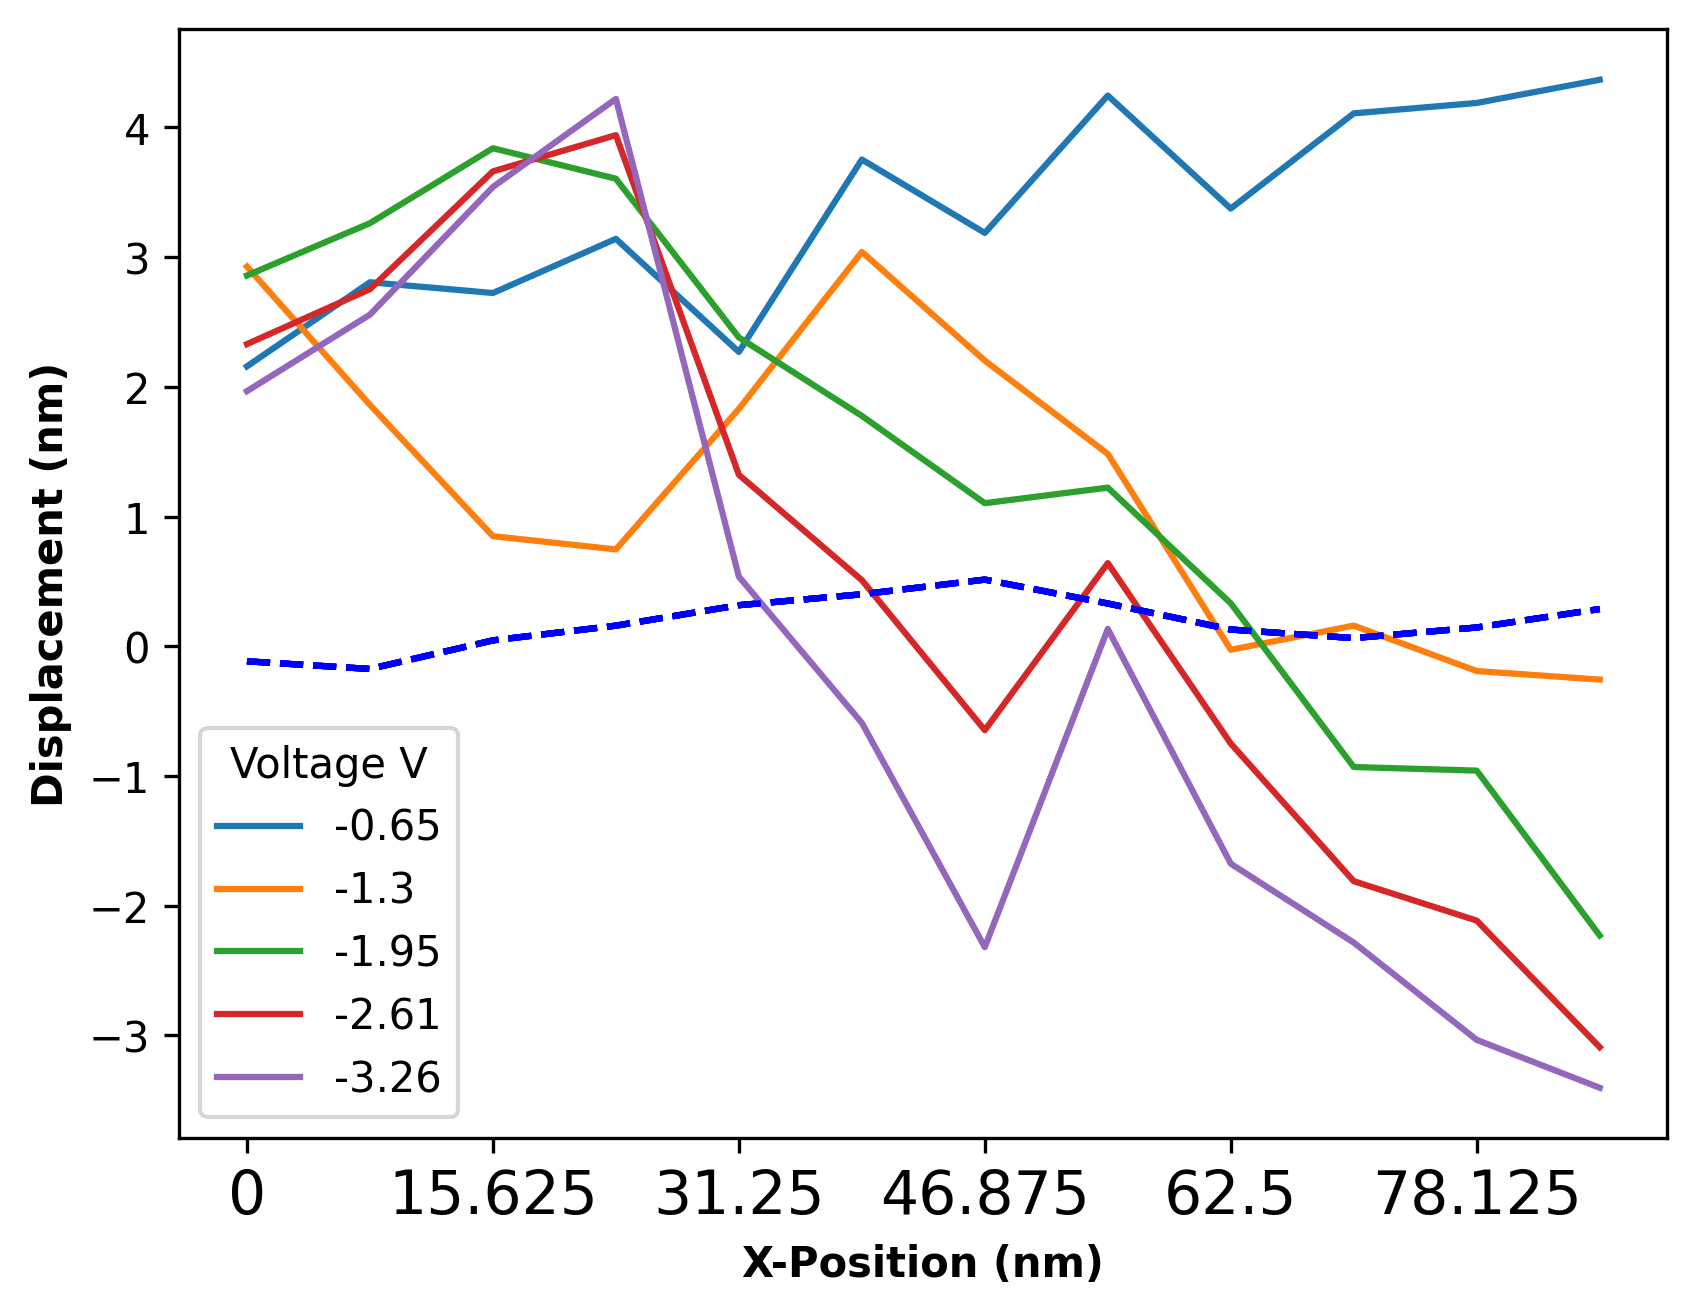

In [40]:


outputs = []
test_images, test_actions = [], []

#test_image = mxvalid[0][1]
#test_image = np.full(14,(-0.3))
test_image = out
print(test_image)
add = np.array(test_image[1:-1])


#voltages = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#voltages = [0.65,1.30,1.95,2.61,3.26]
voltages = [-0.65,-1.30,-1.95,-2.61,-3.26]
#voltages = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1.0]
pwidths = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    #for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=0.5    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])

        test_images.append(test_image)

test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
df = df*7.8125
#maxValues = df.abs().max(axis = 1)
#maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*500
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(df, left_index=True, right_index=True)

#labels = [-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,-10.0]
#labels = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
labels = [-0.65,-1.30,-1.95,-2.61,-3.26]
#labels = [0.65,1.30,1.95,2.61,3.26]
for i in range(5):
    plotstuff = df.T[i]+(add[:]*7.8125)
    plt.plot(plotstuff, label=labels[i])
        #print(add)
    #plt.plot(df.T[i], label=labels[i])
    #plt.plot(df.T[i], label=labels[i])
    plt.legend( title='Voltage V')
    plt.ylabel("Displacement (nm)",fontweight='bold')
    plt.plot(add*7.1825, 'b--')
    plt.xticks([0,2,4,6,8,10],[0,2*7.8125,4*7.8125,6*7.8125,8*7.8125,10*7.8125])
    plt.xlabel("X-Position (nm)",fontweight='bold')
plt.show()